In [1]:
import openml

# Basic Image classification task

In [2]:
# openml imports
import openml
import openml_pytorch
from openml_pytorch.callbacks import TestCallback
from openml_pytorch.metrics import accuracy
from openml_pytorch.trainer import OpenMLDataModule, OpenMLTrainerModule, convert_to_rgb

# pytorch imports
from torch.utils.tensorboard.writer import SummaryWriter
from torchvision.transforms import Compose, Resize, ToPILImage, ToTensor, Lambda
import torchvision
from torchvision import transforms
# other imports
import logging
import warnings

# set up logging
openml.config.logger.setLevel(logging.DEBUG)
openml_pytorch.config.logger.setLevel(logging.DEBUG)
# openml.config.start_using_configuration_for_example()
warnings.simplefilter(action='ignore')

## Data

### Define image transformations


In [3]:

transform = Compose(
    [
        ToPILImage(),  # Convert tensor to PIL Image to ensure PIL Image operations can be applied.
        Lambda(convert_to_rgb),  # Convert PIL Image to RGB if it's not already.
        Resize((224, 224)),  # Resize the image.
        ToTensor(),  # Convert the PIL Image back to a tensor.
    ]
)
transform_test = Compose(
    [
        transforms.RandomRotation(degrees=5),
        ToPILImage(),  # Convert tensor to PIL Image to ensure PIL Image operations can be applied.
        Lambda(convert_to_rgb),  # Convert PIL Image to RGB if it's not already.
        Resize((224, 224)),  # Resize the image.
        ToTensor(),  # Convert the PIL Image back to a tensor.
    ]
)

### Configure the Data Module and Choose a Task
- Make sure the data is present in the `file_dir` directory, and the `filename_col` is correctly set along with this column correctly pointing to where your data is stored. 


In [4]:
data_module = OpenMLDataModule(
    type_of_data="image",
    file_dir="datasets",
    filename_col="image_path",
    target_mode="categorical",
    target_column="label",
    batch_size=32,
    transform=transform,
    transform_test = transform_test
)

# Download the OpenML task for tiniest imagenet
task = openml.tasks.get_task(363295)


In [5]:
task

OpenML Classification Task
Task Type Description: https://www.openml.org/tt/TaskType.SUPERVISED_CLASSIFICATION
Task ID..............: 363295
Task URL.............: https://www.openml.org/t/363295
Estimation Procedure.: crossvalidation
Evaluation Measure...: predictive_accuracy
Target Feature.......: label
# of Classes.........: 200
Cost Matrix..........: Available

## Model

In [6]:
model = torchvision.models.resnet18(num_classes=200)

In [8]:
# from transformers import ViTForImageClassification

# model_o = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224", max_memory = {"cpu": "2GiB", "gpu": "2GiB", "mps": "2GiB"})
from transformers import AutoImageProcessor, AutoModelForImageClassification

from transformers import AutoImageProcessor, AutoModelForImageClassification

processor = AutoImageProcessor.from_pretrained("microsoft/resnet-18")
model_o = AutoModelForImageClassification.from_pretrained("microsoft/resnet-18")
import torch
class TransformerCompatibility(torch.nn.Module):
    def __init__(self, model_from_pretrained, num_classes) -> None:
        super(TransformerCompatibility, self).__init__()
        self.model = model_from_pretrained
        # self.model.classifier = torch.nn.Linear(self.model.classifier.in_features, num_classes)
        self.model.classifier._modules['1'] = torch.nn.Linear(self.model.classifier._modules['1'].in_features, num_classes)

    def forward(self, input):
        # The ViT model expects the input to be of shape (batch_size, num_channels, height, width)
        # Ensure the input is in the correct shape
        if len(input.shape) == 3:
            input = input.unsqueeze(0)
        # Forward pass through the model
        outputs = self.model(input)
        # The output is a tuple, where the first element is the logits
        logits = outputs.logits
        return logits

    
model = TransformerCompatibility(model_o, num_classes=200)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


## Train your model on the data
- Note that by default, OpenML runs a 10 fold cross validation on the data. You cannot change this for now.

In [9]:
import torch


trainer = OpenMLTrainerModule(
    experiment_name= "Tiny ImageNet, Resnet18 huggingface model",
    data_module=data_module,
    verbose=True,
    epoch_count=1,
    metrics= [accuracy],
    # remove the TestCallback when you are done testing your pipeline. Having it here will make the pipeline run for a very short time.
    callbacks=[
        # TestCallback,
    ],
    opt=torch.optim.Adam,
    loss_fn = torch.nn.CrossEntropyLoss
)
openml_pytorch.config.trainer = trainer
run = openml.runs.run_model_on_task(model, task, avoid_duplicate_runs=False)

While models of this type are not officially supported, we will try to serialize them anyway.
While models of this type are not officially supported, we will try to serialize them anyway.
Cross validation 0 for 363295


Training Epoch 0:   0%|          | 0/51 [00:00<?, ?it/s]`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.



Epoch 0
----------------------------------------
Train: train loss: 6.0253 | accuracy: 0.0052 | other metrics: []
Valid: valid loss: 6.5944 | accuracy: 0.0083 | other metrics: []

Loss tensor(5.5732, device='mps:0')
Cross validation 1 for 363295



Epoch 0
----------------------------------------
Train: train loss: 6.1505 | accuracy: 0.0065 | other metrics: []
Valid: valid loss: 5.5174 | accuracy: 0.0028 | other metrics: []

Loss tensor(5.4212, device='mps:0')
Cross validation 2 for 363295



Epoch 0
----------------------------------------
Train: train loss: 6.0108 | accuracy: 0.0034 | other metrics: []
Valid: valid loss: 5.5783 | accuracy: 0.0028 | other metrics: []

Loss tensor(5.6218, device='mps:0')
Cross validation 3 for 363295



Epoch 0
----------------------------------------
Train: train loss: 6.2228 | accuracy: 0.0043 | other metrics: []
Valid: valid loss: 6.0394 | accuracy: 0.0056 | other metrics: []

Loss tensor(5.9906, device='mps:0')
Cross validation 4 for 363295



Epoch 0
----------------------------------------
Train: train loss: 6.0883 | accuracy: 0.0052 | other metrics: []
Valid: valid loss: 5.4498 | accuracy: 0.0111 | other metrics: []

Loss tensor(5.4900, device='mps:0')
Cross validation 5 for 363295



Epoch 0
----------------------------------------
Train: train loss: 6.0312 | accuracy: 0.0062 | other metrics: []
Valid: valid loss: 5.9689 | accuracy: 0.0056 | other metrics: []

Loss tensor(5.4171, device='mps:0')
Cross validation 6 for 363295



Epoch 0
----------------------------------------
Train: train loss: 6.0171 | accuracy: 0.0059 | other metrics: []
Valid: valid loss: 5.5639 | accuracy: 0.0056 | other metrics: []

Loss tensor(5.6942, device='mps:0')
Cross validation 7 for 363295



Epoch 0
----------------------------------------
Train: train loss: 6.1807 | accuracy: 0.0040 | other metrics: []
Valid: valid loss: 5.5765 | accuracy: 0.0056 | other metrics: []

Loss tensor(5.7509, device='mps:0')
Cross validation 8 for 363295



Epoch 0
----------------------------------------
Train: train loss: 5.9507 | accuracy: 0.0065 | other metrics: []
Valid: valid loss: 5.9747 | accuracy: 0.0056 | other metrics: []

Loss tensor(5.4396, device='mps:0')
Cross validation 9 for 363295



Epoch 0
----------------------------------------
Train: train loss: 6.0779 | accuracy: 0.0052 | other metrics: []
Valid: valid loss: 5.6762 | accuracy: 0.0028 | other metrics: []

Loss tensor(5.5303, device='mps:0')


In [10]:
openml.config.apikey = "9cfaf2bb33bd321a7730903a45ea0a45"

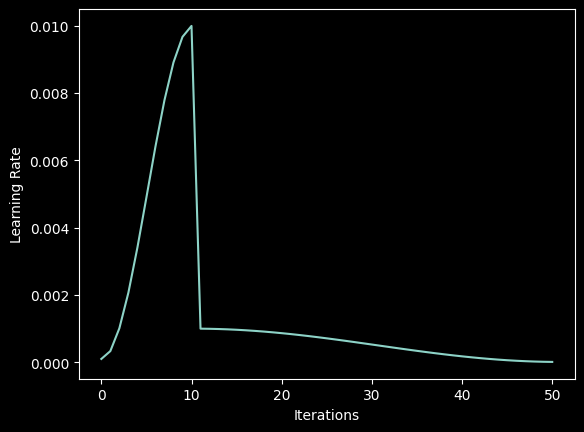

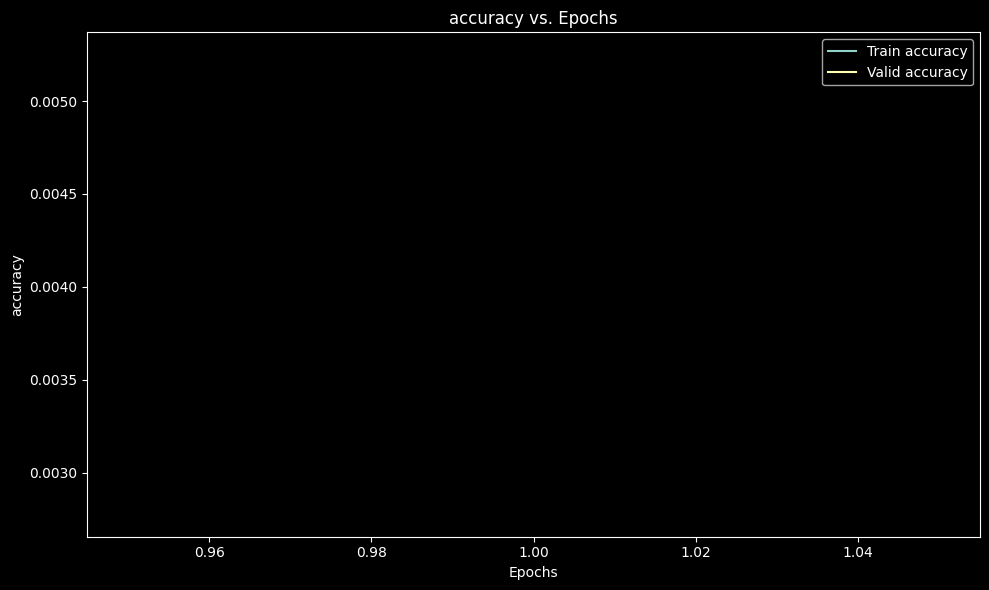

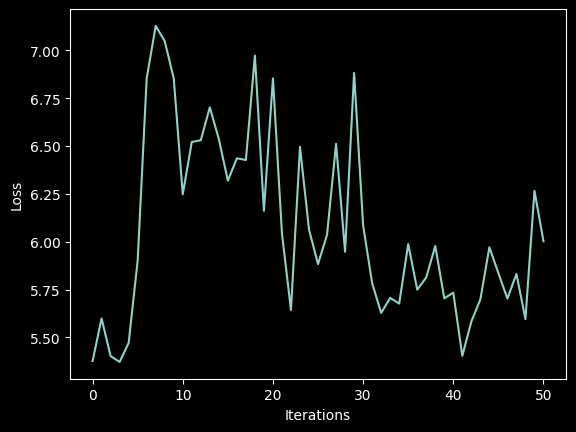

In [11]:
run = openml_pytorch.add_experiment_info_to_run(run=run, trainer=trainer)

In [12]:
run.publish()

OpenMLServerException: https://www.openml.org/api/v1/xml/flow/ returned code 163: 
<oml:flow xmlns:oml="http://openml.org/openml">
	<oml:name>torch.nn.TransformerCompatibility.63f98638a15a66f6</oml:name>
	<oml:class_name>torch.nn.TransformerCompatibility.63f98638a15a66f6</oml:class_name>
	<oml:external_version>__main__==module.__version__,openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
	<oml:description>Automatically created pytorch flow.</oml:description>
	<oml:language>English</oml:language>
	<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
	<oml:parameter>
		<oml:name>model</oml:name>
		<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "model", "step_name": null}}</oml:default_value>
	</oml:parameter>
	<oml:component>
		<oml:identifier>model</oml:identifier>
		<oml:flow xmlns:oml="http://openml.org/openml">
			<oml:name>torch.nn.ResNetForImageClassification.8223dbefab046813</oml:name>
			<oml:class_name>torch.nn.ResNetForImageClassification.8223dbefab046813</oml:class_name>
			<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
			<oml:description>Automatically created pytorch flow.</oml:description>
			<oml:language>English</oml:language>
			<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
			<oml:parameter>
				<oml:name>classifier</oml:name>
				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "classifier", "step_name": null}}</oml:default_value>
			</oml:parameter>
			<oml:parameter>
				<oml:name>config</oml:name>
				<oml:default_value>"ResNetConfig {\n  \"_attn_implementation_autoset\": true,\n  \"architectures\": [\n    \"ResNetForImageClassification\"\n  ],\n  \"depths\": [\n    2,\n    2,\n    2,\n    2\n  ],\n  \"downsample_in_bottleneck\": false,\n  \"downsample_in_first_stage\": false,\n  \"embedding_size\": 64,\n  \"hidden_act\": \"relu\",\n  \"hidden_sizes\": [\n    64,\n    128,\n    256,\n    512\n  ],\n  \"id2label\": {\n    \"0\": \"tench, Tinca tinca\",\n    \"1\": \"goldfish, Carassius auratus\",\n    \"2\": \"great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias\",\n    \"3\": \"tiger shark, Galeocerdo cuvieri\",\n    \"4\": \"hammerhead, hammerhead shark\",\n    \"5\": \"electric ray, crampfish, numbfish, torpedo\",\n    \"6\": \"stingray\",\n    \"7\": \"cock\",\n    \"8\": \"hen\",\n    \"9\": \"ostrich, Struthio camelus\",\n    \"10\": \"brambling, Fringilla montifringilla\",\n    \"11\": \"goldfinch, Carduelis carduelis\",\n    \"12\": \"house finch, linnet, Carpodacus mexicanus\",\n    \"13\": \"junco, snowbird\",\n    \"14\": \"indigo bunting, indigo finch, indigo bird, Passerina cyanea\",\n    \"15\": \"robin, American robin, Turdus migratorius\",\n    \"16\": \"bulbul\",\n    \"17\": \"jay\",\n    \"18\": \"magpie\",\n    \"19\": \"chickadee\",\n    \"20\": \"water ouzel, dipper\",\n    \"21\": \"kite\",\n    \"22\": \"bald eagle, American eagle, Haliaeetus leucocephalus\",\n    \"23\": \"vulture\",\n    \"24\": \"great grey owl, great gray owl, Strix nebulosa\",\n    \"25\": \"European fire salamander, Salamandra salamandra\",\n    \"26\": \"common newt, Triturus vulgaris\",\n    \"27\": \"eft\",\n    \"28\": \"spotted salamander, Ambystoma maculatum\",\n    \"29\": \"axolotl, mud puppy, Ambystoma mexicanum\",\n    \"30\": \"bullfrog, Rana catesbeiana\",\n    \"31\": \"tree frog, tree-frog\",\n    \"32\": \"tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui\",\n    \"33\": \"loggerhead, loggerhead turtle, Caretta caretta\",\n    \"34\": \"leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea\",\n    \"35\": \"mud turtle\",\n    \"36\": \"terrapin\",\n    \"37\": \"box turtle, box tortoise\",\n    \"38\": \"banded gecko\",\n    \"39\": \"common iguana, iguana, Iguana iguana\",\n    \"40\": \"American chameleon, anole, Anolis carolinensis\",\n    \"41\": \"whiptail, whiptail lizard\",\n    \"42\": \"agama\",\n    \"43\": \"frilled lizard, Chlamydosaurus kingi\",\n    \"44\": \"alligator lizard\",\n    \"45\": \"Gila monster, Heloderma suspectum\",\n    \"46\": \"green lizard, Lacerta viridis\",\n    \"47\": \"African chameleon, Chamaeleo chamaeleon\",\n    \"48\": \"Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis\",\n    \"49\": \"African crocodile, Nile crocodile, Crocodylus niloticus\",\n    \"50\": \"American alligator, Alligator mississipiensis\",\n    \"51\": \"triceratops\",\n    \"52\": \"thunder snake, worm snake, Carphophis amoenus\",\n    \"53\": \"ringneck snake, ring-necked snake, ring snake\",\n    \"54\": \"hognose snake, puff adder, sand viper\",\n    \"55\": \"green snake, grass snake\",\n    \"56\": \"king snake, kingsnake\",\n    \"57\": \"garter snake, grass snake\",\n    \"58\": \"water snake\",\n    \"59\": \"vine snake\",\n    \"60\": \"night snake, Hypsiglena torquata\",\n    \"61\": \"boa constrictor, Constrictor constrictor\",\n    \"62\": \"rock python, rock snake, Python sebae\",\n    \"63\": \"Indian cobra, Naja naja\",\n    \"64\": \"green mamba\",\n    \"65\": \"sea snake\",\n    \"66\": \"horned viper, cerastes, sand viper, horned asp, Cerastes cornutus\",\n    \"67\": \"diamondback, diamondback rattlesnake, Crotalus adamanteus\",\n    \"68\": \"sidewinder, horned rattlesnake, Crotalus cerastes\",\n    \"69\": \"trilobite\",\n    \"70\": \"harvestman, daddy longlegs, Phalangium opilio\",\n    \"71\": \"scorpion\",\n    \"72\": \"black and gold garden spider, Argiope aurantia\",\n    \"73\": \"barn spider, Araneus cavaticus\",\n    \"74\": \"garden spider, Aranea diademata\",\n    \"75\": \"black widow, Latrodectus mactans\",\n    \"76\": \"tarantula\",\n    \"77\": \"wolf spider, hunting spider\",\n    \"78\": \"tick\",\n    \"79\": \"centipede\",\n    \"80\": \"black grouse\",\n    \"81\": \"ptarmigan\",\n    \"82\": \"ruffed grouse, partridge, Bonasa umbellus\",\n    \"83\": \"prairie chicken, prairie grouse, prairie fowl\",\n    \"84\": \"peacock\",\n    \"85\": \"quail\",\n    \"86\": \"partridge\",\n    \"87\": \"African grey, African gray, Psittacus erithacus\",\n    \"88\": \"macaw\",\n    \"89\": \"sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita\",\n    \"90\": \"lorikeet\",\n    \"91\": \"coucal\",\n    \"92\": \"bee eater\",\n    \"93\": \"hornbill\",\n    \"94\": \"hummingbird\",\n    \"95\": \"jacamar\",\n    \"96\": \"toucan\",\n    \"97\": \"drake\",\n    \"98\": \"red-breasted merganser, Mergus serrator\",\n    \"99\": \"goose\",\n    \"100\": \"black swan, Cygnus atratus\",\n    \"101\": \"tusker\",\n    \"102\": \"echidna, spiny anteater, anteater\",\n    \"103\": \"platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus\",\n    \"104\": \"wallaby, brush kangaroo\",\n    \"105\": \"koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus\",\n    \"106\": \"wombat\",\n    \"107\": \"jellyfish\",\n    \"108\": \"sea anemone, anemone\",\n    \"109\": \"brain coral\",\n    \"110\": \"flatworm, platyhelminth\",\n    \"111\": \"nematode, nematode worm, roundworm\",\n    \"112\": \"conch\",\n    \"113\": \"snail\",\n    \"114\": \"slug\",\n    \"115\": \"sea slug, nudibranch\",\n    \"116\": \"chiton, coat-of-mail shell, sea cradle, polyplacophore\",\n    \"117\": \"chambered nautilus, pearly nautilus, nautilus\",\n    \"118\": \"Dungeness crab, Cancer magister\",\n    \"119\": \"rock crab, Cancer irroratus\",\n    \"120\": \"fiddler crab\",\n    \"121\": \"king crab, Alaska crab, Alaskan king crab, Alaska king crab, Paralithodes camtschatica\",\n    \"122\": \"American lobster, Northern lobster, Maine lobster, Homarus americanus\",\n    \"123\": \"spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish\",\n    \"124\": \"crayfish, crawfish, crawdad, crawdaddy\",\n    \"125\": \"hermit crab\",\n    \"126\": \"isopod\",\n    \"127\": \"white stork, Ciconia ciconia\",\n    \"128\": \"black stork, Ciconia nigra\",\n    \"129\": \"spoonbill\",\n    \"130\": \"flamingo\",\n    \"131\": \"little blue heron, Egretta caerulea\",\n    \"132\": \"American egret, great white heron, Egretta albus\",\n    \"133\": \"bittern\",\n    \"134\": \"crane\",\n    \"135\": \"limpkin, Aramus pictus\",\n    \"136\": \"European gallinule, Porphyrio porphyrio\",\n    \"137\": \"American coot, marsh hen, mud hen, water hen, Fulica americana\",\n    \"138\": \"bustard\",\n    \"139\": \"ruddy turnstone, Arenaria interpres\",\n    \"140\": \"red-backed sandpiper, dunlin, Erolia alpina\",\n    \"141\": \"redshank, Tringa totanus\",\n    \"142\": \"dowitcher\",\n    \"143\": \"oystercatcher, oyster catcher\",\n    \"144\": \"pelican\",\n    \"145\": \"king penguin, Aptenodytes patagonica\",\n    \"146\": \"albatross, mollymawk\",\n    \"147\": \"grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus\",\n    \"148\": \"killer whale, killer, orca, grampus, sea wolf, Orcinus orca\",\n    \"149\": \"dugong, Dugong dugon\",\n    \"150\": \"sea lion\",\n    \"151\": \"Chihuahua\",\n    \"152\": \"Japanese spaniel\",\n    \"153\": \"Maltese dog, Maltese terrier, Maltese\",\n    \"154\": \"Pekinese, Pekingese, Peke\",\n    \"155\": \"Shih-Tzu\",\n    \"156\": \"Blenheim spaniel\",\n    \"157\": \"papillon\",\n    \"158\": \"toy terrier\",\n    \"159\": \"Rhodesian ridgeback\",\n    \"160\": \"Afghan hound, Afghan\",\n    \"161\": \"basset, basset hound\",\n    \"162\": \"beagle\",\n    \"163\": \"bloodhound, sleuthhound\",\n    \"164\": \"bluetick\",\n    \"165\": \"black-and-tan coonhound\",\n    \"166\": \"Walker hound, Walker foxhound\",\n    \"167\": \"English foxhound\",\n    \"168\": \"redbone\",\n    \"169\": \"borzoi, Russian wolfhound\",\n    \"170\": \"Irish wolfhound\",\n    \"171\": \"Italian greyhound\",\n    \"172\": \"whippet\",\n    \"173\": \"Ibizan hound, Ibizan Podenco\",\n    \"174\": \"Norwegian elkhound, elkhound\",\n    \"175\": \"otterhound, otter hound\",\n    \"176\": \"Saluki, gazelle hound\",\n    \"177\": \"Scottish deerhound, deerhound\",\n    \"178\": \"Weimaraner\",\n    \"179\": \"Staffordshire bullterrier, Staffordshire bull terrier\",\n    \"180\": \"American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier\",\n    \"181\": \"Bedlington terrier\",\n    \"182\": \"Border terrier\",\n    \"183\": \"Kerry blue terrier\",\n    \"184\": \"Irish terrier\",\n    \"185\": \"Norfolk terrier\",\n    \"186\": \"Norwich terrier\",\n    \"187\": \"Yorkshire terrier\",\n    \"188\": \"wire-haired fox terrier\",\n    \"189\": \"Lakeland terrier\",\n    \"190\": \"Sealyham terrier, Sealyham\",\n    \"191\": \"Airedale, Airedale terrier\",\n    \"192\": \"cairn, cairn terrier\",\n    \"193\": \"Australian terrier\",\n    \"194\": \"Dandie Dinmont, Dandie Dinmont terrier\",\n    \"195\": \"Boston bull, Boston terrier\",\n    \"196\": \"miniature schnauzer\",\n    \"197\": \"giant schnauzer\",\n    \"198\": \"standard schnauzer\",\n    \"199\": \"Scotch terrier, Scottish terrier, Scottie\",\n    \"200\": \"Tibetan terrier, chrysanthemum dog\",\n    \"201\": \"silky terrier, Sydney silky\",\n    \"202\": \"soft-coated wheaten terrier\",\n    \"203\": \"West Highland white terrier\",\n    \"204\": \"Lhasa, Lhasa apso\",\n    \"205\": \"flat-coated retriever\",\n    \"206\": \"curly-coated retriever\",\n    \"207\": \"golden retriever\",\n    \"208\": \"Labrador retriever\",\n    \"209\": \"Chesapeake Bay retriever\",\n    \"210\": \"German short-haired pointer\",\n    \"211\": \"vizsla, Hungarian pointer\",\n    \"212\": \"English setter\",\n    \"213\": \"Irish setter, red setter\",\n    \"214\": \"Gordon setter\",\n    \"215\": \"Brittany spaniel\",\n    \"216\": \"clumber, clumber spaniel\",\n    \"217\": \"English springer, English springer spaniel\",\n    \"218\": \"Welsh springer spaniel\",\n    \"219\": \"cocker spaniel, English cocker spaniel, cocker\",\n    \"220\": \"Sussex spaniel\",\n    \"221\": \"Irish water spaniel\",\n    \"222\": \"kuvasz\",\n    \"223\": \"schipperke\",\n    \"224\": \"groenendael\",\n    \"225\": \"malinois\",\n    \"226\": \"briard\",\n    \"227\": \"kelpie\",\n    \"228\": \"komondor\",\n    \"229\": \"Old English sheepdog, bobtail\",\n    \"230\": \"Shetland sheepdog, Shetland sheep dog, Shetland\",\n    \"231\": \"collie\",\n    \"232\": \"Border collie\",\n    \"233\": \"Bouvier des Flandres, Bouviers des Flandres\",\n    \"234\": \"Rottweiler\",\n    \"235\": \"German shepherd, German shepherd dog, German police dog, alsatian\",\n    \"236\": \"Doberman, Doberman pinscher\",\n    \"237\": \"miniature pinscher\",\n    \"238\": \"Greater Swiss Mountain dog\",\n    \"239\": \"Bernese mountain dog\",\n    \"240\": \"Appenzeller\",\n    \"241\": \"EntleBucher\",\n    \"242\": \"boxer\",\n    \"243\": \"bull mastiff\",\n    \"244\": \"Tibetan mastiff\",\n    \"245\": \"French bulldog\",\n    \"246\": \"Great Dane\",\n    \"247\": \"Saint Bernard, St Bernard\",\n    \"248\": \"Eskimo dog, husky\",\n    \"249\": \"malamute, malemute, Alaskan malamute\",\n    \"250\": \"Siberian husky\",\n    \"251\": \"dalmatian, coach dog, carriage dog\",\n    \"252\": \"affenpinscher, monkey pinscher, monkey dog\",\n    \"253\": \"basenji\",\n    \"254\": \"pug, pug-dog\",\n    \"255\": \"Leonberg\",\n    \"256\": \"Newfoundland, Newfoundland dog\",\n    \"257\": \"Great Pyrenees\",\n    \"258\": \"Samoyed, Samoyede\",\n    \"259\": \"Pomeranian\",\n    \"260\": \"chow, chow chow\",\n    \"261\": \"keeshond\",\n    \"262\": \"Brabancon griffon\",\n    \"263\": \"Pembroke, Pembroke Welsh corgi\",\n    \"264\": \"Cardigan, Cardigan Welsh corgi\",\n    \"265\": \"toy poodle\",\n    \"266\": \"miniature poodle\",\n    \"267\": \"standard poodle\",\n    \"268\": \"Mexican hairless\",\n    \"269\": \"timber wolf, grey wolf, gray wolf, Canis lupus\",\n    \"270\": \"white wolf, Arctic wolf, Canis lupus tundrarum\",\n    \"271\": \"red wolf, maned wolf, Canis rufus, Canis niger\",\n    \"272\": \"coyote, prairie wolf, brush wolf, Canis latrans\",\n    \"273\": \"dingo, warrigal, warragal, Canis dingo\",\n    \"274\": \"dhole, Cuon alpinus\",\n    \"275\": \"African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus\",\n    \"276\": \"hyena, hyaena\",\n    \"277\": \"red fox, Vulpes vulpes\",\n    \"278\": \"kit fox, Vulpes macrotis\",\n    \"279\": \"Arctic fox, white fox, Alopex lagopus\",\n    \"280\": \"grey fox, gray fox, Urocyon cinereoargenteus\",\n    \"281\": \"tabby, tabby cat\",\n    \"282\": \"tiger cat\",\n    \"283\": \"Persian cat\",\n    \"284\": \"Siamese cat, Siamese\",\n    \"285\": \"Egyptian cat\",\n    \"286\": \"cougar, puma, catamount, mountain lion, painter, panther, Felis concolor\",\n    \"287\": \"lynx, catamount\",\n    \"288\": \"leopard, Panthera pardus\",\n    \"289\": \"snow leopard, ounce, Panthera uncia\",\n    \"290\": \"jaguar, panther, Panthera onca, Felis onca\",\n    \"291\": \"lion, king of beasts, Panthera leo\",\n    \"292\": \"tiger, Panthera tigris\",\n    \"293\": \"cheetah, chetah, Acinonyx jubatus\",\n    \"294\": \"brown bear, bruin, Ursus arctos\",\n    \"295\": \"American black bear, black bear, Ursus americanus, Euarctos americanus\",\n    \"296\": \"ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus\",\n    \"297\": \"sloth bear, Melursus ursinus, Ursus ursinus\",\n    \"298\": \"mongoose\",\n    \"299\": \"meerkat, mierkat\",\n    \"300\": \"tiger beetle\",\n    \"301\": \"ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle\",\n    \"302\": \"ground beetle, carabid beetle\",\n    \"303\": \"long-horned beetle, longicorn, longicorn beetle\",\n    \"304\": \"leaf beetle, chrysomelid\",\n    \"305\": \"dung beetle\",\n    \"306\": \"rhinoceros beetle\",\n    \"307\": \"weevil\",\n    \"308\": \"fly\",\n    \"309\": \"bee\",\n    \"310\": \"ant, emmet, pismire\",\n    \"311\": \"grasshopper, hopper\",\n    \"312\": \"cricket\",\n    \"313\": \"walking stick, walkingstick, stick insect\",\n    \"314\": \"cockroach, roach\",\n    \"315\": \"mantis, mantid\",\n    \"316\": \"cicada, cicala\",\n    \"317\": \"leafhopper\",\n    \"318\": \"lacewing, lacewing fly\",\n    \"319\": \"dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk\",\n    \"320\": \"damselfly\",\n    \"321\": \"admiral\",\n    \"322\": \"ringlet, ringlet butterfly\",\n    \"323\": \"monarch, monarch butterfly, milkweed butterfly, Danaus plexippus\",\n    \"324\": \"cabbage butterfly\",\n    \"325\": \"sulphur butterfly, sulfur butterfly\",\n    \"326\": \"lycaenid, lycaenid butterfly\",\n    \"327\": \"starfish, sea star\",\n    \"328\": \"sea urchin\",\n    \"329\": \"sea cucumber, holothurian\",\n    \"330\": \"wood rabbit, cottontail, cottontail rabbit\",\n    \"331\": \"hare\",\n    \"332\": \"Angora, Angora rabbit\",\n    \"333\": \"hamster\",\n    \"334\": \"porcupine, hedgehog\",\n    \"335\": \"fox squirrel, eastern fox squirrel, Sciurus niger\",\n    \"336\": \"marmot\",\n    \"337\": \"beaver\",\n    \"338\": \"guinea pig, Cavia cobaya\",\n    \"339\": \"sorrel\",\n    \"340\": \"zebra\",\n    \"341\": \"hog, pig, grunter, squealer, Sus scrofa\",\n    \"342\": \"wild boar, boar, Sus scrofa\",\n    \"343\": \"warthog\",\n    \"344\": \"hippopotamus, hippo, river horse, Hippopotamus amphibius\",\n    \"345\": \"ox\",\n    \"346\": \"water buffalo, water ox, Asiatic buffalo, Bubalus bubalis\",\n    \"347\": \"bison\",\n    \"348\": \"ram, tup\",\n    \"349\": \"bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis\",\n    \"350\": \"ibex, Capra ibex\",\n    \"351\": \"hartebeest\",\n    \"352\": \"impala, Aepyceros melampus\",\n    \"353\": \"gazelle\",\n    \"354\": \"Arabian camel, dromedary, Camelus dromedarius\",\n    \"355\": \"llama\",\n    \"356\": \"weasel\",\n    \"357\": \"mink\",\n    \"358\": \"polecat, fitch, foulmart, foumart, Mustela putorius\",\n    \"359\": \"black-footed ferret, ferret, Mustela nigripes\",\n    \"360\": \"otter\",\n    \"361\": \"skunk, polecat, wood pussy\",\n    \"362\": \"badger\",\n    \"363\": \"armadillo\",\n    \"364\": \"three-toed sloth, ai, Bradypus tridactylus\",\n    \"365\": \"orangutan, orang, orangutang, Pongo pygmaeus\",\n    \"366\": \"gorilla, Gorilla gorilla\",\n    \"367\": \"chimpanzee, chimp, Pan troglodytes\",\n    \"368\": \"gibbon, Hylobates lar\",\n    \"369\": \"siamang, Hylobates syndactylus, Symphalangus syndactylus\",\n    \"370\": \"guenon, guenon monkey\",\n    \"371\": \"patas, hussar monkey, Erythrocebus patas\",\n    \"372\": \"baboon\",\n    \"373\": \"macaque\",\n    \"374\": \"langur\",\n    \"375\": \"colobus, colobus monkey\",\n    \"376\": \"proboscis monkey, Nasalis larvatus\",\n    \"377\": \"marmoset\",\n    \"378\": \"capuchin, ringtail, Cebus capucinus\",\n    \"379\": \"howler monkey, howler\",\n    \"380\": \"titi, titi monkey\",\n    \"381\": \"spider monkey, Ateles geoffroyi\",\n    \"382\": \"squirrel monkey, Saimiri sciureus\",\n    \"383\": \"Madagascar cat, ring-tailed lemur, Lemur catta\",\n    \"384\": \"indri, indris, Indri indri, Indri brevicaudatus\",\n    \"385\": \"Indian elephant, Elephas maximus\",\n    \"386\": \"African elephant, Loxodonta africana\",\n    \"387\": \"lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens\",\n    \"388\": \"giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca\",\n    \"389\": \"barracouta, snoek\",\n    \"390\": \"eel\",\n    \"391\": \"coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch\",\n    \"392\": \"rock beauty, Holocanthus tricolor\",\n    \"393\": \"anemone fish\",\n    \"394\": \"sturgeon\",\n    \"395\": \"gar, garfish, garpike, billfish, Lepisosteus osseus\",\n    \"396\": \"lionfish\",\n    \"397\": \"puffer, pufferfish, blowfish, globefish\",\n    \"398\": \"abacus\",\n    \"399\": \"abaya\",\n    \"400\": \"academic gown, academic robe, judge's robe\",\n    \"401\": \"accordion, piano accordion, squeeze box\",\n    \"402\": \"acoustic guitar\",\n    \"403\": \"aircraft carrier, carrier, flattop, attack aircraft carrier\",\n    \"404\": \"airliner\",\n    \"405\": \"airship, dirigible\",\n    \"406\": \"altar\",\n    \"407\": \"ambulance\",\n    \"408\": \"amphibian, amphibious vehicle\",\n    \"409\": \"analog clock\",\n    \"410\": \"apiary, bee house\",\n    \"411\": \"apron\",\n    \"412\": \"ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin\",\n    \"413\": \"assault rifle, assault gun\",\n    \"414\": \"backpack, back pack, knapsack, packsack, rucksack, haversack\",\n    \"415\": \"bakery, bakeshop, bakehouse\",\n    \"416\": \"balance beam, beam\",\n    \"417\": \"balloon\",\n    \"418\": \"ballpoint, ballpoint pen, ballpen, Biro\",\n    \"419\": \"Band Aid\",\n    \"420\": \"banjo\",\n    \"421\": \"bannister, banister, balustrade, balusters, handrail\",\n    \"422\": \"barbell\",\n    \"423\": \"barber chair\",\n    \"424\": \"barbershop\",\n    \"425\": \"barn\",\n    \"426\": \"barometer\",\n    \"427\": \"barrel, cask\",\n    \"428\": \"barrow, garden cart, lawn cart, wheelbarrow\",\n    \"429\": \"baseball\",\n    \"430\": \"basketball\",\n    \"431\": \"bassinet\",\n    \"432\": \"bassoon\",\n    \"433\": \"bathing cap, swimming cap\",\n    \"434\": \"bath towel\",\n    \"435\": \"bathtub, bathing tub, bath, tub\",\n    \"436\": \"beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon\",\n    \"437\": \"beacon, lighthouse, beacon light, pharos\",\n    \"438\": \"beaker\",\n    \"439\": \"bearskin, busby, shako\",\n    \"440\": \"beer bottle\",\n    \"441\": \"beer glass\",\n    \"442\": \"bell cote, bell cot\",\n    \"443\": \"bib\",\n    \"444\": \"bicycle-built-for-two, tandem bicycle, tandem\",\n    \"445\": \"bikini, two-piece\",\n    \"446\": \"binder, ring-binder\",\n    \"447\": \"binoculars, field glasses, opera glasses\",\n    \"448\": \"birdhouse\",\n    \"449\": \"boathouse\",\n    \"450\": \"bobsled, bobsleigh, bob\",\n    \"451\": \"bolo tie, bolo, bola tie, bola\",\n    \"452\": \"bonnet, poke bonnet\",\n    \"453\": \"bookcase\",\n    \"454\": \"bookshop, bookstore, bookstall\",\n    \"455\": \"bottlecap\",\n    \"456\": \"bow\",\n    \"457\": \"bow tie, bow-tie, bowtie\",\n    \"458\": \"brass, memorial tablet, plaque\",\n    \"459\": \"brassiere, bra, bandeau\",\n    \"460\": \"breakwater, groin, groyne, mole, bulwark, seawall, jetty\",\n    \"461\": \"breastplate, aegis, egis\",\n    \"462\": \"broom\",\n    \"463\": \"bucket, pail\",\n    \"464\": \"buckle\",\n    \"465\": \"bulletproof vest\",\n    \"466\": \"bullet train, bullet\",\n    \"467\": \"butcher shop, meat market\",\n    \"468\": \"cab, hack, taxi, taxicab\",\n    \"469\": \"caldron, cauldron\",\n    \"470\": \"candle, taper, wax light\",\n    \"471\": \"cannon\",\n    \"472\": \"canoe\",\n    \"473\": \"can opener, tin opener\",\n    \"474\": \"cardigan\",\n    \"475\": \"car mirror\",\n    \"476\": \"carousel, carrousel, merry-go-round, roundabout, whirligig\",\n    \"477\": \"carpenter's kit, tool kit\",\n    \"478\": \"carton\",\n    \"479\": \"car wheel\",\n    \"480\": \"cash machine, cash dispenser, automated teller machine, automatic teller machine, automated teller, automatic teller, ATM\",\n    \"481\": \"cassette\",\n    \"482\": \"cassette player\",\n    \"483\": \"castle\",\n    \"484\": \"catamaran\",\n    \"485\": \"CD player\",\n    \"486\": \"cello, violoncello\",\n    \"487\": \"cellular telephone, cellular phone, cellphone, cell, mobile phone\",\n    \"488\": \"chain\",\n    \"489\": \"chainlink fence\",\n    \"490\": \"chain mail, ring mail, mail, chain armor, chain armour, ring armor, ring armour\",\n    \"491\": \"chain saw, chainsaw\",\n    \"492\": \"chest\",\n    \"493\": \"chiffonier, commode\",\n    \"494\": \"chime, bell, gong\",\n    \"495\": \"china cabinet, china closet\",\n    \"496\": \"Christmas stocking\",\n    \"497\": \"church, church building\",\n    \"498\": \"cinema, movie theater, movie theatre, movie house, picture palace\",\n    \"499\": \"cleaver, meat cleaver, chopper\",\n    \"500\": \"cliff dwelling\",\n    \"501\": \"cloak\",\n    \"502\": \"clog, geta, patten, sabot\",\n    \"503\": \"cocktail shaker\",\n    \"504\": \"coffee mug\",\n    \"505\": \"coffeepot\",\n    \"506\": \"coil, spiral, volute, whorl, helix\",\n    \"507\": \"combination lock\",\n    \"508\": \"computer keyboard, keypad\",\n    \"509\": \"confectionery, confectionary, candy store\",\n    \"510\": \"container ship, containership, container vessel\",\n    \"511\": \"convertible\",\n    \"512\": \"corkscrew, bottle screw\",\n    \"513\": \"cornet, horn, trumpet, trump\",\n    \"514\": \"cowboy boot\",\n    \"515\": \"cowboy hat, ten-gallon hat\",\n    \"516\": \"cradle\",\n    \"517\": \"crane\",\n    \"518\": \"crash helmet\",\n    \"519\": \"crate\",\n    \"520\": \"crib, cot\",\n    \"521\": \"Crock Pot\",\n    \"522\": \"croquet ball\",\n    \"523\": \"crutch\",\n    \"524\": \"cuirass\",\n    \"525\": \"dam, dike, dyke\",\n    \"526\": \"desk\",\n    \"527\": \"desktop computer\",\n    \"528\": \"dial telephone, dial phone\",\n    \"529\": \"diaper, nappy, napkin\",\n    \"530\": \"digital clock\",\n    \"531\": \"digital watch\",\n    \"532\": \"dining table, board\",\n    \"533\": \"dishrag, dishcloth\",\n    \"534\": \"dishwasher, dish washer, dishwashing machine\",\n    \"535\": \"disk brake, disc brake\",\n    \"536\": \"dock, dockage, docking facility\",\n    \"537\": \"dogsled, dog sled, dog sleigh\",\n    \"538\": \"dome\",\n    \"539\": \"doormat, welcome mat\",\n    \"540\": \"drilling platform, offshore rig\",\n    \"541\": \"drum, membranophone, tympan\",\n    \"542\": \"drumstick\",\n    \"543\": \"dumbbell\",\n    \"544\": \"Dutch oven\",\n    \"545\": \"electric fan, blower\",\n    \"546\": \"electric guitar\",\n    \"547\": \"electric locomotive\",\n    \"548\": \"entertainment center\",\n    \"549\": \"envelope\",\n    \"550\": \"espresso maker\",\n    \"551\": \"face powder\",\n    \"552\": \"feather boa, boa\",\n    \"553\": \"file, file cabinet, filing cabinet\",\n    \"554\": \"fireboat\",\n    \"555\": \"fire engine, fire truck\",\n    \"556\": \"fire screen, fireguard\",\n    \"557\": \"flagpole, flagstaff\",\n    \"558\": \"flute, transverse flute\",\n    \"559\": \"folding chair\",\n    \"560\": \"football helmet\",\n    \"561\": \"forklift\",\n    \"562\": \"fountain\",\n    \"563\": \"fountain pen\",\n    \"564\": \"four-poster\",\n    \"565\": \"freight car\",\n    \"566\": \"French horn, horn\",\n    \"567\": \"frying pan, frypan, skillet\",\n    \"568\": \"fur coat\",\n    \"569\": \"garbage truck, dustcart\",\n    \"570\": \"gasmask, respirator, gas helmet\",\n    \"571\": \"gas pump, gasoline pump, petrol pump, island dispenser\",\n    \"572\": \"goblet\",\n    \"573\": \"go-kart\",\n    \"574\": \"golf ball\",\n    \"575\": \"golfcart, golf cart\",\n    \"576\": \"gondola\",\n    \"577\": \"gong, tam-tam\",\n    \"578\": \"gown\",\n    \"579\": \"grand piano, grand\",\n    \"580\": \"greenhouse, nursery, glasshouse\",\n    \"581\": \"grille, radiator grille\",\n    \"582\": \"grocery store, grocery, food market, market\",\n    \"583\": \"guillotine\",\n    \"584\": \"hair slide\",\n    \"585\": \"hair spray\",\n    \"586\": \"half track\",\n    \"587\": \"hammer\",\n    \"588\": \"hamper\",\n    \"589\": \"hand blower, blow dryer, blow drier, hair dryer, hair drier\",\n    \"590\": \"hand-held computer, hand-held microcomputer\",\n    \"591\": \"handkerchief, hankie, hanky, hankey\",\n    \"592\": \"hard disc, hard disk, fixed disk\",\n    \"593\": \"harmonica, mouth organ, harp, mouth harp\",\n    \"594\": \"harp\",\n    \"595\": \"harvester, reaper\",\n    \"596\": \"hatchet\",\n    \"597\": \"holster\",\n    \"598\": \"home theater, home theatre\",\n    \"599\": \"honeycomb\",\n    \"600\": \"hook, claw\",\n    \"601\": \"hoopskirt, crinoline\",\n    \"602\": \"horizontal bar, high bar\",\n    \"603\": \"horse cart, horse-cart\",\n    \"604\": \"hourglass\",\n    \"605\": \"iPod\",\n    \"606\": \"iron, smoothing iron\",\n    \"607\": \"jack-o'-lantern\",\n    \"608\": \"jean, blue jean, denim\",\n    \"609\": \"jeep, landrover\",\n    \"610\": \"jersey, T-shirt, tee shirt\",\n    \"611\": \"jigsaw puzzle\",\n    \"612\": \"jinrikisha, ricksha, rickshaw\",\n    \"613\": \"joystick\",\n    \"614\": \"kimono\",\n    \"615\": \"knee pad\",\n    \"616\": \"knot\",\n    \"617\": \"lab coat, laboratory coat\",\n    \"618\": \"ladle\",\n    \"619\": \"lampshade, lamp shade\",\n    \"620\": \"laptop, laptop computer\",\n    \"621\": \"lawn mower, mower\",\n    \"622\": \"lens cap, lens cover\",\n    \"623\": \"letter opener, paper knife, paperknife\",\n    \"624\": \"library\",\n    \"625\": \"lifeboat\",\n    \"626\": \"lighter, light, igniter, ignitor\",\n    \"627\": \"limousine, limo\",\n    \"628\": \"liner, ocean liner\",\n    \"629\": \"lipstick, lip rouge\",\n    \"630\": \"Loafer\",\n    \"631\": \"lotion\",\n    \"632\": \"loudspeaker, speaker, speaker unit, loudspeaker system, speaker system\",\n    \"633\": \"loupe, jeweler's loupe\",\n    \"634\": \"lumbermill, sawmill\",\n    \"635\": \"magnetic compass\",\n    \"636\": \"mailbag, postbag\",\n    \"637\": \"mailbox, letter box\",\n    \"638\": \"maillot\",\n    \"639\": \"maillot, tank suit\",\n    \"640\": \"manhole cover\",\n    \"641\": \"maraca\",\n    \"642\": \"marimba, xylophone\",\n    \"643\": \"mask\",\n    \"644\": \"matchstick\",\n    \"645\": \"maypole\",\n    \"646\": \"maze, labyrinth\",\n    \"647\": \"measuring cup\",\n    \"648\": \"medicine chest, medicine cabinet\",\n    \"649\": \"megalith, megalithic structure\",\n    \"650\": \"microphone, mike\",\n    \"651\": \"microwave, microwave oven\",\n    \"652\": \"military uniform\",\n    \"653\": \"milk can\",\n    \"654\": \"minibus\",\n    \"655\": \"miniskirt, mini\",\n    \"656\": \"minivan\",\n    \"657\": \"missile\",\n    \"658\": \"mitten\",\n    \"659\": \"mixing bowl\",\n    \"660\": \"mobile home, manufactured home\",\n    \"661\": \"Model T\",\n    \"662\": \"modem\",\n    \"663\": \"monastery\",\n    \"664\": \"monitor\",\n    \"665\": \"moped\",\n    \"666\": \"mortar\",\n    \"667\": \"mortarboard\",\n    \"668\": \"mosque\",\n    \"669\": \"mosquito net\",\n    \"670\": \"motor scooter, scooter\",\n    \"671\": \"mountain bike, all-terrain bike, off-roader\",\n    \"672\": \"mountain tent\",\n    \"673\": \"mouse, computer mouse\",\n    \"674\": \"mousetrap\",\n    \"675\": \"moving van\",\n    \"676\": \"muzzle\",\n    \"677\": \"nail\",\n    \"678\": \"neck brace\",\n    \"679\": \"necklace\",\n    \"680\": \"nipple\",\n    \"681\": \"notebook, notebook computer\",\n    \"682\": \"obelisk\",\n    \"683\": \"oboe, hautboy, hautbois\",\n    \"684\": \"ocarina, sweet potato\",\n    \"685\": \"odometer, hodometer, mileometer, milometer\",\n    \"686\": \"oil filter\",\n    \"687\": \"organ, pipe organ\",\n    \"688\": \"oscilloscope, scope, cathode-ray oscilloscope, CRO\",\n    \"689\": \"overskirt\",\n    \"690\": \"oxcart\",\n    \"691\": \"oxygen mask\",\n    \"692\": \"packet\",\n    \"693\": \"paddle, boat paddle\",\n    \"694\": \"paddlewheel, paddle wheel\",\n    \"695\": \"padlock\",\n    \"696\": \"paintbrush\",\n    \"697\": \"pajama, pyjama, pj's, jammies\",\n    \"698\": \"palace\",\n    \"699\": \"panpipe, pandean pipe, syrinx\",\n    \"700\": \"paper towel\",\n    \"701\": \"parachute, chute\",\n    \"702\": \"parallel bars, bars\",\n    \"703\": \"park bench\",\n    \"704\": \"parking meter\",\n    \"705\": \"passenger car, coach, carriage\",\n    \"706\": \"patio, terrace\",\n    \"707\": \"pay-phone, pay-station\",\n    \"708\": \"pedestal, plinth, footstall\",\n    \"709\": \"pencil box, pencil case\",\n    \"710\": \"pencil sharpener\",\n    \"711\": \"perfume, essence\",\n    \"712\": \"Petri dish\",\n    \"713\": \"photocopier\",\n    \"714\": \"pick, plectrum, plectron\",\n    \"715\": \"pickelhaube\",\n    \"716\": \"picket fence, paling\",\n    \"717\": \"pickup, pickup truck\",\n    \"718\": \"pier\",\n    \"719\": \"piggy bank, penny bank\",\n    \"720\": \"pill bottle\",\n    \"721\": \"pillow\",\n    \"722\": \"ping-pong ball\",\n    \"723\": \"pinwheel\",\n    \"724\": \"pirate, pirate ship\",\n    \"725\": \"pitcher, ewer\",\n    \"726\": \"plane, carpenter's plane, woodworking plane\",\n    \"727\": \"planetarium\",\n    \"728\": \"plastic bag\",\n    \"729\": \"plate rack\",\n    \"730\": \"plow, plough\",\n    \"731\": \"plunger, plumber's helper\",\n    \"732\": \"Polaroid camera, Polaroid Land camera\",\n    \"733\": \"pole\",\n    \"734\": \"police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria\",\n    \"735\": \"poncho\",\n    \"736\": \"pool table, billiard table, snooker table\",\n    \"737\": \"pop bottle, soda bottle\",\n    \"738\": \"pot, flowerpot\",\n    \"739\": \"potter's wheel\",\n    \"740\": \"power drill\",\n    \"741\": \"prayer rug, prayer mat\",\n    \"742\": \"printer\",\n    \"743\": \"prison, prison house\",\n    \"744\": \"projectile, missile\",\n    \"745\": \"projector\",\n    \"746\": \"puck, hockey puck\",\n    \"747\": \"punching bag, punch bag, punching ball, punchball\",\n    \"748\": \"purse\",\n    \"749\": \"quill, quill pen\",\n    \"750\": \"quilt, comforter, comfort, puff\",\n    \"751\": \"racer, race car, racing car\",\n    \"752\": \"racket, racquet\",\n    \"753\": \"radiator\",\n    \"754\": \"radio, wireless\",\n    \"755\": \"radio telescope, radio reflector\",\n    \"756\": \"rain barrel\",\n    \"757\": \"recreational vehicle, RV, R.V.\",\n    \"758\": \"reel\",\n    \"759\": \"reflex camera\",\n    \"760\": \"refrigerator, icebox\",\n    \"761\": \"remote control, remote\",\n    \"762\": \"restaurant, eating house, eating place, eatery\",\n    \"763\": \"revolver, six-gun, six-shooter\",\n    \"764\": \"rifle\",\n    \"765\": \"rocking chair, rocker\",\n    \"766\": \"rotisserie\",\n    \"767\": \"rubber eraser, rubber, pencil eraser\",\n    \"768\": \"rugby ball\",\n    \"769\": \"rule, ruler\",\n    \"770\": \"running shoe\",\n    \"771\": \"safe\",\n    \"772\": \"safety pin\",\n    \"773\": \"saltshaker, salt shaker\",\n    \"774\": \"sandal\",\n    \"775\": \"sarong\",\n    \"776\": \"sax, saxophone\",\n    \"777\": \"scabbard\",\n    \"778\": \"scale, weighing machine\",\n    \"779\": \"school bus\",\n    \"780\": \"schooner\",\n    \"781\": \"scoreboard\",\n    \"782\": \"screen, CRT screen\",\n    \"783\": \"screw\",\n    \"784\": \"screwdriver\",\n    \"785\": \"seat belt, seatbelt\",\n    \"786\": \"sewing machine\",\n    \"787\": \"shield, buckler\",\n    \"788\": \"shoe shop, shoe-shop, shoe store\",\n    \"789\": \"shoji\",\n    \"790\": \"shopping basket\",\n    \"791\": \"shopping cart\",\n    \"792\": \"shovel\",\n    \"793\": \"shower cap\",\n    \"794\": \"shower curtain\",\n    \"795\": \"ski\",\n    \"796\": \"ski mask\",\n    \"797\": \"sleeping bag\",\n    \"798\": \"slide rule, slipstick\",\n    \"799\": \"sliding door\",\n    \"800\": \"slot, one-armed bandit\",\n    \"801\": \"snorkel\",\n    \"802\": \"snowmobile\",\n    \"803\": \"snowplow, snowplough\",\n    \"804\": \"soap dispenser\",\n    \"805\": \"soccer ball\",\n    \"806\": \"sock\",\n    \"807\": \"solar dish, solar collector, solar furnace\",\n    \"808\": \"sombrero\",\n    \"809\": \"soup bowl\",\n    \"810\": \"space bar\",\n    \"811\": \"space heater\",\n    \"812\": \"space shuttle\",\n    \"813\": \"spatula\",\n    \"814\": \"speedboat\",\n    \"815\": \"spider web, spider's web\",\n    \"816\": \"spindle\",\n    \"817\": \"sports car, sport car\",\n    \"818\": \"spotlight, spot\",\n    \"819\": \"stage\",\n    \"820\": \"steam locomotive\",\n    \"821\": \"steel arch bridge\",\n    \"822\": \"steel drum\",\n    \"823\": \"stethoscope\",\n    \"824\": \"stole\",\n    \"825\": \"stone wall\",\n    \"826\": \"stopwatch, stop watch\",\n    \"827\": \"stove\",\n    \"828\": \"strainer\",\n    \"829\": \"streetcar, tram, tramcar, trolley, trolley car\",\n    \"830\": \"stretcher\",\n    \"831\": \"studio couch, day bed\",\n    \"832\": \"stupa, tope\",\n    \"833\": \"submarine, pigboat, sub, U-boat\",\n    \"834\": \"suit, suit of clothes\",\n    \"835\": \"sundial\",\n    \"836\": \"sunglass\",\n    \"837\": \"sunglasses, dark glasses, shades\",\n    \"838\": \"sunscreen, sunblock, sun blocker\",\n    \"839\": \"suspension bridge\",\n    \"840\": \"swab, swob, mop\",\n    \"841\": \"sweatshirt\",\n    \"842\": \"swimming trunks, bathing trunks\",\n    \"843\": \"swing\",\n    \"844\": \"switch, electric switch, electrical switch\",\n    \"845\": \"syringe\",\n    \"846\": \"table lamp\",\n    \"847\": \"tank, army tank, armored combat vehicle, armoured combat vehicle\",\n    \"848\": \"tape player\",\n    \"849\": \"teapot\",\n    \"850\": \"teddy, teddy bear\",\n    \"851\": \"television, television system\",\n    \"852\": \"tennis ball\",\n    \"853\": \"thatch, thatched roof\",\n    \"854\": \"theater curtain, theatre curtain\",\n    \"855\": \"thimble\",\n    \"856\": \"thresher, thrasher, threshing machine\",\n    \"857\": \"throne\",\n    \"858\": \"tile roof\",\n    \"859\": \"toaster\",\n    \"860\": \"tobacco shop, tobacconist shop, tobacconist\",\n    \"861\": \"toilet seat\",\n    \"862\": \"torch\",\n    \"863\": \"totem pole\",\n    \"864\": \"tow truck, tow car, wrecker\",\n    \"865\": \"toyshop\",\n    \"866\": \"tractor\",\n    \"867\": \"trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi\",\n    \"868\": \"tray\",\n    \"869\": \"trench coat\",\n    \"870\": \"tricycle, trike, velocipede\",\n    \"871\": \"trimaran\",\n    \"872\": \"tripod\",\n    \"873\": \"triumphal arch\",\n    \"874\": \"trolleybus, trolley coach, trackless trolley\",\n    \"875\": \"trombone\",\n    \"876\": \"tub, vat\",\n    \"877\": \"turnstile\",\n    \"878\": \"typewriter keyboard\",\n    \"879\": \"umbrella\",\n    \"880\": \"unicycle, monocycle\",\n    \"881\": \"upright, upright piano\",\n    \"882\": \"vacuum, vacuum cleaner\",\n    \"883\": \"vase\",\n    \"884\": \"vault\",\n    \"885\": \"velvet\",\n    \"886\": \"vending machine\",\n    \"887\": \"vestment\",\n    \"888\": \"viaduct\",\n    \"889\": \"violin, fiddle\",\n    \"890\": \"volleyball\",\n    \"891\": \"waffle iron\",\n    \"892\": \"wall clock\",\n    \"893\": \"wallet, billfold, notecase, pocketbook\",\n    \"894\": \"wardrobe, closet, press\",\n    \"895\": \"warplane, military plane\",\n    \"896\": \"washbasin, handbasin, washbowl, lavabo, wash-hand basin\",\n    \"897\": \"washer, automatic washer, washing machine\",\n    \"898\": \"water bottle\",\n    \"899\": \"water jug\",\n    \"900\": \"water tower\",\n    \"901\": \"whiskey jug\",\n    \"902\": \"whistle\",\n    \"903\": \"wig\",\n    \"904\": \"window screen\",\n    \"905\": \"window shade\",\n    \"906\": \"Windsor tie\",\n    \"907\": \"wine bottle\",\n    \"908\": \"wing\",\n    \"909\": \"wok\",\n    \"910\": \"wooden spoon\",\n    \"911\": \"wool, woolen, woollen\",\n    \"912\": \"worm fence, snake fence, snake-rail fence, Virginia fence\",\n    \"913\": \"wreck\",\n    \"914\": \"yawl\",\n    \"915\": \"yurt\",\n    \"916\": \"web site, website, internet site, site\",\n    \"917\": \"comic book\",\n    \"918\": \"crossword puzzle, crossword\",\n    \"919\": \"street sign\",\n    \"920\": \"traffic light, traffic signal, stoplight\",\n    \"921\": \"book jacket, dust cover, dust jacket, dust wrapper\",\n    \"922\": \"menu\",\n    \"923\": \"plate\",\n    \"924\": \"guacamole\",\n    \"925\": \"consomme\",\n    \"926\": \"hot pot, hotpot\",\n    \"927\": \"trifle\",\n    \"928\": \"ice cream, icecream\",\n    \"929\": \"ice lolly, lolly, lollipop, popsicle\",\n    \"930\": \"French loaf\",\n    \"931\": \"bagel, beigel\",\n    \"932\": \"pretzel\",\n    \"933\": \"cheeseburger\",\n    \"934\": \"hotdog, hot dog, red hot\",\n    \"935\": \"mashed potato\",\n    \"936\": \"head cabbage\",\n    \"937\": \"broccoli\",\n    \"938\": \"cauliflower\",\n    \"939\": \"zucchini, courgette\",\n    \"940\": \"spaghetti squash\",\n    \"941\": \"acorn squash\",\n    \"942\": \"butternut squash\",\n    \"943\": \"cucumber, cuke\",\n    \"944\": \"artichoke, globe artichoke\",\n    \"945\": \"bell pepper\",\n    \"946\": \"cardoon\",\n    \"947\": \"mushroom\",\n    \"948\": \"Granny Smith\",\n    \"949\": \"strawberry\",\n    \"950\": \"orange\",\n    \"951\": \"lemon\",\n    \"952\": \"fig\",\n    \"953\": \"pineapple, ananas\",\n    \"954\": \"banana\",\n    \"955\": \"jackfruit, jak, jack\",\n    \"956\": \"custard apple\",\n    \"957\": \"pomegranate\",\n    \"958\": \"hay\",\n    \"959\": \"carbonara\",\n    \"960\": \"chocolate sauce, chocolate syrup\",\n    \"961\": \"dough\",\n    \"962\": \"meat loaf, meatloaf\",\n    \"963\": \"pizza, pizza pie\",\n    \"964\": \"potpie\",\n    \"965\": \"burrito\",\n    \"966\": \"red wine\",\n    \"967\": \"espresso\",\n    \"968\": \"cup\",\n    \"969\": \"eggnog\",\n    \"970\": \"alp\",\n    \"971\": \"bubble\",\n    \"972\": \"cliff, drop, drop-off\",\n    \"973\": \"coral reef\",\n    \"974\": \"geyser\",\n    \"975\": \"lakeside, lakeshore\",\n    \"976\": \"promontory, headland, head, foreland\",\n    \"977\": \"sandbar, sand bar\",\n    \"978\": \"seashore, coast, seacoast, sea-coast\",\n    \"979\": \"valley, vale\",\n    \"980\": \"volcano\",\n    \"981\": \"ballplayer, baseball player\",\n    \"982\": \"groom, bridegroom\",\n    \"983\": \"scuba diver\",\n    \"984\": \"rapeseed\",\n    \"985\": \"daisy\",\n    \"986\": \"yellow lady's slipper, yellow lady-slipper, Cypripedium calceolus, Cypripedium parviflorum\",\n    \"987\": \"corn\",\n    \"988\": \"acorn\",\n    \"989\": \"hip, rose hip, rosehip\",\n    \"990\": \"buckeye, horse chestnut, conker\",\n    \"991\": \"coral fungus\",\n    \"992\": \"agaric\",\n    \"993\": \"gyromitra\",\n    \"994\": \"stinkhorn, carrion fungus\",\n    \"995\": \"earthstar\",\n    \"996\": \"hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa\",\n    \"997\": \"bolete\",\n    \"998\": \"ear, spike, capitulum\",\n    \"999\": \"toilet tissue, toilet paper, bathroom tissue\"\n  },\n  \"label2id\": {\n    \"Afghan hound, Afghan\": 160,\n    \"African chameleon, Chamaeleo chamaeleon\": 47,\n    \"African crocodile, Nile crocodile, Crocodylus niloticus\": 49,\n    \"African elephant, Loxodonta africana\": 386,\n    \"African grey, African gray, Psittacus erithacus\": 87,\n    \"African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus\": 275,\n    \"Airedale, Airedale terrier\": 191,\n    \"American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier\": 180,\n    \"American alligator, Alligator mississipiensis\": 50,\n    \"American black bear, black bear, Ursus americanus, Euarctos americanus\": 295,\n    \"American chameleon, anole, Anolis carolinensis\": 40,\n    \"American coot, marsh hen, mud hen, water hen, Fulica americana\": 137,\n    \"American egret, great white heron, Egretta albus\": 132,\n    \"American lobster, Northern lobster, Maine lobster, Homarus americanus\": 122,\n    \"Angora, Angora rabbit\": 332,\n    \"Appenzeller\": 240,\n    \"Arabian camel, dromedary, Camelus dromedarius\": 354,\n    \"Arctic fox, white fox, Alopex lagopus\": 279,\n    \"Australian terrier\": 193,\n    \"Band Aid\": 419,\n    \"Bedlington terrier\": 181,\n    \"Bernese mountain dog\": 239,\n    \"Blenheim spaniel\": 156,\n    \"Border collie\": 232,\n    \"Border terrier\": 182,\n    \"Boston bull, Boston terrier\": 195,\n    \"Bouvier des Flandres, Bouviers des Flandres\": 233,\n    \"Brabancon griffon\": 262,\n    \"Brittany spaniel\": 215,\n    \"CD player\": 485,\n    \"Cardigan, Cardigan Welsh corgi\": 264,\n    \"Chesapeake Bay retriever\": 209,\n    \"Chihuahua\": 151,\n    \"Christmas stocking\": 496,\n    \"Crock Pot\": 521,\n    \"Dandie Dinmont, Dandie Dinmont terrier\": 194,\n    \"Doberman, Doberman pinscher\": 236,\n    \"Dungeness crab, Cancer magister\": 118,\n    \"Dutch oven\": 544,\n    \"Egyptian cat\": 285,\n    \"English foxhound\": 167,\n    \"English setter\": 212,\n    \"English springer, English springer spaniel\": 217,\n    \"EntleBucher\": 241,\n    \"Eskimo dog, husky\": 248,\n    \"European fire salamander, Salamandra salamandra\": 25,\n    \"European gallinule, Porphyrio porphyrio\": 136,\n    \"French bulldog\": 245,\n    \"French horn, horn\": 566,\n    \"French loaf\": 930,\n    \"German shepherd, German shepherd dog, German police dog, alsatian\": 235,\n    \"German short-haired pointer\": 210,\n    \"Gila monster, Heloderma suspectum\": 45,\n    \"Gordon setter\": 214,\n    \"Granny Smith\": 948,\n    \"Great Dane\": 246,\n    \"Great Pyrenees\": 257,\n    \"Greater Swiss Mountain dog\": 238,\n    \"Ibizan hound, Ibizan Podenco\": 173,\n    \"Indian cobra, Naja naja\": 63,\n    \"Indian elephant, Elephas maximus\": 385,\n    \"Irish setter, red setter\": 213,\n    \"Irish terrier\": 184,\n    \"Irish water spaniel\": 221,\n    \"Irish wolfhound\": 170,\n    \"Italian greyhound\": 171,\n    \"Japanese spaniel\": 152,\n    \"Kerry blue terrier\": 183,\n    \"Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis\": 48,\n    \"Labrador retriever\": 208,\n    \"Lakeland terrier\": 189,\n    \"Leonberg\": 255,\n    \"Lhasa, Lhasa apso\": 204,\n    \"Loafer\": 630,\n    \"Madagascar cat, ring-tailed lemur, Lemur catta\": 383,\n    \"Maltese dog, Maltese terrier, Maltese\": 153,\n    \"Mexican hairless\": 268,\n    \"Model T\": 661,\n    \"Newfoundland, Newfoundland dog\": 256,\n    \"Norfolk terrier\": 185,\n    \"Norwegian elkhound, elkhound\": 174,\n    \"Norwich terrier\": 186,\n    \"Old English sheepdog, bobtail\": 229,\n    \"Pekinese, Pekingese, Peke\": 154,\n    \"Pembroke, Pembroke Welsh corgi\": 263,\n    \"Persian cat\": 283,\n    \"Petri dish\": 712,\n    \"Polaroid camera, Polaroid Land camera\": 732,\n    \"Pomeranian\": 259,\n    \"Rhodesian ridgeback\": 159,\n    \"Rottweiler\": 234,\n    \"Saint Bernard, St Bernard\": 247,\n    \"Saluki, gazelle hound\": 176,\n    \"Samoyed, Samoyede\": 258,\n    \"Scotch terrier, Scottish terrier, Scottie\": 199,\n    \"Scottish deerhound, deerhound\": 177,\n    \"Sealyham terrier, Sealyham\": 190,\n    \"Shetland sheepdog, Shetland sheep dog, Shetland\": 230,\n    \"Shih-Tzu\": 155,\n    \"Siamese cat, Siamese\": 284,\n    \"Siberian husky\": 250,\n    \"Staffordshire bullterrier, Staffordshire bull terrier\": 179,\n    \"Sussex spaniel\": 220,\n    \"Tibetan mastiff\": 244,\n    \"Tibetan terrier, chrysanthemum dog\": 200,\n    \"Walker hound, Walker foxhound\": 166,\n    \"Weimaraner\": 178,\n    \"Welsh springer spaniel\": 218,\n    \"West Highland white terrier\": 203,\n    \"Windsor tie\": 906,\n    \"Yorkshire terrier\": 187,\n    \"abacus\": 398,\n    \"abaya\": 399,\n    \"academic gown, academic robe, judge's robe\": 400,\n    \"accordion, piano accordion, squeeze box\": 401,\n    \"acorn\": 988,\n    \"acorn squash\": 941,\n    \"acoustic guitar\": 402,\n    \"admiral\": 321,\n    \"affenpinscher, monkey pinscher, monkey dog\": 252,\n    \"agama\": 42,\n    \"agaric\": 992,\n    \"aircraft carrier, carrier, flattop, attack aircraft carrier\": 403,\n    \"airliner\": 404,\n    \"airship, dirigible\": 405,\n    \"albatross, mollymawk\": 146,\n    \"alligator lizard\": 44,\n    \"alp\": 970,\n    \"altar\": 406,\n    \"ambulance\": 407,\n    \"amphibian, amphibious vehicle\": 408,\n    \"analog clock\": 409,\n    \"anemone fish\": 393,\n    \"ant, emmet, pismire\": 310,\n    \"apiary, bee house\": 410,\n    \"apron\": 411,\n    \"armadillo\": 363,\n    \"artichoke, globe artichoke\": 944,\n    \"ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin\": 412,\n    \"assault rifle, assault gun\": 413,\n    \"axolotl, mud puppy, Ambystoma mexicanum\": 29,\n    \"baboon\": 372,\n    \"backpack, back pack, knapsack, packsack, rucksack, haversack\": 414,\n    \"badger\": 362,\n    \"bagel, beigel\": 931,\n    \"bakery, bakeshop, bakehouse\": 415,\n    \"balance beam, beam\": 416,\n    \"bald eagle, American eagle, Haliaeetus leucocephalus\": 22,\n    \"balloon\": 417,\n    \"ballplayer, baseball player\": 981,\n    \"ballpoint, ballpoint pen, ballpen, Biro\": 418,\n    \"banana\": 954,\n    \"banded gecko\": 38,\n    \"banjo\": 420,\n    \"bannister, banister, balustrade, balusters, handrail\": 421,\n    \"barbell\": 422,\n    \"barber chair\": 423,\n    \"barbershop\": 424,\n    \"barn\": 425,\n    \"barn spider, Araneus cavaticus\": 73,\n    \"barometer\": 426,\n    \"barracouta, snoek\": 389,\n    \"barrel, cask\": 427,\n    \"barrow, garden cart, lawn cart, wheelbarrow\": 428,\n    \"baseball\": 429,\n    \"basenji\": 253,\n    \"basketball\": 430,\n    \"basset, basset hound\": 161,\n    \"bassinet\": 431,\n    \"bassoon\": 432,\n    \"bath towel\": 434,\n    \"bathing cap, swimming cap\": 433,\n    \"bathtub, bathing tub, bath, tub\": 435,\n    \"beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon\": 436,\n    \"beacon, lighthouse, beacon light, pharos\": 437,\n    \"beagle\": 162,\n    \"beaker\": 438,\n    \"bearskin, busby, shako\": 439,\n    \"beaver\": 337,\n    \"bee\": 309,\n    \"bee eater\": 92,\n    \"beer bottle\": 440,\n    \"beer glass\": 441,\n    \"bell cote, bell cot\": 442,\n    \"bell pepper\": 945,\n    \"bib\": 443,\n    \"bicycle-built-for-two, tandem bicycle, tandem\": 444,\n    \"bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis\": 349,\n    \"bikini, two-piece\": 445,\n    \"binder, ring-binder\": 446,\n    \"binoculars, field glasses, opera glasses\": 447,\n    \"birdhouse\": 448,\n    \"bison\": 347,\n    \"bittern\": 133,\n    \"black and gold garden spider, Argiope aurantia\": 72,\n    \"black grouse\": 80,\n    \"black stork, Ciconia nigra\": 128,\n    \"black swan, Cygnus atratus\": 100,\n    \"black widow, Latrodectus mactans\": 75,\n    \"black-and-tan coonhound\": 165,\n    \"black-footed ferret, ferret, Mustela nigripes\": 359,\n    \"bloodhound, sleuthhound\": 163,\n    \"bluetick\": 164,\n    \"boa constrictor, Constrictor constrictor\": 61,\n    \"boathouse\": 449,\n    \"bobsled, bobsleigh, bob\": 450,\n    \"bolete\": 997,\n    \"bolo tie, bolo, bola tie, bola\": 451,\n    \"bonnet, poke bonnet\": 452,\n    \"book jacket, dust cover, dust jacket, dust wrapper\": 921,\n    \"bookcase\": 453,\n    \"bookshop, bookstore, bookstall\": 454,\n    \"borzoi, Russian wolfhound\": 169,\n    \"bottlecap\": 455,\n    \"bow\": 456,\n    \"bow tie, bow-tie, bowtie\": 457,\n    \"box turtle, box tortoise\": 37,\n    \"boxer\": 242,\n    \"brain coral\": 109,\n    \"brambling, Fringilla montifringilla\": 10,\n    \"brass, memorial tablet, plaque\": 458,\n    \"brassiere, bra, bandeau\": 459,\n    \"breakwater, groin, groyne, mole, bulwark, seawall, jetty\": 460,\n    \"breastplate, aegis, egis\": 461,\n    \"briard\": 226,\n    \"broccoli\": 937,\n    \"broom\": 462,\n    \"brown bear, bruin, Ursus arctos\": 294,\n    \"bubble\": 971,\n    \"bucket, pail\": 463,\n    \"buckeye, horse chestnut, conker\": 990,\n    \"buckle\": 464,\n    \"bulbul\": 16,\n    \"bull mastiff\": 243,\n    \"bullet train, bullet\": 466,\n    \"bulletproof vest\": 465,\n    \"bullfrog, Rana catesbeiana\": 30,\n    \"burrito\": 965,\n    \"bustard\": 138,\n    \"butcher shop, meat market\": 467,\n    \"butternut squash\": 942,\n    \"cab, hack, taxi, taxicab\": 468,\n    \"cabbage butterfly\": 324,\n    \"cairn, cairn terrier\": 192,\n    \"caldron, cauldron\": 469,\n    \"can opener, tin opener\": 473,\n    \"candle, taper, wax light\": 470,\n    \"cannon\": 471,\n    \"canoe\": 472,\n    \"capuchin, ringtail, Cebus capucinus\": 378,\n    \"car mirror\": 475,\n    \"car wheel\": 479,\n    \"carbonara\": 959,\n    \"cardigan\": 474,\n    \"cardoon\": 946,\n    \"carousel, carrousel, merry-go-round, roundabout, whirligig\": 476,\n    \"carpenter's kit, tool kit\": 477,\n    \"carton\": 478,\n    \"cash machine, cash dispenser, automated teller machine, automatic teller machine, automated teller, automatic teller, ATM\": 480,\n    \"cassette\": 481,\n    \"cassette player\": 482,\n    \"castle\": 483,\n    \"catamaran\": 484,\n    \"cauliflower\": 938,\n    \"cello, violoncello\": 486,\n    \"cellular telephone, cellular phone, cellphone, cell, mobile phone\": 487,\n    \"centipede\": 79,\n    \"chain\": 488,\n    \"chain mail, ring mail, mail, chain armor, chain armour, ring armor, ring armour\": 490,\n    \"chain saw, chainsaw\": 491,\n    \"chainlink fence\": 489,\n    \"chambered nautilus, pearly nautilus, nautilus\": 117,\n    \"cheeseburger\": 933,\n    \"cheetah, chetah, Acinonyx jubatus\": 293,\n    \"chest\": 492,\n    \"chickadee\": 19,\n    \"chiffonier, commode\": 493,\n    \"chime, bell, gong\": 494,\n    \"chimpanzee, chimp, Pan troglodytes\": 367,\n    \"china cabinet, china closet\": 495,\n    \"chiton, coat-of-mail shell, sea cradle, polyplacophore\": 116,\n    \"chocolate sauce, chocolate syrup\": 960,\n    \"chow, chow chow\": 260,\n    \"church, church building\": 497,\n    \"cicada, cicala\": 316,\n    \"cinema, movie theater, movie theatre, movie house, picture palace\": 498,\n    \"cleaver, meat cleaver, chopper\": 499,\n    \"cliff dwelling\": 500,\n    \"cliff, drop, drop-off\": 972,\n    \"cloak\": 501,\n    \"clog, geta, patten, sabot\": 502,\n    \"clumber, clumber spaniel\": 216,\n    \"cock\": 7,\n    \"cocker spaniel, English cocker spaniel, cocker\": 219,\n    \"cockroach, roach\": 314,\n    \"cocktail shaker\": 503,\n    \"coffee mug\": 504,\n    \"coffeepot\": 505,\n    \"coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch\": 391,\n    \"coil, spiral, volute, whorl, helix\": 506,\n    \"collie\": 231,\n    \"colobus, colobus monkey\": 375,\n    \"combination lock\": 507,\n    \"comic book\": 917,\n    \"common iguana, iguana, Iguana iguana\": 39,\n    \"common newt, Triturus vulgaris\": 26,\n    \"computer keyboard, keypad\": 508,\n    \"conch\": 112,\n    \"confectionery, confectionary, candy store\": 509,\n    \"consomme\": 925,\n    \"container ship, containership, container vessel\": 510,\n    \"convertible\": 511,\n    \"coral fungus\": 991,\n    \"coral reef\": 973,\n    \"corkscrew, bottle screw\": 512,\n    \"corn\": 987,\n    \"cornet, horn, trumpet, trump\": 513,\n    \"coucal\": 91,\n    \"cougar, puma, catamount, mountain lion, painter, panther, Felis concolor\": 286,\n    \"cowboy boot\": 514,\n    \"cowboy hat, ten-gallon hat\": 515,\n    \"coyote, prairie wolf, brush wolf, Canis latrans\": 272,\n    \"cradle\": 516,\n    \"crane\": 517,\n    \"crash helmet\": 518,\n    \"crate\": 519,\n    \"crayfish, crawfish, crawdad, crawdaddy\": 124,\n    \"crib, cot\": 520,\n    \"cricket\": 312,\n    \"croquet ball\": 522,\n    \"crossword puzzle, crossword\": 918,\n    \"crutch\": 523,\n    \"cucumber, cuke\": 943,\n    \"cuirass\": 524,\n    \"cup\": 968,\n    \"curly-coated retriever\": 206,\n    \"custard apple\": 956,\n    \"daisy\": 985,\n    \"dalmatian, coach dog, carriage dog\": 251,\n    \"dam, dike, dyke\": 525,\n    \"damselfly\": 320,\n    \"desk\": 526,\n    \"desktop computer\": 527,\n    \"dhole, Cuon alpinus\": 274,\n    \"dial telephone, dial phone\": 528,\n    \"diamondback, diamondback rattlesnake, Crotalus adamanteus\": 67,\n    \"diaper, nappy, napkin\": 529,\n    \"digital clock\": 530,\n    \"digital watch\": 531,\n    \"dingo, warrigal, warragal, Canis dingo\": 273,\n    \"dining table, board\": 532,\n    \"dishrag, dishcloth\": 533,\n    \"dishwasher, dish washer, dishwashing machine\": 534,\n    \"disk brake, disc brake\": 535,\n    \"dock, dockage, docking facility\": 536,\n    \"dogsled, dog sled, dog sleigh\": 537,\n    \"dome\": 538,\n    \"doormat, welcome mat\": 539,\n    \"dough\": 961,\n    \"dowitcher\": 142,\n    \"dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk\": 319,\n    \"drake\": 97,\n    \"drilling platform, offshore rig\": 540,\n    \"drum, membranophone, tympan\": 541,\n    \"drumstick\": 542,\n    \"dugong, Dugong dugon\": 149,\n    \"dumbbell\": 543,\n    \"dung beetle\": 305,\n    \"ear, spike, capitulum\": 998,\n    \"earthstar\": 995,\n    \"echidna, spiny anteater, anteater\": 102,\n    \"eel\": 390,\n    \"eft\": 27,\n    \"eggnog\": 969,\n    \"electric fan, blower\": 545,\n    \"electric guitar\": 546,\n    \"electric locomotive\": 547,\n    \"electric ray, crampfish, numbfish, torpedo\": 5,\n    \"entertainment center\": 548,\n    \"envelope\": 549,\n    \"espresso\": 967,\n    \"espresso maker\": 550,\n    \"face powder\": 551,\n    \"feather boa, boa\": 552,\n    \"fiddler crab\": 120,\n    \"fig\": 952,\n    \"file, file cabinet, filing cabinet\": 553,\n    \"fire engine, fire truck\": 555,\n    \"fire screen, fireguard\": 556,\n    \"fireboat\": 554,\n    \"flagpole, flagstaff\": 557,\n    \"flamingo\": 130,\n    \"flat-coated retriever\": 205,\n    \"flatworm, platyhelminth\": 110,\n    \"flute, transverse flute\": 558,\n    \"fly\": 308,\n    \"folding chair\": 559,\n    \"football helmet\": 560,\n    \"forklift\": 561,\n    \"fountain\": 562,\n    \"fountain pen\": 563,\n    \"four-poster\": 564,\n    \"fox squirrel, eastern fox squirrel, Sciurus niger\": 335,\n    \"freight car\": 565,\n    \"frilled lizard, Chlamydosaurus kingi\": 43,\n    \"frying pan, frypan, skillet\": 567,\n    \"fur coat\": 568,\n    \"gar, garfish, garpike, billfish, Lepisosteus osseus\": 395,\n    \"garbage truck, dustcart\": 569,\n    \"garden spider, Aranea diademata\": 74,\n    \"garter snake, grass snake\": 57,\n    \"gas pump, gasoline pump, petrol pump, island dispenser\": 571,\n    \"gasmask, respirator, gas helmet\": 570,\n    \"gazelle\": 353,\n    \"geyser\": 974,\n    \"giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca\": 388,\n    \"giant schnauzer\": 197,\n    \"gibbon, Hylobates lar\": 368,\n    \"go-kart\": 573,\n    \"goblet\": 572,\n    \"golden retriever\": 207,\n    \"goldfinch, Carduelis carduelis\": 11,\n    \"goldfish, Carassius auratus\": 1,\n    \"golf ball\": 574,\n    \"golfcart, golf cart\": 575,\n    \"gondola\": 576,\n    \"gong, tam-tam\": 577,\n    \"goose\": 99,\n    \"gorilla, Gorilla gorilla\": 366,\n    \"gown\": 578,\n    \"grand piano, grand\": 579,\n    \"grasshopper, hopper\": 311,\n    \"great grey owl, great gray owl, Strix nebulosa\": 24,\n    \"great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias\": 2,\n    \"green lizard, Lacerta viridis\": 46,\n    \"green mamba\": 64,\n    \"green snake, grass snake\": 55,\n    \"greenhouse, nursery, glasshouse\": 580,\n    \"grey fox, gray fox, Urocyon cinereoargenteus\": 280,\n    \"grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus\": 147,\n    \"grille, radiator grille\": 581,\n    \"grocery store, grocery, food market, market\": 582,\n    \"groenendael\": 224,\n    \"groom, bridegroom\": 982,\n    \"ground beetle, carabid beetle\": 302,\n    \"guacamole\": 924,\n    \"guenon, guenon monkey\": 370,\n    \"guillotine\": 583,\n    \"guinea pig, Cavia cobaya\": 338,\n    \"gyromitra\": 993,\n    \"hair slide\": 584,\n    \"hair spray\": 585,\n    \"half track\": 586,\n    \"hammer\": 587,\n    \"hammerhead, hammerhead shark\": 4,\n    \"hamper\": 588,\n    \"hamster\": 333,\n    \"hand blower, blow dryer, blow drier, hair dryer, hair drier\": 589,\n    \"hand-held computer, hand-held microcomputer\": 590,\n    \"handkerchief, hankie, hanky, hankey\": 591,\n    \"hard disc, hard disk, fixed disk\": 592,\n    \"hare\": 331,\n    \"harmonica, mouth organ, harp, mouth harp\": 593,\n    \"harp\": 594,\n    \"hartebeest\": 351,\n    \"harvester, reaper\": 595,\n    \"harvestman, daddy longlegs, Phalangium opilio\": 70,\n    \"hatchet\": 596,\n    \"hay\": 958,\n    \"head cabbage\": 936,\n    \"hen\": 8,\n    \"hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa\": 996,\n    \"hermit crab\": 125,\n    \"hip, rose hip, rosehip\": 989,\n    \"hippopotamus, hippo, river horse, Hippopotamus amphibius\": 344,\n    \"hog, pig, grunter, squealer, Sus scrofa\": 341,\n    \"hognose snake, puff adder, sand viper\": 54,\n    \"holster\": 597,\n    \"home theater, home theatre\": 598,\n    \"honeycomb\": 599,\n    \"hook, claw\": 600,\n    \"hoopskirt, crinoline\": 601,\n    \"horizontal bar, high bar\": 602,\n    \"hornbill\": 93,\n    \"horned viper, cerastes, sand viper, horned asp, Cerastes cornutus\": 66,\n    \"horse cart, horse-cart\": 603,\n    \"hot pot, hotpot\": 926,\n    \"hotdog, hot dog, red hot\": 934,\n    \"hourglass\": 604,\n    \"house finch, linnet, Carpodacus mexicanus\": 12,\n    \"howler monkey, howler\": 379,\n    \"hummingbird\": 94,\n    \"hyena, hyaena\": 276,\n    \"iPod\": 605,\n    \"ibex, Capra ibex\": 350,\n    \"ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus\": 296,\n    \"ice cream, icecream\": 928,\n    \"ice lolly, lolly, lollipop, popsicle\": 929,\n    \"impala, Aepyceros melampus\": 352,\n    \"indigo bunting, indigo finch, indigo bird, Passerina cyanea\": 14,\n    \"indri, indris, Indri indri, Indri brevicaudatus\": 384,\n    \"iron, smoothing iron\": 606,\n    \"isopod\": 126,\n    \"jacamar\": 95,\n    \"jack-o'-lantern\": 607,\n    \"jackfruit, jak, jack\": 955,\n    \"jaguar, panther, Panthera onca, Felis onca\": 290,\n    \"jay\": 17,\n    \"jean, blue jean, denim\": 608,\n    \"jeep, landrover\": 609,\n    \"jellyfish\": 107,\n    \"jersey, T-shirt, tee shirt\": 610,\n    \"jigsaw puzzle\": 611,\n    \"jinrikisha, ricksha, rickshaw\": 612,\n    \"joystick\": 613,\n    \"junco, snowbird\": 13,\n    \"keeshond\": 261,\n    \"kelpie\": 227,\n    \"killer whale, killer, orca, grampus, sea wolf, Orcinus orca\": 148,\n    \"kimono\": 614,\n    \"king crab, Alaska crab, Alaskan king crab, Alaska king crab, Paralithodes camtschatica\": 121,\n    \"king penguin, Aptenodytes patagonica\": 145,\n    \"king snake, kingsnake\": 56,\n    \"kit fox, Vulpes macrotis\": 278,\n    \"kite\": 21,\n    \"knee pad\": 615,\n    \"knot\": 616,\n    \"koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus\": 105,\n    \"komondor\": 228,\n    \"kuvasz\": 222,\n    \"lab coat, laboratory coat\": 617,\n    \"lacewing, lacewing fly\": 318,\n    \"ladle\": 618,\n    \"ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle\": 301,\n    \"lakeside, lakeshore\": 975,\n    \"lampshade, lamp shade\": 619,\n    \"langur\": 374,\n    \"laptop, laptop computer\": 620,\n    \"lawn mower, mower\": 621,\n    \"leaf beetle, chrysomelid\": 304,\n    \"leafhopper\": 317,\n    \"leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea\": 34,\n    \"lemon\": 951,\n    \"lens cap, lens cover\": 622,\n    \"leopard, Panthera pardus\": 288,\n    \"lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens\": 387,\n    \"letter opener, paper knife, paperknife\": 623,\n    \"library\": 624,\n    \"lifeboat\": 625,\n    \"lighter, light, igniter, ignitor\": 626,\n    \"limousine, limo\": 627,\n    \"limpkin, Aramus pictus\": 135,\n    \"liner, ocean liner\": 628,\n    \"lion, king of beasts, Panthera leo\": 291,\n    \"lionfish\": 396,\n    \"lipstick, lip rouge\": 629,\n    \"little blue heron, Egretta caerulea\": 131,\n    \"llama\": 355,\n    \"loggerhead, loggerhead turtle, Caretta caretta\": 33,\n    \"long-horned beetle, longicorn, longicorn beetle\": 303,\n    \"lorikeet\": 90,\n    \"lotion\": 631,\n    \"loudspeaker, speaker, speaker unit, loudspeaker system, speaker system\": 632,\n    \"loupe, jeweler's loupe\": 633,\n    \"lumbermill, sawmill\": 634,\n    \"lycaenid, lycaenid butterfly\": 326,\n    \"lynx, catamount\": 287,\n    \"macaque\": 373,\n    \"macaw\": 88,\n    \"magnetic compass\": 635,\n    \"magpie\": 18,\n    \"mailbag, postbag\": 636,\n    \"mailbox, letter box\": 637,\n    \"maillot\": 638,\n    \"maillot, tank suit\": 639,\n    \"malamute, malemute, Alaskan malamute\": 249,\n    \"malinois\": 225,\n    \"manhole cover\": 640,\n    \"mantis, mantid\": 315,\n    \"maraca\": 641,\n    \"marimba, xylophone\": 642,\n    \"marmoset\": 377,\n    \"marmot\": 336,\n    \"mashed potato\": 935,\n    \"mask\": 643,\n    \"matchstick\": 644,\n    \"maypole\": 645,\n    \"maze, labyrinth\": 646,\n    \"measuring cup\": 647,\n    \"meat loaf, meatloaf\": 962,\n    \"medicine chest, medicine cabinet\": 648,\n    \"meerkat, mierkat\": 299,\n    \"megalith, megalithic structure\": 649,\n    \"menu\": 922,\n    \"microphone, mike\": 650,\n    \"microwave, microwave oven\": 651,\n    \"military uniform\": 652,\n    \"milk can\": 653,\n    \"miniature pinscher\": 237,\n    \"miniature poodle\": 266,\n    \"miniature schnauzer\": 196,\n    \"minibus\": 654,\n    \"miniskirt, mini\": 655,\n    \"minivan\": 656,\n    \"mink\": 357,\n    \"missile\": 657,\n    \"mitten\": 658,\n    \"mixing bowl\": 659,\n    \"mobile home, manufactured home\": 660,\n    \"modem\": 662,\n    \"monarch, monarch butterfly, milkweed butterfly, Danaus plexippus\": 323,\n    \"monastery\": 663,\n    \"mongoose\": 298,\n    \"monitor\": 664,\n    \"moped\": 665,\n    \"mortar\": 666,\n    \"mortarboard\": 667,\n    \"mosque\": 668,\n    \"mosquito net\": 669,\n    \"motor scooter, scooter\": 670,\n    \"mountain bike, all-terrain bike, off-roader\": 671,\n    \"mountain tent\": 672,\n    \"mouse, computer mouse\": 673,\n    \"mousetrap\": 674,\n    \"moving van\": 675,\n    \"mud turtle\": 35,\n    \"mushroom\": 947,\n    \"muzzle\": 676,\n    \"nail\": 677,\n    \"neck brace\": 678,\n    \"necklace\": 679,\n    \"nematode, nematode worm, roundworm\": 111,\n    \"night snake, Hypsiglena torquata\": 60,\n    \"nipple\": 680,\n    \"notebook, notebook computer\": 681,\n    \"obelisk\": 682,\n    \"oboe, hautboy, hautbois\": 683,\n    \"ocarina, sweet potato\": 684,\n    \"odometer, hodometer, mileometer, milometer\": 685,\n    \"oil filter\": 686,\n    \"orange\": 950,\n    \"orangutan, orang, orangutang, Pongo pygmaeus\": 365,\n    \"organ, pipe organ\": 687,\n    \"oscilloscope, scope, cathode-ray oscilloscope, CRO\": 688,\n    \"ostrich, Struthio camelus\": 9,\n    \"otter\": 360,\n    \"otterhound, otter hound\": 175,\n    \"overskirt\": 689,\n    \"ox\": 345,\n    \"oxcart\": 690,\n    \"oxygen mask\": 691,\n    \"oystercatcher, oyster catcher\": 143,\n    \"packet\": 692,\n    \"paddle, boat paddle\": 693,\n    \"paddlewheel, paddle wheel\": 694,\n    \"padlock\": 695,\n    \"paintbrush\": 696,\n    \"pajama, pyjama, pj's, jammies\": 697,\n    \"palace\": 698,\n    \"panpipe, pandean pipe, syrinx\": 699,\n    \"paper towel\": 700,\n    \"papillon\": 157,\n    \"parachute, chute\": 701,\n    \"parallel bars, bars\": 702,\n    \"park bench\": 703,\n    \"parking meter\": 704,\n    \"partridge\": 86,\n    \"passenger car, coach, carriage\": 705,\n    \"patas, hussar monkey, Erythrocebus patas\": 371,\n    \"patio, terrace\": 706,\n    \"pay-phone, pay-station\": 707,\n    \"peacock\": 84,\n    \"pedestal, plinth, footstall\": 708,\n    \"pelican\": 144,\n    \"pencil box, pencil case\": 709,\n    \"pencil sharpener\": 710,\n    \"perfume, essence\": 711,\n    \"photocopier\": 713,\n    \"pick, plectrum, plectron\": 714,\n    \"pickelhaube\": 715,\n    \"picket fence, paling\": 716,\n    \"pickup, pickup truck\": 717,\n    \"pier\": 718,\n    \"piggy bank, penny bank\": 719,\n    \"pill bottle\": 720,\n    \"pillow\": 721,\n    \"pineapple, ananas\": 953,\n    \"ping-pong ball\": 722,\n    \"pinwheel\": 723,\n    \"pirate, pirate ship\": 724,\n    \"pitcher, ewer\": 725,\n    \"pizza, pizza pie\": 963,\n    \"plane, carpenter's plane, woodworking plane\": 726,\n    \"planetarium\": 727,\n    \"plastic bag\": 728,\n    \"plate\": 923,\n    \"plate rack\": 729,\n    \"platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus\": 103,\n    \"plow, plough\": 730,\n    \"plunger, plumber's helper\": 731,\n    \"pole\": 733,\n    \"polecat, fitch, foulmart, foumart, Mustela putorius\": 358,\n    \"police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria\": 734,\n    \"pomegranate\": 957,\n    \"poncho\": 735,\n    \"pool table, billiard table, snooker table\": 736,\n    \"pop bottle, soda bottle\": 737,\n    \"porcupine, hedgehog\": 334,\n    \"pot, flowerpot\": 738,\n    \"potpie\": 964,\n    \"potter's wheel\": 739,\n    \"power drill\": 740,\n    \"prairie chicken, prairie grouse, prairie fowl\": 83,\n    \"prayer rug, prayer mat\": 741,\n    \"pretzel\": 932,\n    \"printer\": 742,\n    \"prison, prison house\": 743,\n    \"proboscis monkey, Nasalis larvatus\": 376,\n    \"projectile, missile\": 744,\n    \"projector\": 745,\n    \"promontory, headland, head, foreland\": 976,\n    \"ptarmigan\": 81,\n    \"puck, hockey puck\": 746,\n    \"puffer, pufferfish, blowfish, globefish\": 397,\n    \"pug, pug-dog\": 254,\n    \"punching bag, punch bag, punching ball, punchball\": 747,\n    \"purse\": 748,\n    \"quail\": 85,\n    \"quill, quill pen\": 749,\n    \"quilt, comforter, comfort, puff\": 750,\n    \"racer, race car, racing car\": 751,\n    \"racket, racquet\": 752,\n    \"radiator\": 753,\n    \"radio telescope, radio reflector\": 755,\n    \"radio, wireless\": 754,\n    \"rain barrel\": 756,\n    \"ram, tup\": 348,\n    \"rapeseed\": 984,\n    \"recreational vehicle, RV, R.V.\": 757,\n    \"red fox, Vulpes vulpes\": 277,\n    \"red wine\": 966,\n    \"red wolf, maned wolf, Canis rufus, Canis niger\": 271,\n    \"red-backed sandpiper, dunlin, Erolia alpina\": 140,\n    \"red-breasted merganser, Mergus serrator\": 98,\n    \"redbone\": 168,\n    \"redshank, Tringa totanus\": 141,\n    \"reel\": 758,\n    \"reflex camera\": 759,\n    \"refrigerator, icebox\": 760,\n    \"remote control, remote\": 761,\n    \"restaurant, eating house, eating place, eatery\": 762,\n    \"revolver, six-gun, six-shooter\": 763,\n    \"rhinoceros beetle\": 306,\n    \"rifle\": 764,\n    \"ringlet, ringlet butterfly\": 322,\n    \"ringneck snake, ring-necked snake, ring snake\": 53,\n    \"robin, American robin, Turdus migratorius\": 15,\n    \"rock beauty, Holocanthus tricolor\": 392,\n    \"rock crab, Cancer irroratus\": 119,\n    \"rock python, rock snake, Python sebae\": 62,\n    \"rocking chair, rocker\": 765,\n    \"rotisserie\": 766,\n    \"rubber eraser, rubber, pencil eraser\": 767,\n    \"ruddy turnstone, Arenaria interpres\": 139,\n    \"ruffed grouse, partridge, Bonasa umbellus\": 82,\n    \"rugby ball\": 768,\n    \"rule, ruler\": 769,\n    \"running shoe\": 770,\n    \"safe\": 771,\n    \"safety pin\": 772,\n    \"saltshaker, salt shaker\": 773,\n    \"sandal\": 774,\n    \"sandbar, sand bar\": 977,\n    \"sarong\": 775,\n    \"sax, saxophone\": 776,\n    \"scabbard\": 777,\n    \"scale, weighing machine\": 778,\n    \"schipperke\": 223,\n    \"school bus\": 779,\n    \"schooner\": 780,\n    \"scoreboard\": 781,\n    \"scorpion\": 71,\n    \"screen, CRT screen\": 782,\n    \"screw\": 783,\n    \"screwdriver\": 784,\n    \"scuba diver\": 983,\n    \"sea anemone, anemone\": 108,\n    \"sea cucumber, holothurian\": 329,\n    \"sea lion\": 150,\n    \"sea slug, nudibranch\": 115,\n    \"sea snake\": 65,\n    \"sea urchin\": 328,\n    \"seashore, coast, seacoast, sea-coast\": 978,\n    \"seat belt, seatbelt\": 785,\n    \"sewing machine\": 786,\n    \"shield, buckler\": 787,\n    \"shoe shop, shoe-shop, shoe store\": 788,\n    \"shoji\": 789,\n    \"shopping basket\": 790,\n    \"shopping cart\": 791,\n    \"shovel\": 792,\n    \"shower cap\": 793,\n    \"shower curtain\": 794,\n    \"siamang, Hylobates syndactylus, Symphalangus syndactylus\": 369,\n    \"sidewinder, horned rattlesnake, Crotalus cerastes\": 68,\n    \"silky terrier, Sydney silky\": 201,\n    \"ski\": 795,\n    \"ski mask\": 796,\n    \"skunk, polecat, wood pussy\": 361,\n    \"sleeping bag\": 797,\n    \"slide rule, slipstick\": 798,\n    \"sliding door\": 799,\n    \"slot, one-armed bandit\": 800,\n    \"sloth bear, Melursus ursinus, Ursus ursinus\": 297,\n    \"slug\": 114,\n    \"snail\": 113,\n    \"snorkel\": 801,\n    \"snow leopard, ounce, Panthera uncia\": 289,\n    \"snowmobile\": 802,\n    \"snowplow, snowplough\": 803,\n    \"soap dispenser\": 804,\n    \"soccer ball\": 805,\n    \"sock\": 806,\n    \"soft-coated wheaten terrier\": 202,\n    \"solar dish, solar collector, solar furnace\": 807,\n    \"sombrero\": 808,\n    \"sorrel\": 339,\n    \"soup bowl\": 809,\n    \"space bar\": 810,\n    \"space heater\": 811,\n    \"space shuttle\": 812,\n    \"spaghetti squash\": 940,\n    \"spatula\": 813,\n    \"speedboat\": 814,\n    \"spider monkey, Ateles geoffroyi\": 381,\n    \"spider web, spider's web\": 815,\n    \"spindle\": 816,\n    \"spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish\": 123,\n    \"spoonbill\": 129,\n    \"sports car, sport car\": 817,\n    \"spotlight, spot\": 818,\n    \"spotted salamander, Ambystoma maculatum\": 28,\n    \"squirrel monkey, Saimiri sciureus\": 382,\n    \"stage\": 819,\n    \"standard poodle\": 267,\n    \"standard schnauzer\": 198,\n    \"starfish, sea star\": 327,\n    \"steam locomotive\": 820,\n    \"steel arch bridge\": 821,\n    \"steel drum\": 822,\n    \"stethoscope\": 823,\n    \"stingray\": 6,\n    \"stinkhorn, carrion fungus\": 994,\n    \"stole\": 824,\n    \"stone wall\": 825,\n    \"stopwatch, stop watch\": 826,\n    \"stove\": 827,\n    \"strainer\": 828,\n    \"strawberry\": 949,\n    \"street sign\": 919,\n    \"streetcar, tram, tramcar, trolley, trolley car\": 829,\n    \"stretcher\": 830,\n    \"studio couch, day bed\": 831,\n    \"stupa, tope\": 832,\n    \"sturgeon\": 394,\n    \"submarine, pigboat, sub, U-boat\": 833,\n    \"suit, suit of clothes\": 834,\n    \"sulphur butterfly, sulfur butterfly\": 325,\n    \"sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita\": 89,\n    \"sundial\": 835,\n    \"sunglass\": 836,\n    \"sunglasses, dark glasses, shades\": 837,\n    \"sunscreen, sunblock, sun blocker\": 838,\n    \"suspension bridge\": 839,\n    \"swab, swob, mop\": 840,\n    \"sweatshirt\": 841,\n    \"swimming trunks, bathing trunks\": 842,\n    \"swing\": 843,\n    \"switch, electric switch, electrical switch\": 844,\n    \"syringe\": 845,\n    \"tabby, tabby cat\": 281,\n    \"table lamp\": 846,\n    \"tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui\": 32,\n    \"tank, army tank, armored combat vehicle, armoured combat vehicle\": 847,\n    \"tape player\": 848,\n    \"tarantula\": 76,\n    \"teapot\": 849,\n    \"teddy, teddy bear\": 850,\n    \"television, television system\": 851,\n    \"tench, Tinca tinca\": 0,\n    \"tennis ball\": 852,\n    \"terrapin\": 36,\n    \"thatch, thatched roof\": 853,\n    \"theater curtain, theatre curtain\": 854,\n    \"thimble\": 855,\n    \"three-toed sloth, ai, Bradypus tridactylus\": 364,\n    \"thresher, thrasher, threshing machine\": 856,\n    \"throne\": 857,\n    \"thunder snake, worm snake, Carphophis amoenus\": 52,\n    \"tick\": 78,\n    \"tiger beetle\": 300,\n    \"tiger cat\": 282,\n    \"tiger shark, Galeocerdo cuvieri\": 3,\n    \"tiger, Panthera tigris\": 292,\n    \"tile roof\": 858,\n    \"timber wolf, grey wolf, gray wolf, Canis lupus\": 269,\n    \"titi, titi monkey\": 380,\n    \"toaster\": 859,\n    \"tobacco shop, tobacconist shop, tobacconist\": 860,\n    \"toilet seat\": 861,\n    \"toilet tissue, toilet paper, bathroom tissue\": 999,\n    \"torch\": 862,\n    \"totem pole\": 863,\n    \"toucan\": 96,\n    \"tow truck, tow car, wrecker\": 864,\n    \"toy poodle\": 265,\n    \"toy terrier\": 158,\n    \"toyshop\": 865,\n    \"tractor\": 866,\n    \"traffic light, traffic signal, stoplight\": 920,\n    \"trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi\": 867,\n    \"tray\": 868,\n    \"tree frog, tree-frog\": 31,\n    \"trench coat\": 869,\n    \"triceratops\": 51,\n    \"tricycle, trike, velocipede\": 870,\n    \"trifle\": 927,\n    \"trilobite\": 69,\n    \"trimaran\": 871,\n    \"tripod\": 872,\n    \"triumphal arch\": 873,\n    \"trolleybus, trolley coach, trackless trolley\": 874,\n    \"trombone\": 875,\n    \"tub, vat\": 876,\n    \"turnstile\": 877,\n    \"tusker\": 101,\n    \"typewriter keyboard\": 878,\n    \"umbrella\": 879,\n    \"unicycle, monocycle\": 880,\n    \"upright, upright piano\": 881,\n    \"vacuum, vacuum cleaner\": 882,\n    \"valley, vale\": 979,\n    \"vase\": 883,\n    \"vault\": 884,\n    \"velvet\": 885,\n    \"vending machine\": 886,\n    \"vestment\": 887,\n    \"viaduct\": 888,\n    \"vine snake\": 59,\n    \"violin, fiddle\": 889,\n    \"vizsla, Hungarian pointer\": 211,\n    \"volcano\": 980,\n    \"volleyball\": 890,\n    \"vulture\": 23,\n    \"waffle iron\": 891,\n    \"walking stick, walkingstick, stick insect\": 313,\n    \"wall clock\": 892,\n    \"wallaby, brush kangaroo\": 104,\n    \"wallet, billfold, notecase, pocketbook\": 893,\n    \"wardrobe, closet, press\": 894,\n    \"warplane, military plane\": 895,\n    \"warthog\": 343,\n    \"washbasin, handbasin, washbowl, lavabo, wash-hand basin\": 896,\n    \"washer, automatic washer, washing machine\": 897,\n    \"water bottle\": 898,\n    \"water buffalo, water ox, Asiatic buffalo, Bubalus bubalis\": 346,\n    \"water jug\": 899,\n    \"water ouzel, dipper\": 20,\n    \"water snake\": 58,\n    \"water tower\": 900,\n    \"weasel\": 356,\n    \"web site, website, internet site, site\": 916,\n    \"weevil\": 307,\n    \"whippet\": 172,\n    \"whiptail, whiptail lizard\": 41,\n    \"whiskey jug\": 901,\n    \"whistle\": 902,\n    \"white stork, Ciconia ciconia\": 127,\n    \"white wolf, Arctic wolf, Canis lupus tundrarum\": 270,\n    \"wig\": 903,\n    \"wild boar, boar, Sus scrofa\": 342,\n    \"window screen\": 904,\n    \"window shade\": 905,\n    \"wine bottle\": 907,\n    \"wing\": 908,\n    \"wire-haired fox terrier\": 188,\n    \"wok\": 909,\n    \"wolf spider, hunting spider\": 77,\n    \"wombat\": 106,\n    \"wood rabbit, cottontail, cottontail rabbit\": 330,\n    \"wooden spoon\": 910,\n    \"wool, woolen, woollen\": 911,\n    \"worm fence, snake fence, snake-rail fence, Virginia fence\": 912,\n    \"wreck\": 913,\n    \"yawl\": 914,\n    \"yellow lady's slipper, yellow lady-slipper, Cypripedium calceolus, Cypripedium parviflorum\": 986,\n    \"yurt\": 915,\n    \"zebra\": 340,\n    \"zucchini, courgette\": 939\n  },\n  \"layer_type\": \"basic\",\n  \"model_type\": \"resnet\",\n  \"num_channels\": 3,\n  \"out_features\": [\n    \"stage4\"\n  ],\n  \"out_indices\": [\n    4\n  ],\n  \"stage_names\": [\n    \"stem\",\n    \"stage1\",\n    \"stage2\",\n    \"stage3\",\n    \"stage4\"\n  ],\n  \"torch_dtype\": \"float32\",\n  \"transformers_version\": \"4.50.0\"\n}\n"</oml:default_value>
			</oml:parameter>
			<oml:parameter>
				<oml:name>resnet</oml:name>
				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "resnet", "step_name": null}}</oml:default_value>
			</oml:parameter>
			<oml:component>
				<oml:identifier>classifier</oml:identifier>
				<oml:flow xmlns:oml="http://openml.org/openml">
					<oml:name>torch.nn.Sequential.70d037014b0b8f0e</oml:name>
					<oml:class_name>torch.nn.Sequential.70d037014b0b8f0e</oml:class_name>
					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
					<oml:description>Automatically created pytorch flow.</oml:description>
					<oml:language>English</oml:language>
					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
					<oml:parameter>
						<oml:name>0</oml:name>
						<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "0", "step_name": null}}</oml:default_value>
					</oml:parameter>
					<oml:parameter>
						<oml:name>1</oml:name>
						<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "1", "step_name": null}}</oml:default_value>
					</oml:parameter>
					<oml:parameter>
						<oml:name>children</oml:name>
						<oml:default_value>[{"oml-python:serialized_object": "component_reference", "value": {"key": "0", "step_name": "0"}}, {"oml-python:serialized_object": "component_reference", "value": {"key": "1", "step_name": "1"}}]</oml:default_value>
					</oml:parameter>
					<oml:component>
						<oml:identifier>0</oml:identifier>
						<oml:flow xmlns:oml="http://openml.org/openml">
							<oml:name>torch.nn.Flatten.61d0828de056dafa</oml:name>
							<oml:class_name>torch.nn.Flatten.61d0828de056dafa</oml:class_name>
							<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
							<oml:description>Automatically created pytorch flow.</oml:description>
							<oml:language>English</oml:language>
							<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
							<oml:parameter>
								<oml:name>end_dim</oml:name>
								<oml:default_value>-1</oml:default_value>
							</oml:parameter>
							<oml:parameter>
								<oml:name>start_dim</oml:name>
								<oml:default_value>1</oml:default_value>
							</oml:parameter>
							<oml:tag>openml-python</oml:tag>
							<oml:tag>pytorch</oml:tag>
							<oml:tag>python</oml:tag>
							<oml:tag>torch_2.6.0</oml:tag>
						</oml:flow>
					</oml:component>
					<oml:component>
						<oml:identifier>1</oml:identifier>
						<oml:flow xmlns:oml="http://openml.org/openml">
							<oml:name>torch.nn.Linear.e96cdfcb6f22d789</oml:name>
							<oml:class_name>torch.nn.Linear.e96cdfcb6f22d789</oml:class_name>
							<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
							<oml:description>Automatically created pytorch flow.</oml:description>
							<oml:language>English</oml:language>
							<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
							<oml:parameter>
								<oml:name>in_features</oml:name>
								<oml:default_value>512</oml:default_value>
							</oml:parameter>
							<oml:parameter>
								<oml:name>out_features</oml:name>
								<oml:default_value>200</oml:default_value>
							</oml:parameter>
							<oml:tag>openml-python</oml:tag>
							<oml:tag>pytorch</oml:tag>
							<oml:tag>python</oml:tag>
							<oml:tag>torch_2.6.0</oml:tag>
						</oml:flow>
					</oml:component>
					<oml:tag>openml-python</oml:tag>
					<oml:tag>pytorch</oml:tag>
					<oml:tag>python</oml:tag>
					<oml:tag>torch_2.6.0</oml:tag>
				</oml:flow>
			</oml:component>
			<oml:component>
				<oml:identifier>resnet</oml:identifier>
				<oml:flow xmlns:oml="http://openml.org/openml">
					<oml:name>torch.nn.ResNetModel.1e7c4d5af64ebe7</oml:name>
					<oml:class_name>torch.nn.ResNetModel.1e7c4d5af64ebe7</oml:class_name>
					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
					<oml:description>Automatically created pytorch flow.</oml:description>
					<oml:language>English</oml:language>
					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
					<oml:parameter>
						<oml:name>config</oml:name>
						<oml:default_value>"ResNetConfig {\n  \"_attn_implementation_autoset\": true,\n  \"architectures\": [\n    \"ResNetForImageClassification\"\n  ],\n  \"depths\": [\n    2,\n    2,\n    2,\n    2\n  ],\n  \"downsample_in_bottleneck\": false,\n  \"downsample_in_first_stage\": false,\n  \"embedding_size\": 64,\n  \"hidden_act\": \"relu\",\n  \"hidden_sizes\": [\n    64,\n    128,\n    256,\n    512\n  ],\n  \"id2label\": {\n    \"0\": \"tench, Tinca tinca\",\n    \"1\": \"goldfish, Carassius auratus\",\n    \"2\": \"great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias\",\n    \"3\": \"tiger shark, Galeocerdo cuvieri\",\n    \"4\": \"hammerhead, hammerhead shark\",\n    \"5\": \"electric ray, crampfish, numbfish, torpedo\",\n    \"6\": \"stingray\",\n    \"7\": \"cock\",\n    \"8\": \"hen\",\n    \"9\": \"ostrich, Struthio camelus\",\n    \"10\": \"brambling, Fringilla montifringilla\",\n    \"11\": \"goldfinch, Carduelis carduelis\",\n    \"12\": \"house finch, linnet, Carpodacus mexicanus\",\n    \"13\": \"junco, snowbird\",\n    \"14\": \"indigo bunting, indigo finch, indigo bird, Passerina cyanea\",\n    \"15\": \"robin, American robin, Turdus migratorius\",\n    \"16\": \"bulbul\",\n    \"17\": \"jay\",\n    \"18\": \"magpie\",\n    \"19\": \"chickadee\",\n    \"20\": \"water ouzel, dipper\",\n    \"21\": \"kite\",\n    \"22\": \"bald eagle, American eagle, Haliaeetus leucocephalus\",\n    \"23\": \"vulture\",\n    \"24\": \"great grey owl, great gray owl, Strix nebulosa\",\n    \"25\": \"European fire salamander, Salamandra salamandra\",\n    \"26\": \"common newt, Triturus vulgaris\",\n    \"27\": \"eft\",\n    \"28\": \"spotted salamander, Ambystoma maculatum\",\n    \"29\": \"axolotl, mud puppy, Ambystoma mexicanum\",\n    \"30\": \"bullfrog, Rana catesbeiana\",\n    \"31\": \"tree frog, tree-frog\",\n    \"32\": \"tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui\",\n    \"33\": \"loggerhead, loggerhead turtle, Caretta caretta\",\n    \"34\": \"leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea\",\n    \"35\": \"mud turtle\",\n    \"36\": \"terrapin\",\n    \"37\": \"box turtle, box tortoise\",\n    \"38\": \"banded gecko\",\n    \"39\": \"common iguana, iguana, Iguana iguana\",\n    \"40\": \"American chameleon, anole, Anolis carolinensis\",\n    \"41\": \"whiptail, whiptail lizard\",\n    \"42\": \"agama\",\n    \"43\": \"frilled lizard, Chlamydosaurus kingi\",\n    \"44\": \"alligator lizard\",\n    \"45\": \"Gila monster, Heloderma suspectum\",\n    \"46\": \"green lizard, Lacerta viridis\",\n    \"47\": \"African chameleon, Chamaeleo chamaeleon\",\n    \"48\": \"Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis\",\n    \"49\": \"African crocodile, Nile crocodile, Crocodylus niloticus\",\n    \"50\": \"American alligator, Alligator mississipiensis\",\n    \"51\": \"triceratops\",\n    \"52\": \"thunder snake, worm snake, Carphophis amoenus\",\n    \"53\": \"ringneck snake, ring-necked snake, ring snake\",\n    \"54\": \"hognose snake, puff adder, sand viper\",\n    \"55\": \"green snake, grass snake\",\n    \"56\": \"king snake, kingsnake\",\n    \"57\": \"garter snake, grass snake\",\n    \"58\": \"water snake\",\n    \"59\": \"vine snake\",\n    \"60\": \"night snake, Hypsiglena torquata\",\n    \"61\": \"boa constrictor, Constrictor constrictor\",\n    \"62\": \"rock python, rock snake, Python sebae\",\n    \"63\": \"Indian cobra, Naja naja\",\n    \"64\": \"green mamba\",\n    \"65\": \"sea snake\",\n    \"66\": \"horned viper, cerastes, sand viper, horned asp, Cerastes cornutus\",\n    \"67\": \"diamondback, diamondback rattlesnake, Crotalus adamanteus\",\n    \"68\": \"sidewinder, horned rattlesnake, Crotalus cerastes\",\n    \"69\": \"trilobite\",\n    \"70\": \"harvestman, daddy longlegs, Phalangium opilio\",\n    \"71\": \"scorpion\",\n    \"72\": \"black and gold garden spider, Argiope aurantia\",\n    \"73\": \"barn spider, Araneus cavaticus\",\n    \"74\": \"garden spider, Aranea diademata\",\n    \"75\": \"black widow, Latrodectus mactans\",\n    \"76\": \"tarantula\",\n    \"77\": \"wolf spider, hunting spider\",\n    \"78\": \"tick\",\n    \"79\": \"centipede\",\n    \"80\": \"black grouse\",\n    \"81\": \"ptarmigan\",\n    \"82\": \"ruffed grouse, partridge, Bonasa umbellus\",\n    \"83\": \"prairie chicken, prairie grouse, prairie fowl\",\n    \"84\": \"peacock\",\n    \"85\": \"quail\",\n    \"86\": \"partridge\",\n    \"87\": \"African grey, African gray, Psittacus erithacus\",\n    \"88\": \"macaw\",\n    \"89\": \"sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita\",\n    \"90\": \"lorikeet\",\n    \"91\": \"coucal\",\n    \"92\": \"bee eater\",\n    \"93\": \"hornbill\",\n    \"94\": \"hummingbird\",\n    \"95\": \"jacamar\",\n    \"96\": \"toucan\",\n    \"97\": \"drake\",\n    \"98\": \"red-breasted merganser, Mergus serrator\",\n    \"99\": \"goose\",\n    \"100\": \"black swan, Cygnus atratus\",\n    \"101\": \"tusker\",\n    \"102\": \"echidna, spiny anteater, anteater\",\n    \"103\": \"platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus\",\n    \"104\": \"wallaby, brush kangaroo\",\n    \"105\": \"koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus\",\n    \"106\": \"wombat\",\n    \"107\": \"jellyfish\",\n    \"108\": \"sea anemone, anemone\",\n    \"109\": \"brain coral\",\n    \"110\": \"flatworm, platyhelminth\",\n    \"111\": \"nematode, nematode worm, roundworm\",\n    \"112\": \"conch\",\n    \"113\": \"snail\",\n    \"114\": \"slug\",\n    \"115\": \"sea slug, nudibranch\",\n    \"116\": \"chiton, coat-of-mail shell, sea cradle, polyplacophore\",\n    \"117\": \"chambered nautilus, pearly nautilus, nautilus\",\n    \"118\": \"Dungeness crab, Cancer magister\",\n    \"119\": \"rock crab, Cancer irroratus\",\n    \"120\": \"fiddler crab\",\n    \"121\": \"king crab, Alaska crab, Alaskan king crab, Alaska king crab, Paralithodes camtschatica\",\n    \"122\": \"American lobster, Northern lobster, Maine lobster, Homarus americanus\",\n    \"123\": \"spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish\",\n    \"124\": \"crayfish, crawfish, crawdad, crawdaddy\",\n    \"125\": \"hermit crab\",\n    \"126\": \"isopod\",\n    \"127\": \"white stork, Ciconia ciconia\",\n    \"128\": \"black stork, Ciconia nigra\",\n    \"129\": \"spoonbill\",\n    \"130\": \"flamingo\",\n    \"131\": \"little blue heron, Egretta caerulea\",\n    \"132\": \"American egret, great white heron, Egretta albus\",\n    \"133\": \"bittern\",\n    \"134\": \"crane\",\n    \"135\": \"limpkin, Aramus pictus\",\n    \"136\": \"European gallinule, Porphyrio porphyrio\",\n    \"137\": \"American coot, marsh hen, mud hen, water hen, Fulica americana\",\n    \"138\": \"bustard\",\n    \"139\": \"ruddy turnstone, Arenaria interpres\",\n    \"140\": \"red-backed sandpiper, dunlin, Erolia alpina\",\n    \"141\": \"redshank, Tringa totanus\",\n    \"142\": \"dowitcher\",\n    \"143\": \"oystercatcher, oyster catcher\",\n    \"144\": \"pelican\",\n    \"145\": \"king penguin, Aptenodytes patagonica\",\n    \"146\": \"albatross, mollymawk\",\n    \"147\": \"grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus\",\n    \"148\": \"killer whale, killer, orca, grampus, sea wolf, Orcinus orca\",\n    \"149\": \"dugong, Dugong dugon\",\n    \"150\": \"sea lion\",\n    \"151\": \"Chihuahua\",\n    \"152\": \"Japanese spaniel\",\n    \"153\": \"Maltese dog, Maltese terrier, Maltese\",\n    \"154\": \"Pekinese, Pekingese, Peke\",\n    \"155\": \"Shih-Tzu\",\n    \"156\": \"Blenheim spaniel\",\n    \"157\": \"papillon\",\n    \"158\": \"toy terrier\",\n    \"159\": \"Rhodesian ridgeback\",\n    \"160\": \"Afghan hound, Afghan\",\n    \"161\": \"basset, basset hound\",\n    \"162\": \"beagle\",\n    \"163\": \"bloodhound, sleuthhound\",\n    \"164\": \"bluetick\",\n    \"165\": \"black-and-tan coonhound\",\n    \"166\": \"Walker hound, Walker foxhound\",\n    \"167\": \"English foxhound\",\n    \"168\": \"redbone\",\n    \"169\": \"borzoi, Russian wolfhound\",\n    \"170\": \"Irish wolfhound\",\n    \"171\": \"Italian greyhound\",\n    \"172\": \"whippet\",\n    \"173\": \"Ibizan hound, Ibizan Podenco\",\n    \"174\": \"Norwegian elkhound, elkhound\",\n    \"175\": \"otterhound, otter hound\",\n    \"176\": \"Saluki, gazelle hound\",\n    \"177\": \"Scottish deerhound, deerhound\",\n    \"178\": \"Weimaraner\",\n    \"179\": \"Staffordshire bullterrier, Staffordshire bull terrier\",\n    \"180\": \"American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier\",\n    \"181\": \"Bedlington terrier\",\n    \"182\": \"Border terrier\",\n    \"183\": \"Kerry blue terrier\",\n    \"184\": \"Irish terrier\",\n    \"185\": \"Norfolk terrier\",\n    \"186\": \"Norwich terrier\",\n    \"187\": \"Yorkshire terrier\",\n    \"188\": \"wire-haired fox terrier\",\n    \"189\": \"Lakeland terrier\",\n    \"190\": \"Sealyham terrier, Sealyham\",\n    \"191\": \"Airedale, Airedale terrier\",\n    \"192\": \"cairn, cairn terrier\",\n    \"193\": \"Australian terrier\",\n    \"194\": \"Dandie Dinmont, Dandie Dinmont terrier\",\n    \"195\": \"Boston bull, Boston terrier\",\n    \"196\": \"miniature schnauzer\",\n    \"197\": \"giant schnauzer\",\n    \"198\": \"standard schnauzer\",\n    \"199\": \"Scotch terrier, Scottish terrier, Scottie\",\n    \"200\": \"Tibetan terrier, chrysanthemum dog\",\n    \"201\": \"silky terrier, Sydney silky\",\n    \"202\": \"soft-coated wheaten terrier\",\n    \"203\": \"West Highland white terrier\",\n    \"204\": \"Lhasa, Lhasa apso\",\n    \"205\": \"flat-coated retriever\",\n    \"206\": \"curly-coated retriever\",\n    \"207\": \"golden retriever\",\n    \"208\": \"Labrador retriever\",\n    \"209\": \"Chesapeake Bay retriever\",\n    \"210\": \"German short-haired pointer\",\n    \"211\": \"vizsla, Hungarian pointer\",\n    \"212\": \"English setter\",\n    \"213\": \"Irish setter, red setter\",\n    \"214\": \"Gordon setter\",\n    \"215\": \"Brittany spaniel\",\n    \"216\": \"clumber, clumber spaniel\",\n    \"217\": \"English springer, English springer spaniel\",\n    \"218\": \"Welsh springer spaniel\",\n    \"219\": \"cocker spaniel, English cocker spaniel, cocker\",\n    \"220\": \"Sussex spaniel\",\n    \"221\": \"Irish water spaniel\",\n    \"222\": \"kuvasz\",\n    \"223\": \"schipperke\",\n    \"224\": \"groenendael\",\n    \"225\": \"malinois\",\n    \"226\": \"briard\",\n    \"227\": \"kelpie\",\n    \"228\": \"komondor\",\n    \"229\": \"Old English sheepdog, bobtail\",\n    \"230\": \"Shetland sheepdog, Shetland sheep dog, Shetland\",\n    \"231\": \"collie\",\n    \"232\": \"Border collie\",\n    \"233\": \"Bouvier des Flandres, Bouviers des Flandres\",\n    \"234\": \"Rottweiler\",\n    \"235\": \"German shepherd, German shepherd dog, German police dog, alsatian\",\n    \"236\": \"Doberman, Doberman pinscher\",\n    \"237\": \"miniature pinscher\",\n    \"238\": \"Greater Swiss Mountain dog\",\n    \"239\": \"Bernese mountain dog\",\n    \"240\": \"Appenzeller\",\n    \"241\": \"EntleBucher\",\n    \"242\": \"boxer\",\n    \"243\": \"bull mastiff\",\n    \"244\": \"Tibetan mastiff\",\n    \"245\": \"French bulldog\",\n    \"246\": \"Great Dane\",\n    \"247\": \"Saint Bernard, St Bernard\",\n    \"248\": \"Eskimo dog, husky\",\n    \"249\": \"malamute, malemute, Alaskan malamute\",\n    \"250\": \"Siberian husky\",\n    \"251\": \"dalmatian, coach dog, carriage dog\",\n    \"252\": \"affenpinscher, monkey pinscher, monkey dog\",\n    \"253\": \"basenji\",\n    \"254\": \"pug, pug-dog\",\n    \"255\": \"Leonberg\",\n    \"256\": \"Newfoundland, Newfoundland dog\",\n    \"257\": \"Great Pyrenees\",\n    \"258\": \"Samoyed, Samoyede\",\n    \"259\": \"Pomeranian\",\n    \"260\": \"chow, chow chow\",\n    \"261\": \"keeshond\",\n    \"262\": \"Brabancon griffon\",\n    \"263\": \"Pembroke, Pembroke Welsh corgi\",\n    \"264\": \"Cardigan, Cardigan Welsh corgi\",\n    \"265\": \"toy poodle\",\n    \"266\": \"miniature poodle\",\n    \"267\": \"standard poodle\",\n    \"268\": \"Mexican hairless\",\n    \"269\": \"timber wolf, grey wolf, gray wolf, Canis lupus\",\n    \"270\": \"white wolf, Arctic wolf, Canis lupus tundrarum\",\n    \"271\": \"red wolf, maned wolf, Canis rufus, Canis niger\",\n    \"272\": \"coyote, prairie wolf, brush wolf, Canis latrans\",\n    \"273\": \"dingo, warrigal, warragal, Canis dingo\",\n    \"274\": \"dhole, Cuon alpinus\",\n    \"275\": \"African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus\",\n    \"276\": \"hyena, hyaena\",\n    \"277\": \"red fox, Vulpes vulpes\",\n    \"278\": \"kit fox, Vulpes macrotis\",\n    \"279\": \"Arctic fox, white fox, Alopex lagopus\",\n    \"280\": \"grey fox, gray fox, Urocyon cinereoargenteus\",\n    \"281\": \"tabby, tabby cat\",\n    \"282\": \"tiger cat\",\n    \"283\": \"Persian cat\",\n    \"284\": \"Siamese cat, Siamese\",\n    \"285\": \"Egyptian cat\",\n    \"286\": \"cougar, puma, catamount, mountain lion, painter, panther, Felis concolor\",\n    \"287\": \"lynx, catamount\",\n    \"288\": \"leopard, Panthera pardus\",\n    \"289\": \"snow leopard, ounce, Panthera uncia\",\n    \"290\": \"jaguar, panther, Panthera onca, Felis onca\",\n    \"291\": \"lion, king of beasts, Panthera leo\",\n    \"292\": \"tiger, Panthera tigris\",\n    \"293\": \"cheetah, chetah, Acinonyx jubatus\",\n    \"294\": \"brown bear, bruin, Ursus arctos\",\n    \"295\": \"American black bear, black bear, Ursus americanus, Euarctos americanus\",\n    \"296\": \"ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus\",\n    \"297\": \"sloth bear, Melursus ursinus, Ursus ursinus\",\n    \"298\": \"mongoose\",\n    \"299\": \"meerkat, mierkat\",\n    \"300\": \"tiger beetle\",\n    \"301\": \"ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle\",\n    \"302\": \"ground beetle, carabid beetle\",\n    \"303\": \"long-horned beetle, longicorn, longicorn beetle\",\n    \"304\": \"leaf beetle, chrysomelid\",\n    \"305\": \"dung beetle\",\n    \"306\": \"rhinoceros beetle\",\n    \"307\": \"weevil\",\n    \"308\": \"fly\",\n    \"309\": \"bee\",\n    \"310\": \"ant, emmet, pismire\",\n    \"311\": \"grasshopper, hopper\",\n    \"312\": \"cricket\",\n    \"313\": \"walking stick, walkingstick, stick insect\",\n    \"314\": \"cockroach, roach\",\n    \"315\": \"mantis, mantid\",\n    \"316\": \"cicada, cicala\",\n    \"317\": \"leafhopper\",\n    \"318\": \"lacewing, lacewing fly\",\n    \"319\": \"dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk\",\n    \"320\": \"damselfly\",\n    \"321\": \"admiral\",\n    \"322\": \"ringlet, ringlet butterfly\",\n    \"323\": \"monarch, monarch butterfly, milkweed butterfly, Danaus plexippus\",\n    \"324\": \"cabbage butterfly\",\n    \"325\": \"sulphur butterfly, sulfur butterfly\",\n    \"326\": \"lycaenid, lycaenid butterfly\",\n    \"327\": \"starfish, sea star\",\n    \"328\": \"sea urchin\",\n    \"329\": \"sea cucumber, holothurian\",\n    \"330\": \"wood rabbit, cottontail, cottontail rabbit\",\n    \"331\": \"hare\",\n    \"332\": \"Angora, Angora rabbit\",\n    \"333\": \"hamster\",\n    \"334\": \"porcupine, hedgehog\",\n    \"335\": \"fox squirrel, eastern fox squirrel, Sciurus niger\",\n    \"336\": \"marmot\",\n    \"337\": \"beaver\",\n    \"338\": \"guinea pig, Cavia cobaya\",\n    \"339\": \"sorrel\",\n    \"340\": \"zebra\",\n    \"341\": \"hog, pig, grunter, squealer, Sus scrofa\",\n    \"342\": \"wild boar, boar, Sus scrofa\",\n    \"343\": \"warthog\",\n    \"344\": \"hippopotamus, hippo, river horse, Hippopotamus amphibius\",\n    \"345\": \"ox\",\n    \"346\": \"water buffalo, water ox, Asiatic buffalo, Bubalus bubalis\",\n    \"347\": \"bison\",\n    \"348\": \"ram, tup\",\n    \"349\": \"bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis\",\n    \"350\": \"ibex, Capra ibex\",\n    \"351\": \"hartebeest\",\n    \"352\": \"impala, Aepyceros melampus\",\n    \"353\": \"gazelle\",\n    \"354\": \"Arabian camel, dromedary, Camelus dromedarius\",\n    \"355\": \"llama\",\n    \"356\": \"weasel\",\n    \"357\": \"mink\",\n    \"358\": \"polecat, fitch, foulmart, foumart, Mustela putorius\",\n    \"359\": \"black-footed ferret, ferret, Mustela nigripes\",\n    \"360\": \"otter\",\n    \"361\": \"skunk, polecat, wood pussy\",\n    \"362\": \"badger\",\n    \"363\": \"armadillo\",\n    \"364\": \"three-toed sloth, ai, Bradypus tridactylus\",\n    \"365\": \"orangutan, orang, orangutang, Pongo pygmaeus\",\n    \"366\": \"gorilla, Gorilla gorilla\",\n    \"367\": \"chimpanzee, chimp, Pan troglodytes\",\n    \"368\": \"gibbon, Hylobates lar\",\n    \"369\": \"siamang, Hylobates syndactylus, Symphalangus syndactylus\",\n    \"370\": \"guenon, guenon monkey\",\n    \"371\": \"patas, hussar monkey, Erythrocebus patas\",\n    \"372\": \"baboon\",\n    \"373\": \"macaque\",\n    \"374\": \"langur\",\n    \"375\": \"colobus, colobus monkey\",\n    \"376\": \"proboscis monkey, Nasalis larvatus\",\n    \"377\": \"marmoset\",\n    \"378\": \"capuchin, ringtail, Cebus capucinus\",\n    \"379\": \"howler monkey, howler\",\n    \"380\": \"titi, titi monkey\",\n    \"381\": \"spider monkey, Ateles geoffroyi\",\n    \"382\": \"squirrel monkey, Saimiri sciureus\",\n    \"383\": \"Madagascar cat, ring-tailed lemur, Lemur catta\",\n    \"384\": \"indri, indris, Indri indri, Indri brevicaudatus\",\n    \"385\": \"Indian elephant, Elephas maximus\",\n    \"386\": \"African elephant, Loxodonta africana\",\n    \"387\": \"lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens\",\n    \"388\": \"giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca\",\n    \"389\": \"barracouta, snoek\",\n    \"390\": \"eel\",\n    \"391\": \"coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch\",\n    \"392\": \"rock beauty, Holocanthus tricolor\",\n    \"393\": \"anemone fish\",\n    \"394\": \"sturgeon\",\n    \"395\": \"gar, garfish, garpike, billfish, Lepisosteus osseus\",\n    \"396\": \"lionfish\",\n    \"397\": \"puffer, pufferfish, blowfish, globefish\",\n    \"398\": \"abacus\",\n    \"399\": \"abaya\",\n    \"400\": \"academic gown, academic robe, judge's robe\",\n    \"401\": \"accordion, piano accordion, squeeze box\",\n    \"402\": \"acoustic guitar\",\n    \"403\": \"aircraft carrier, carrier, flattop, attack aircraft carrier\",\n    \"404\": \"airliner\",\n    \"405\": \"airship, dirigible\",\n    \"406\": \"altar\",\n    \"407\": \"ambulance\",\n    \"408\": \"amphibian, amphibious vehicle\",\n    \"409\": \"analog clock\",\n    \"410\": \"apiary, bee house\",\n    \"411\": \"apron\",\n    \"412\": \"ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin\",\n    \"413\": \"assault rifle, assault gun\",\n    \"414\": \"backpack, back pack, knapsack, packsack, rucksack, haversack\",\n    \"415\": \"bakery, bakeshop, bakehouse\",\n    \"416\": \"balance beam, beam\",\n    \"417\": \"balloon\",\n    \"418\": \"ballpoint, ballpoint pen, ballpen, Biro\",\n    \"419\": \"Band Aid\",\n    \"420\": \"banjo\",\n    \"421\": \"bannister, banister, balustrade, balusters, handrail\",\n    \"422\": \"barbell\",\n    \"423\": \"barber chair\",\n    \"424\": \"barbershop\",\n    \"425\": \"barn\",\n    \"426\": \"barometer\",\n    \"427\": \"barrel, cask\",\n    \"428\": \"barrow, garden cart, lawn cart, wheelbarrow\",\n    \"429\": \"baseball\",\n    \"430\": \"basketball\",\n    \"431\": \"bassinet\",\n    \"432\": \"bassoon\",\n    \"433\": \"bathing cap, swimming cap\",\n    \"434\": \"bath towel\",\n    \"435\": \"bathtub, bathing tub, bath, tub\",\n    \"436\": \"beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon\",\n    \"437\": \"beacon, lighthouse, beacon light, pharos\",\n    \"438\": \"beaker\",\n    \"439\": \"bearskin, busby, shako\",\n    \"440\": \"beer bottle\",\n    \"441\": \"beer glass\",\n    \"442\": \"bell cote, bell cot\",\n    \"443\": \"bib\",\n    \"444\": \"bicycle-built-for-two, tandem bicycle, tandem\",\n    \"445\": \"bikini, two-piece\",\n    \"446\": \"binder, ring-binder\",\n    \"447\": \"binoculars, field glasses, opera glasses\",\n    \"448\": \"birdhouse\",\n    \"449\": \"boathouse\",\n    \"450\": \"bobsled, bobsleigh, bob\",\n    \"451\": \"bolo tie, bolo, bola tie, bola\",\n    \"452\": \"bonnet, poke bonnet\",\n    \"453\": \"bookcase\",\n    \"454\": \"bookshop, bookstore, bookstall\",\n    \"455\": \"bottlecap\",\n    \"456\": \"bow\",\n    \"457\": \"bow tie, bow-tie, bowtie\",\n    \"458\": \"brass, memorial tablet, plaque\",\n    \"459\": \"brassiere, bra, bandeau\",\n    \"460\": \"breakwater, groin, groyne, mole, bulwark, seawall, jetty\",\n    \"461\": \"breastplate, aegis, egis\",\n    \"462\": \"broom\",\n    \"463\": \"bucket, pail\",\n    \"464\": \"buckle\",\n    \"465\": \"bulletproof vest\",\n    \"466\": \"bullet train, bullet\",\n    \"467\": \"butcher shop, meat market\",\n    \"468\": \"cab, hack, taxi, taxicab\",\n    \"469\": \"caldron, cauldron\",\n    \"470\": \"candle, taper, wax light\",\n    \"471\": \"cannon\",\n    \"472\": \"canoe\",\n    \"473\": \"can opener, tin opener\",\n    \"474\": \"cardigan\",\n    \"475\": \"car mirror\",\n    \"476\": \"carousel, carrousel, merry-go-round, roundabout, whirligig\",\n    \"477\": \"carpenter's kit, tool kit\",\n    \"478\": \"carton\",\n    \"479\": \"car wheel\",\n    \"480\": \"cash machine, cash dispenser, automated teller machine, automatic teller machine, automated teller, automatic teller, ATM\",\n    \"481\": \"cassette\",\n    \"482\": \"cassette player\",\n    \"483\": \"castle\",\n    \"484\": \"catamaran\",\n    \"485\": \"CD player\",\n    \"486\": \"cello, violoncello\",\n    \"487\": \"cellular telephone, cellular phone, cellphone, cell, mobile phone\",\n    \"488\": \"chain\",\n    \"489\": \"chainlink fence\",\n    \"490\": \"chain mail, ring mail, mail, chain armor, chain armour, ring armor, ring armour\",\n    \"491\": \"chain saw, chainsaw\",\n    \"492\": \"chest\",\n    \"493\": \"chiffonier, commode\",\n    \"494\": \"chime, bell, gong\",\n    \"495\": \"china cabinet, china closet\",\n    \"496\": \"Christmas stocking\",\n    \"497\": \"church, church building\",\n    \"498\": \"cinema, movie theater, movie theatre, movie house, picture palace\",\n    \"499\": \"cleaver, meat cleaver, chopper\",\n    \"500\": \"cliff dwelling\",\n    \"501\": \"cloak\",\n    \"502\": \"clog, geta, patten, sabot\",\n    \"503\": \"cocktail shaker\",\n    \"504\": \"coffee mug\",\n    \"505\": \"coffeepot\",\n    \"506\": \"coil, spiral, volute, whorl, helix\",\n    \"507\": \"combination lock\",\n    \"508\": \"computer keyboard, keypad\",\n    \"509\": \"confectionery, confectionary, candy store\",\n    \"510\": \"container ship, containership, container vessel\",\n    \"511\": \"convertible\",\n    \"512\": \"corkscrew, bottle screw\",\n    \"513\": \"cornet, horn, trumpet, trump\",\n    \"514\": \"cowboy boot\",\n    \"515\": \"cowboy hat, ten-gallon hat\",\n    \"516\": \"cradle\",\n    \"517\": \"crane\",\n    \"518\": \"crash helmet\",\n    \"519\": \"crate\",\n    \"520\": \"crib, cot\",\n    \"521\": \"Crock Pot\",\n    \"522\": \"croquet ball\",\n    \"523\": \"crutch\",\n    \"524\": \"cuirass\",\n    \"525\": \"dam, dike, dyke\",\n    \"526\": \"desk\",\n    \"527\": \"desktop computer\",\n    \"528\": \"dial telephone, dial phone\",\n    \"529\": \"diaper, nappy, napkin\",\n    \"530\": \"digital clock\",\n    \"531\": \"digital watch\",\n    \"532\": \"dining table, board\",\n    \"533\": \"dishrag, dishcloth\",\n    \"534\": \"dishwasher, dish washer, dishwashing machine\",\n    \"535\": \"disk brake, disc brake\",\n    \"536\": \"dock, dockage, docking facility\",\n    \"537\": \"dogsled, dog sled, dog sleigh\",\n    \"538\": \"dome\",\n    \"539\": \"doormat, welcome mat\",\n    \"540\": \"drilling platform, offshore rig\",\n    \"541\": \"drum, membranophone, tympan\",\n    \"542\": \"drumstick\",\n    \"543\": \"dumbbell\",\n    \"544\": \"Dutch oven\",\n    \"545\": \"electric fan, blower\",\n    \"546\": \"electric guitar\",\n    \"547\": \"electric locomotive\",\n    \"548\": \"entertainment center\",\n    \"549\": \"envelope\",\n    \"550\": \"espresso maker\",\n    \"551\": \"face powder\",\n    \"552\": \"feather boa, boa\",\n    \"553\": \"file, file cabinet, filing cabinet\",\n    \"554\": \"fireboat\",\n    \"555\": \"fire engine, fire truck\",\n    \"556\": \"fire screen, fireguard\",\n    \"557\": \"flagpole, flagstaff\",\n    \"558\": \"flute, transverse flute\",\n    \"559\": \"folding chair\",\n    \"560\": \"football helmet\",\n    \"561\": \"forklift\",\n    \"562\": \"fountain\",\n    \"563\": \"fountain pen\",\n    \"564\": \"four-poster\",\n    \"565\": \"freight car\",\n    \"566\": \"French horn, horn\",\n    \"567\": \"frying pan, frypan, skillet\",\n    \"568\": \"fur coat\",\n    \"569\": \"garbage truck, dustcart\",\n    \"570\": \"gasmask, respirator, gas helmet\",\n    \"571\": \"gas pump, gasoline pump, petrol pump, island dispenser\",\n    \"572\": \"goblet\",\n    \"573\": \"go-kart\",\n    \"574\": \"golf ball\",\n    \"575\": \"golfcart, golf cart\",\n    \"576\": \"gondola\",\n    \"577\": \"gong, tam-tam\",\n    \"578\": \"gown\",\n    \"579\": \"grand piano, grand\",\n    \"580\": \"greenhouse, nursery, glasshouse\",\n    \"581\": \"grille, radiator grille\",\n    \"582\": \"grocery store, grocery, food market, market\",\n    \"583\": \"guillotine\",\n    \"584\": \"hair slide\",\n    \"585\": \"hair spray\",\n    \"586\": \"half track\",\n    \"587\": \"hammer\",\n    \"588\": \"hamper\",\n    \"589\": \"hand blower, blow dryer, blow drier, hair dryer, hair drier\",\n    \"590\": \"hand-held computer, hand-held microcomputer\",\n    \"591\": \"handkerchief, hankie, hanky, hankey\",\n    \"592\": \"hard disc, hard disk, fixed disk\",\n    \"593\": \"harmonica, mouth organ, harp, mouth harp\",\n    \"594\": \"harp\",\n    \"595\": \"harvester, reaper\",\n    \"596\": \"hatchet\",\n    \"597\": \"holster\",\n    \"598\": \"home theater, home theatre\",\n    \"599\": \"honeycomb\",\n    \"600\": \"hook, claw\",\n    \"601\": \"hoopskirt, crinoline\",\n    \"602\": \"horizontal bar, high bar\",\n    \"603\": \"horse cart, horse-cart\",\n    \"604\": \"hourglass\",\n    \"605\": \"iPod\",\n    \"606\": \"iron, smoothing iron\",\n    \"607\": \"jack-o'-lantern\",\n    \"608\": \"jean, blue jean, denim\",\n    \"609\": \"jeep, landrover\",\n    \"610\": \"jersey, T-shirt, tee shirt\",\n    \"611\": \"jigsaw puzzle\",\n    \"612\": \"jinrikisha, ricksha, rickshaw\",\n    \"613\": \"joystick\",\n    \"614\": \"kimono\",\n    \"615\": \"knee pad\",\n    \"616\": \"knot\",\n    \"617\": \"lab coat, laboratory coat\",\n    \"618\": \"ladle\",\n    \"619\": \"lampshade, lamp shade\",\n    \"620\": \"laptop, laptop computer\",\n    \"621\": \"lawn mower, mower\",\n    \"622\": \"lens cap, lens cover\",\n    \"623\": \"letter opener, paper knife, paperknife\",\n    \"624\": \"library\",\n    \"625\": \"lifeboat\",\n    \"626\": \"lighter, light, igniter, ignitor\",\n    \"627\": \"limousine, limo\",\n    \"628\": \"liner, ocean liner\",\n    \"629\": \"lipstick, lip rouge\",\n    \"630\": \"Loafer\",\n    \"631\": \"lotion\",\n    \"632\": \"loudspeaker, speaker, speaker unit, loudspeaker system, speaker system\",\n    \"633\": \"loupe, jeweler's loupe\",\n    \"634\": \"lumbermill, sawmill\",\n    \"635\": \"magnetic compass\",\n    \"636\": \"mailbag, postbag\",\n    \"637\": \"mailbox, letter box\",\n    \"638\": \"maillot\",\n    \"639\": \"maillot, tank suit\",\n    \"640\": \"manhole cover\",\n    \"641\": \"maraca\",\n    \"642\": \"marimba, xylophone\",\n    \"643\": \"mask\",\n    \"644\": \"matchstick\",\n    \"645\": \"maypole\",\n    \"646\": \"maze, labyrinth\",\n    \"647\": \"measuring cup\",\n    \"648\": \"medicine chest, medicine cabinet\",\n    \"649\": \"megalith, megalithic structure\",\n    \"650\": \"microphone, mike\",\n    \"651\": \"microwave, microwave oven\",\n    \"652\": \"military uniform\",\n    \"653\": \"milk can\",\n    \"654\": \"minibus\",\n    \"655\": \"miniskirt, mini\",\n    \"656\": \"minivan\",\n    \"657\": \"missile\",\n    \"658\": \"mitten\",\n    \"659\": \"mixing bowl\",\n    \"660\": \"mobile home, manufactured home\",\n    \"661\": \"Model T\",\n    \"662\": \"modem\",\n    \"663\": \"monastery\",\n    \"664\": \"monitor\",\n    \"665\": \"moped\",\n    \"666\": \"mortar\",\n    \"667\": \"mortarboard\",\n    \"668\": \"mosque\",\n    \"669\": \"mosquito net\",\n    \"670\": \"motor scooter, scooter\",\n    \"671\": \"mountain bike, all-terrain bike, off-roader\",\n    \"672\": \"mountain tent\",\n    \"673\": \"mouse, computer mouse\",\n    \"674\": \"mousetrap\",\n    \"675\": \"moving van\",\n    \"676\": \"muzzle\",\n    \"677\": \"nail\",\n    \"678\": \"neck brace\",\n    \"679\": \"necklace\",\n    \"680\": \"nipple\",\n    \"681\": \"notebook, notebook computer\",\n    \"682\": \"obelisk\",\n    \"683\": \"oboe, hautboy, hautbois\",\n    \"684\": \"ocarina, sweet potato\",\n    \"685\": \"odometer, hodometer, mileometer, milometer\",\n    \"686\": \"oil filter\",\n    \"687\": \"organ, pipe organ\",\n    \"688\": \"oscilloscope, scope, cathode-ray oscilloscope, CRO\",\n    \"689\": \"overskirt\",\n    \"690\": \"oxcart\",\n    \"691\": \"oxygen mask\",\n    \"692\": \"packet\",\n    \"693\": \"paddle, boat paddle\",\n    \"694\": \"paddlewheel, paddle wheel\",\n    \"695\": \"padlock\",\n    \"696\": \"paintbrush\",\n    \"697\": \"pajama, pyjama, pj's, jammies\",\n    \"698\": \"palace\",\n    \"699\": \"panpipe, pandean pipe, syrinx\",\n    \"700\": \"paper towel\",\n    \"701\": \"parachute, chute\",\n    \"702\": \"parallel bars, bars\",\n    \"703\": \"park bench\",\n    \"704\": \"parking meter\",\n    \"705\": \"passenger car, coach, carriage\",\n    \"706\": \"patio, terrace\",\n    \"707\": \"pay-phone, pay-station\",\n    \"708\": \"pedestal, plinth, footstall\",\n    \"709\": \"pencil box, pencil case\",\n    \"710\": \"pencil sharpener\",\n    \"711\": \"perfume, essence\",\n    \"712\": \"Petri dish\",\n    \"713\": \"photocopier\",\n    \"714\": \"pick, plectrum, plectron\",\n    \"715\": \"pickelhaube\",\n    \"716\": \"picket fence, paling\",\n    \"717\": \"pickup, pickup truck\",\n    \"718\": \"pier\",\n    \"719\": \"piggy bank, penny bank\",\n    \"720\": \"pill bottle\",\n    \"721\": \"pillow\",\n    \"722\": \"ping-pong ball\",\n    \"723\": \"pinwheel\",\n    \"724\": \"pirate, pirate ship\",\n    \"725\": \"pitcher, ewer\",\n    \"726\": \"plane, carpenter's plane, woodworking plane\",\n    \"727\": \"planetarium\",\n    \"728\": \"plastic bag\",\n    \"729\": \"plate rack\",\n    \"730\": \"plow, plough\",\n    \"731\": \"plunger, plumber's helper\",\n    \"732\": \"Polaroid camera, Polaroid Land camera\",\n    \"733\": \"pole\",\n    \"734\": \"police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria\",\n    \"735\": \"poncho\",\n    \"736\": \"pool table, billiard table, snooker table\",\n    \"737\": \"pop bottle, soda bottle\",\n    \"738\": \"pot, flowerpot\",\n    \"739\": \"potter's wheel\",\n    \"740\": \"power drill\",\n    \"741\": \"prayer rug, prayer mat\",\n    \"742\": \"printer\",\n    \"743\": \"prison, prison house\",\n    \"744\": \"projectile, missile\",\n    \"745\": \"projector\",\n    \"746\": \"puck, hockey puck\",\n    \"747\": \"punching bag, punch bag, punching ball, punchball\",\n    \"748\": \"purse\",\n    \"749\": \"quill, quill pen\",\n    \"750\": \"quilt, comforter, comfort, puff\",\n    \"751\": \"racer, race car, racing car\",\n    \"752\": \"racket, racquet\",\n    \"753\": \"radiator\",\n    \"754\": \"radio, wireless\",\n    \"755\": \"radio telescope, radio reflector\",\n    \"756\": \"rain barrel\",\n    \"757\": \"recreational vehicle, RV, R.V.\",\n    \"758\": \"reel\",\n    \"759\": \"reflex camera\",\n    \"760\": \"refrigerator, icebox\",\n    \"761\": \"remote control, remote\",\n    \"762\": \"restaurant, eating house, eating place, eatery\",\n    \"763\": \"revolver, six-gun, six-shooter\",\n    \"764\": \"rifle\",\n    \"765\": \"rocking chair, rocker\",\n    \"766\": \"rotisserie\",\n    \"767\": \"rubber eraser, rubber, pencil eraser\",\n    \"768\": \"rugby ball\",\n    \"769\": \"rule, ruler\",\n    \"770\": \"running shoe\",\n    \"771\": \"safe\",\n    \"772\": \"safety pin\",\n    \"773\": \"saltshaker, salt shaker\",\n    \"774\": \"sandal\",\n    \"775\": \"sarong\",\n    \"776\": \"sax, saxophone\",\n    \"777\": \"scabbard\",\n    \"778\": \"scale, weighing machine\",\n    \"779\": \"school bus\",\n    \"780\": \"schooner\",\n    \"781\": \"scoreboard\",\n    \"782\": \"screen, CRT screen\",\n    \"783\": \"screw\",\n    \"784\": \"screwdriver\",\n    \"785\": \"seat belt, seatbelt\",\n    \"786\": \"sewing machine\",\n    \"787\": \"shield, buckler\",\n    \"788\": \"shoe shop, shoe-shop, shoe store\",\n    \"789\": \"shoji\",\n    \"790\": \"shopping basket\",\n    \"791\": \"shopping cart\",\n    \"792\": \"shovel\",\n    \"793\": \"shower cap\",\n    \"794\": \"shower curtain\",\n    \"795\": \"ski\",\n    \"796\": \"ski mask\",\n    \"797\": \"sleeping bag\",\n    \"798\": \"slide rule, slipstick\",\n    \"799\": \"sliding door\",\n    \"800\": \"slot, one-armed bandit\",\n    \"801\": \"snorkel\",\n    \"802\": \"snowmobile\",\n    \"803\": \"snowplow, snowplough\",\n    \"804\": \"soap dispenser\",\n    \"805\": \"soccer ball\",\n    \"806\": \"sock\",\n    \"807\": \"solar dish, solar collector, solar furnace\",\n    \"808\": \"sombrero\",\n    \"809\": \"soup bowl\",\n    \"810\": \"space bar\",\n    \"811\": \"space heater\",\n    \"812\": \"space shuttle\",\n    \"813\": \"spatula\",\n    \"814\": \"speedboat\",\n    \"815\": \"spider web, spider's web\",\n    \"816\": \"spindle\",\n    \"817\": \"sports car, sport car\",\n    \"818\": \"spotlight, spot\",\n    \"819\": \"stage\",\n    \"820\": \"steam locomotive\",\n    \"821\": \"steel arch bridge\",\n    \"822\": \"steel drum\",\n    \"823\": \"stethoscope\",\n    \"824\": \"stole\",\n    \"825\": \"stone wall\",\n    \"826\": \"stopwatch, stop watch\",\n    \"827\": \"stove\",\n    \"828\": \"strainer\",\n    \"829\": \"streetcar, tram, tramcar, trolley, trolley car\",\n    \"830\": \"stretcher\",\n    \"831\": \"studio couch, day bed\",\n    \"832\": \"stupa, tope\",\n    \"833\": \"submarine, pigboat, sub, U-boat\",\n    \"834\": \"suit, suit of clothes\",\n    \"835\": \"sundial\",\n    \"836\": \"sunglass\",\n    \"837\": \"sunglasses, dark glasses, shades\",\n    \"838\": \"sunscreen, sunblock, sun blocker\",\n    \"839\": \"suspension bridge\",\n    \"840\": \"swab, swob, mop\",\n    \"841\": \"sweatshirt\",\n    \"842\": \"swimming trunks, bathing trunks\",\n    \"843\": \"swing\",\n    \"844\": \"switch, electric switch, electrical switch\",\n    \"845\": \"syringe\",\n    \"846\": \"table lamp\",\n    \"847\": \"tank, army tank, armored combat vehicle, armoured combat vehicle\",\n    \"848\": \"tape player\",\n    \"849\": \"teapot\",\n    \"850\": \"teddy, teddy bear\",\n    \"851\": \"television, television system\",\n    \"852\": \"tennis ball\",\n    \"853\": \"thatch, thatched roof\",\n    \"854\": \"theater curtain, theatre curtain\",\n    \"855\": \"thimble\",\n    \"856\": \"thresher, thrasher, threshing machine\",\n    \"857\": \"throne\",\n    \"858\": \"tile roof\",\n    \"859\": \"toaster\",\n    \"860\": \"tobacco shop, tobacconist shop, tobacconist\",\n    \"861\": \"toilet seat\",\n    \"862\": \"torch\",\n    \"863\": \"totem pole\",\n    \"864\": \"tow truck, tow car, wrecker\",\n    \"865\": \"toyshop\",\n    \"866\": \"tractor\",\n    \"867\": \"trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi\",\n    \"868\": \"tray\",\n    \"869\": \"trench coat\",\n    \"870\": \"tricycle, trike, velocipede\",\n    \"871\": \"trimaran\",\n    \"872\": \"tripod\",\n    \"873\": \"triumphal arch\",\n    \"874\": \"trolleybus, trolley coach, trackless trolley\",\n    \"875\": \"trombone\",\n    \"876\": \"tub, vat\",\n    \"877\": \"turnstile\",\n    \"878\": \"typewriter keyboard\",\n    \"879\": \"umbrella\",\n    \"880\": \"unicycle, monocycle\",\n    \"881\": \"upright, upright piano\",\n    \"882\": \"vacuum, vacuum cleaner\",\n    \"883\": \"vase\",\n    \"884\": \"vault\",\n    \"885\": \"velvet\",\n    \"886\": \"vending machine\",\n    \"887\": \"vestment\",\n    \"888\": \"viaduct\",\n    \"889\": \"violin, fiddle\",\n    \"890\": \"volleyball\",\n    \"891\": \"waffle iron\",\n    \"892\": \"wall clock\",\n    \"893\": \"wallet, billfold, notecase, pocketbook\",\n    \"894\": \"wardrobe, closet, press\",\n    \"895\": \"warplane, military plane\",\n    \"896\": \"washbasin, handbasin, washbowl, lavabo, wash-hand basin\",\n    \"897\": \"washer, automatic washer, washing machine\",\n    \"898\": \"water bottle\",\n    \"899\": \"water jug\",\n    \"900\": \"water tower\",\n    \"901\": \"whiskey jug\",\n    \"902\": \"whistle\",\n    \"903\": \"wig\",\n    \"904\": \"window screen\",\n    \"905\": \"window shade\",\n    \"906\": \"Windsor tie\",\n    \"907\": \"wine bottle\",\n    \"908\": \"wing\",\n    \"909\": \"wok\",\n    \"910\": \"wooden spoon\",\n    \"911\": \"wool, woolen, woollen\",\n    \"912\": \"worm fence, snake fence, snake-rail fence, Virginia fence\",\n    \"913\": \"wreck\",\n    \"914\": \"yawl\",\n    \"915\": \"yurt\",\n    \"916\": \"web site, website, internet site, site\",\n    \"917\": \"comic book\",\n    \"918\": \"crossword puzzle, crossword\",\n    \"919\": \"street sign\",\n    \"920\": \"traffic light, traffic signal, stoplight\",\n    \"921\": \"book jacket, dust cover, dust jacket, dust wrapper\",\n    \"922\": \"menu\",\n    \"923\": \"plate\",\n    \"924\": \"guacamole\",\n    \"925\": \"consomme\",\n    \"926\": \"hot pot, hotpot\",\n    \"927\": \"trifle\",\n    \"928\": \"ice cream, icecream\",\n    \"929\": \"ice lolly, lolly, lollipop, popsicle\",\n    \"930\": \"French loaf\",\n    \"931\": \"bagel, beigel\",\n    \"932\": \"pretzel\",\n    \"933\": \"cheeseburger\",\n    \"934\": \"hotdog, hot dog, red hot\",\n    \"935\": \"mashed potato\",\n    \"936\": \"head cabbage\",\n    \"937\": \"broccoli\",\n    \"938\": \"cauliflower\",\n    \"939\": \"zucchini, courgette\",\n    \"940\": \"spaghetti squash\",\n    \"941\": \"acorn squash\",\n    \"942\": \"butternut squash\",\n    \"943\": \"cucumber, cuke\",\n    \"944\": \"artichoke, globe artichoke\",\n    \"945\": \"bell pepper\",\n    \"946\": \"cardoon\",\n    \"947\": \"mushroom\",\n    \"948\": \"Granny Smith\",\n    \"949\": \"strawberry\",\n    \"950\": \"orange\",\n    \"951\": \"lemon\",\n    \"952\": \"fig\",\n    \"953\": \"pineapple, ananas\",\n    \"954\": \"banana\",\n    \"955\": \"jackfruit, jak, jack\",\n    \"956\": \"custard apple\",\n    \"957\": \"pomegranate\",\n    \"958\": \"hay\",\n    \"959\": \"carbonara\",\n    \"960\": \"chocolate sauce, chocolate syrup\",\n    \"961\": \"dough\",\n    \"962\": \"meat loaf, meatloaf\",\n    \"963\": \"pizza, pizza pie\",\n    \"964\": \"potpie\",\n    \"965\": \"burrito\",\n    \"966\": \"red wine\",\n    \"967\": \"espresso\",\n    \"968\": \"cup\",\n    \"969\": \"eggnog\",\n    \"970\": \"alp\",\n    \"971\": \"bubble\",\n    \"972\": \"cliff, drop, drop-off\",\n    \"973\": \"coral reef\",\n    \"974\": \"geyser\",\n    \"975\": \"lakeside, lakeshore\",\n    \"976\": \"promontory, headland, head, foreland\",\n    \"977\": \"sandbar, sand bar\",\n    \"978\": \"seashore, coast, seacoast, sea-coast\",\n    \"979\": \"valley, vale\",\n    \"980\": \"volcano\",\n    \"981\": \"ballplayer, baseball player\",\n    \"982\": \"groom, bridegroom\",\n    \"983\": \"scuba diver\",\n    \"984\": \"rapeseed\",\n    \"985\": \"daisy\",\n    \"986\": \"yellow lady's slipper, yellow lady-slipper, Cypripedium calceolus, Cypripedium parviflorum\",\n    \"987\": \"corn\",\n    \"988\": \"acorn\",\n    \"989\": \"hip, rose hip, rosehip\",\n    \"990\": \"buckeye, horse chestnut, conker\",\n    \"991\": \"coral fungus\",\n    \"992\": \"agaric\",\n    \"993\": \"gyromitra\",\n    \"994\": \"stinkhorn, carrion fungus\",\n    \"995\": \"earthstar\",\n    \"996\": \"hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa\",\n    \"997\": \"bolete\",\n    \"998\": \"ear, spike, capitulum\",\n    \"999\": \"toilet tissue, toilet paper, bathroom tissue\"\n  },\n  \"label2id\": {\n    \"Afghan hound, Afghan\": 160,\n    \"African chameleon, Chamaeleo chamaeleon\": 47,\n    \"African crocodile, Nile crocodile, Crocodylus niloticus\": 49,\n    \"African elephant, Loxodonta africana\": 386,\n    \"African grey, African gray, Psittacus erithacus\": 87,\n    \"African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus\": 275,\n    \"Airedale, Airedale terrier\": 191,\n    \"American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier\": 180,\n    \"American alligator, Alligator mississipiensis\": 50,\n    \"American black bear, black bear, Ursus americanus, Euarctos americanus\": 295,\n    \"American chameleon, anole, Anolis carolinensis\": 40,\n    \"American coot, marsh hen, mud hen, water hen, Fulica americana\": 137,\n    \"American egret, great white heron, Egretta albus\": 132,\n    \"American lobster, Northern lobster, Maine lobster, Homarus americanus\": 122,\n    \"Angora, Angora rabbit\": 332,\n    \"Appenzeller\": 240,\n    \"Arabian camel, dromedary, Camelus dromedarius\": 354,\n    \"Arctic fox, white fox, Alopex lagopus\": 279,\n    \"Australian terrier\": 193,\n    \"Band Aid\": 419,\n    \"Bedlington terrier\": 181,\n    \"Bernese mountain dog\": 239,\n    \"Blenheim spaniel\": 156,\n    \"Border collie\": 232,\n    \"Border terrier\": 182,\n    \"Boston bull, Boston terrier\": 195,\n    \"Bouvier des Flandres, Bouviers des Flandres\": 233,\n    \"Brabancon griffon\": 262,\n    \"Brittany spaniel\": 215,\n    \"CD player\": 485,\n    \"Cardigan, Cardigan Welsh corgi\": 264,\n    \"Chesapeake Bay retriever\": 209,\n    \"Chihuahua\": 151,\n    \"Christmas stocking\": 496,\n    \"Crock Pot\": 521,\n    \"Dandie Dinmont, Dandie Dinmont terrier\": 194,\n    \"Doberman, Doberman pinscher\": 236,\n    \"Dungeness crab, Cancer magister\": 118,\n    \"Dutch oven\": 544,\n    \"Egyptian cat\": 285,\n    \"English foxhound\": 167,\n    \"English setter\": 212,\n    \"English springer, English springer spaniel\": 217,\n    \"EntleBucher\": 241,\n    \"Eskimo dog, husky\": 248,\n    \"European fire salamander, Salamandra salamandra\": 25,\n    \"European gallinule, Porphyrio porphyrio\": 136,\n    \"French bulldog\": 245,\n    \"French horn, horn\": 566,\n    \"French loaf\": 930,\n    \"German shepherd, German shepherd dog, German police dog, alsatian\": 235,\n    \"German short-haired pointer\": 210,\n    \"Gila monster, Heloderma suspectum\": 45,\n    \"Gordon setter\": 214,\n    \"Granny Smith\": 948,\n    \"Great Dane\": 246,\n    \"Great Pyrenees\": 257,\n    \"Greater Swiss Mountain dog\": 238,\n    \"Ibizan hound, Ibizan Podenco\": 173,\n    \"Indian cobra, Naja naja\": 63,\n    \"Indian elephant, Elephas maximus\": 385,\n    \"Irish setter, red setter\": 213,\n    \"Irish terrier\": 184,\n    \"Irish water spaniel\": 221,\n    \"Irish wolfhound\": 170,\n    \"Italian greyhound\": 171,\n    \"Japanese spaniel\": 152,\n    \"Kerry blue terrier\": 183,\n    \"Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis\": 48,\n    \"Labrador retriever\": 208,\n    \"Lakeland terrier\": 189,\n    \"Leonberg\": 255,\n    \"Lhasa, Lhasa apso\": 204,\n    \"Loafer\": 630,\n    \"Madagascar cat, ring-tailed lemur, Lemur catta\": 383,\n    \"Maltese dog, Maltese terrier, Maltese\": 153,\n    \"Mexican hairless\": 268,\n    \"Model T\": 661,\n    \"Newfoundland, Newfoundland dog\": 256,\n    \"Norfolk terrier\": 185,\n    \"Norwegian elkhound, elkhound\": 174,\n    \"Norwich terrier\": 186,\n    \"Old English sheepdog, bobtail\": 229,\n    \"Pekinese, Pekingese, Peke\": 154,\n    \"Pembroke, Pembroke Welsh corgi\": 263,\n    \"Persian cat\": 283,\n    \"Petri dish\": 712,\n    \"Polaroid camera, Polaroid Land camera\": 732,\n    \"Pomeranian\": 259,\n    \"Rhodesian ridgeback\": 159,\n    \"Rottweiler\": 234,\n    \"Saint Bernard, St Bernard\": 247,\n    \"Saluki, gazelle hound\": 176,\n    \"Samoyed, Samoyede\": 258,\n    \"Scotch terrier, Scottish terrier, Scottie\": 199,\n    \"Scottish deerhound, deerhound\": 177,\n    \"Sealyham terrier, Sealyham\": 190,\n    \"Shetland sheepdog, Shetland sheep dog, Shetland\": 230,\n    \"Shih-Tzu\": 155,\n    \"Siamese cat, Siamese\": 284,\n    \"Siberian husky\": 250,\n    \"Staffordshire bullterrier, Staffordshire bull terrier\": 179,\n    \"Sussex spaniel\": 220,\n    \"Tibetan mastiff\": 244,\n    \"Tibetan terrier, chrysanthemum dog\": 200,\n    \"Walker hound, Walker foxhound\": 166,\n    \"Weimaraner\": 178,\n    \"Welsh springer spaniel\": 218,\n    \"West Highland white terrier\": 203,\n    \"Windsor tie\": 906,\n    \"Yorkshire terrier\": 187,\n    \"abacus\": 398,\n    \"abaya\": 399,\n    \"academic gown, academic robe, judge's robe\": 400,\n    \"accordion, piano accordion, squeeze box\": 401,\n    \"acorn\": 988,\n    \"acorn squash\": 941,\n    \"acoustic guitar\": 402,\n    \"admiral\": 321,\n    \"affenpinscher, monkey pinscher, monkey dog\": 252,\n    \"agama\": 42,\n    \"agaric\": 992,\n    \"aircraft carrier, carrier, flattop, attack aircraft carrier\": 403,\n    \"airliner\": 404,\n    \"airship, dirigible\": 405,\n    \"albatross, mollymawk\": 146,\n    \"alligator lizard\": 44,\n    \"alp\": 970,\n    \"altar\": 406,\n    \"ambulance\": 407,\n    \"amphibian, amphibious vehicle\": 408,\n    \"analog clock\": 409,\n    \"anemone fish\": 393,\n    \"ant, emmet, pismire\": 310,\n    \"apiary, bee house\": 410,\n    \"apron\": 411,\n    \"armadillo\": 363,\n    \"artichoke, globe artichoke\": 944,\n    \"ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin\": 412,\n    \"assault rifle, assault gun\": 413,\n    \"axolotl, mud puppy, Ambystoma mexicanum\": 29,\n    \"baboon\": 372,\n    \"backpack, back pack, knapsack, packsack, rucksack, haversack\": 414,\n    \"badger\": 362,\n    \"bagel, beigel\": 931,\n    \"bakery, bakeshop, bakehouse\": 415,\n    \"balance beam, beam\": 416,\n    \"bald eagle, American eagle, Haliaeetus leucocephalus\": 22,\n    \"balloon\": 417,\n    \"ballplayer, baseball player\": 981,\n    \"ballpoint, ballpoint pen, ballpen, Biro\": 418,\n    \"banana\": 954,\n    \"banded gecko\": 38,\n    \"banjo\": 420,\n    \"bannister, banister, balustrade, balusters, handrail\": 421,\n    \"barbell\": 422,\n    \"barber chair\": 423,\n    \"barbershop\": 424,\n    \"barn\": 425,\n    \"barn spider, Araneus cavaticus\": 73,\n    \"barometer\": 426,\n    \"barracouta, snoek\": 389,\n    \"barrel, cask\": 427,\n    \"barrow, garden cart, lawn cart, wheelbarrow\": 428,\n    \"baseball\": 429,\n    \"basenji\": 253,\n    \"basketball\": 430,\n    \"basset, basset hound\": 161,\n    \"bassinet\": 431,\n    \"bassoon\": 432,\n    \"bath towel\": 434,\n    \"bathing cap, swimming cap\": 433,\n    \"bathtub, bathing tub, bath, tub\": 435,\n    \"beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon\": 436,\n    \"beacon, lighthouse, beacon light, pharos\": 437,\n    \"beagle\": 162,\n    \"beaker\": 438,\n    \"bearskin, busby, shako\": 439,\n    \"beaver\": 337,\n    \"bee\": 309,\n    \"bee eater\": 92,\n    \"beer bottle\": 440,\n    \"beer glass\": 441,\n    \"bell cote, bell cot\": 442,\n    \"bell pepper\": 945,\n    \"bib\": 443,\n    \"bicycle-built-for-two, tandem bicycle, tandem\": 444,\n    \"bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis\": 349,\n    \"bikini, two-piece\": 445,\n    \"binder, ring-binder\": 446,\n    \"binoculars, field glasses, opera glasses\": 447,\n    \"birdhouse\": 448,\n    \"bison\": 347,\n    \"bittern\": 133,\n    \"black and gold garden spider, Argiope aurantia\": 72,\n    \"black grouse\": 80,\n    \"black stork, Ciconia nigra\": 128,\n    \"black swan, Cygnus atratus\": 100,\n    \"black widow, Latrodectus mactans\": 75,\n    \"black-and-tan coonhound\": 165,\n    \"black-footed ferret, ferret, Mustela nigripes\": 359,\n    \"bloodhound, sleuthhound\": 163,\n    \"bluetick\": 164,\n    \"boa constrictor, Constrictor constrictor\": 61,\n    \"boathouse\": 449,\n    \"bobsled, bobsleigh, bob\": 450,\n    \"bolete\": 997,\n    \"bolo tie, bolo, bola tie, bola\": 451,\n    \"bonnet, poke bonnet\": 452,\n    \"book jacket, dust cover, dust jacket, dust wrapper\": 921,\n    \"bookcase\": 453,\n    \"bookshop, bookstore, bookstall\": 454,\n    \"borzoi, Russian wolfhound\": 169,\n    \"bottlecap\": 455,\n    \"bow\": 456,\n    \"bow tie, bow-tie, bowtie\": 457,\n    \"box turtle, box tortoise\": 37,\n    \"boxer\": 242,\n    \"brain coral\": 109,\n    \"brambling, Fringilla montifringilla\": 10,\n    \"brass, memorial tablet, plaque\": 458,\n    \"brassiere, bra, bandeau\": 459,\n    \"breakwater, groin, groyne, mole, bulwark, seawall, jetty\": 460,\n    \"breastplate, aegis, egis\": 461,\n    \"briard\": 226,\n    \"broccoli\": 937,\n    \"broom\": 462,\n    \"brown bear, bruin, Ursus arctos\": 294,\n    \"bubble\": 971,\n    \"bucket, pail\": 463,\n    \"buckeye, horse chestnut, conker\": 990,\n    \"buckle\": 464,\n    \"bulbul\": 16,\n    \"bull mastiff\": 243,\n    \"bullet train, bullet\": 466,\n    \"bulletproof vest\": 465,\n    \"bullfrog, Rana catesbeiana\": 30,\n    \"burrito\": 965,\n    \"bustard\": 138,\n    \"butcher shop, meat market\": 467,\n    \"butternut squash\": 942,\n    \"cab, hack, taxi, taxicab\": 468,\n    \"cabbage butterfly\": 324,\n    \"cairn, cairn terrier\": 192,\n    \"caldron, cauldron\": 469,\n    \"can opener, tin opener\": 473,\n    \"candle, taper, wax light\": 470,\n    \"cannon\": 471,\n    \"canoe\": 472,\n    \"capuchin, ringtail, Cebus capucinus\": 378,\n    \"car mirror\": 475,\n    \"car wheel\": 479,\n    \"carbonara\": 959,\n    \"cardigan\": 474,\n    \"cardoon\": 946,\n    \"carousel, carrousel, merry-go-round, roundabout, whirligig\": 476,\n    \"carpenter's kit, tool kit\": 477,\n    \"carton\": 478,\n    \"cash machine, cash dispenser, automated teller machine, automatic teller machine, automated teller, automatic teller, ATM\": 480,\n    \"cassette\": 481,\n    \"cassette player\": 482,\n    \"castle\": 483,\n    \"catamaran\": 484,\n    \"cauliflower\": 938,\n    \"cello, violoncello\": 486,\n    \"cellular telephone, cellular phone, cellphone, cell, mobile phone\": 487,\n    \"centipede\": 79,\n    \"chain\": 488,\n    \"chain mail, ring mail, mail, chain armor, chain armour, ring armor, ring armour\": 490,\n    \"chain saw, chainsaw\": 491,\n    \"chainlink fence\": 489,\n    \"chambered nautilus, pearly nautilus, nautilus\": 117,\n    \"cheeseburger\": 933,\n    \"cheetah, chetah, Acinonyx jubatus\": 293,\n    \"chest\": 492,\n    \"chickadee\": 19,\n    \"chiffonier, commode\": 493,\n    \"chime, bell, gong\": 494,\n    \"chimpanzee, chimp, Pan troglodytes\": 367,\n    \"china cabinet, china closet\": 495,\n    \"chiton, coat-of-mail shell, sea cradle, polyplacophore\": 116,\n    \"chocolate sauce, chocolate syrup\": 960,\n    \"chow, chow chow\": 260,\n    \"church, church building\": 497,\n    \"cicada, cicala\": 316,\n    \"cinema, movie theater, movie theatre, movie house, picture palace\": 498,\n    \"cleaver, meat cleaver, chopper\": 499,\n    \"cliff dwelling\": 500,\n    \"cliff, drop, drop-off\": 972,\n    \"cloak\": 501,\n    \"clog, geta, patten, sabot\": 502,\n    \"clumber, clumber spaniel\": 216,\n    \"cock\": 7,\n    \"cocker spaniel, English cocker spaniel, cocker\": 219,\n    \"cockroach, roach\": 314,\n    \"cocktail shaker\": 503,\n    \"coffee mug\": 504,\n    \"coffeepot\": 505,\n    \"coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch\": 391,\n    \"coil, spiral, volute, whorl, helix\": 506,\n    \"collie\": 231,\n    \"colobus, colobus monkey\": 375,\n    \"combination lock\": 507,\n    \"comic book\": 917,\n    \"common iguana, iguana, Iguana iguana\": 39,\n    \"common newt, Triturus vulgaris\": 26,\n    \"computer keyboard, keypad\": 508,\n    \"conch\": 112,\n    \"confectionery, confectionary, candy store\": 509,\n    \"consomme\": 925,\n    \"container ship, containership, container vessel\": 510,\n    \"convertible\": 511,\n    \"coral fungus\": 991,\n    \"coral reef\": 973,\n    \"corkscrew, bottle screw\": 512,\n    \"corn\": 987,\n    \"cornet, horn, trumpet, trump\": 513,\n    \"coucal\": 91,\n    \"cougar, puma, catamount, mountain lion, painter, panther, Felis concolor\": 286,\n    \"cowboy boot\": 514,\n    \"cowboy hat, ten-gallon hat\": 515,\n    \"coyote, prairie wolf, brush wolf, Canis latrans\": 272,\n    \"cradle\": 516,\n    \"crane\": 517,\n    \"crash helmet\": 518,\n    \"crate\": 519,\n    \"crayfish, crawfish, crawdad, crawdaddy\": 124,\n    \"crib, cot\": 520,\n    \"cricket\": 312,\n    \"croquet ball\": 522,\n    \"crossword puzzle, crossword\": 918,\n    \"crutch\": 523,\n    \"cucumber, cuke\": 943,\n    \"cuirass\": 524,\n    \"cup\": 968,\n    \"curly-coated retriever\": 206,\n    \"custard apple\": 956,\n    \"daisy\": 985,\n    \"dalmatian, coach dog, carriage dog\": 251,\n    \"dam, dike, dyke\": 525,\n    \"damselfly\": 320,\n    \"desk\": 526,\n    \"desktop computer\": 527,\n    \"dhole, Cuon alpinus\": 274,\n    \"dial telephone, dial phone\": 528,\n    \"diamondback, diamondback rattlesnake, Crotalus adamanteus\": 67,\n    \"diaper, nappy, napkin\": 529,\n    \"digital clock\": 530,\n    \"digital watch\": 531,\n    \"dingo, warrigal, warragal, Canis dingo\": 273,\n    \"dining table, board\": 532,\n    \"dishrag, dishcloth\": 533,\n    \"dishwasher, dish washer, dishwashing machine\": 534,\n    \"disk brake, disc brake\": 535,\n    \"dock, dockage, docking facility\": 536,\n    \"dogsled, dog sled, dog sleigh\": 537,\n    \"dome\": 538,\n    \"doormat, welcome mat\": 539,\n    \"dough\": 961,\n    \"dowitcher\": 142,\n    \"dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk\": 319,\n    \"drake\": 97,\n    \"drilling platform, offshore rig\": 540,\n    \"drum, membranophone, tympan\": 541,\n    \"drumstick\": 542,\n    \"dugong, Dugong dugon\": 149,\n    \"dumbbell\": 543,\n    \"dung beetle\": 305,\n    \"ear, spike, capitulum\": 998,\n    \"earthstar\": 995,\n    \"echidna, spiny anteater, anteater\": 102,\n    \"eel\": 390,\n    \"eft\": 27,\n    \"eggnog\": 969,\n    \"electric fan, blower\": 545,\n    \"electric guitar\": 546,\n    \"electric locomotive\": 547,\n    \"electric ray, crampfish, numbfish, torpedo\": 5,\n    \"entertainment center\": 548,\n    \"envelope\": 549,\n    \"espresso\": 967,\n    \"espresso maker\": 550,\n    \"face powder\": 551,\n    \"feather boa, boa\": 552,\n    \"fiddler crab\": 120,\n    \"fig\": 952,\n    \"file, file cabinet, filing cabinet\": 553,\n    \"fire engine, fire truck\": 555,\n    \"fire screen, fireguard\": 556,\n    \"fireboat\": 554,\n    \"flagpole, flagstaff\": 557,\n    \"flamingo\": 130,\n    \"flat-coated retriever\": 205,\n    \"flatworm, platyhelminth\": 110,\n    \"flute, transverse flute\": 558,\n    \"fly\": 308,\n    \"folding chair\": 559,\n    \"football helmet\": 560,\n    \"forklift\": 561,\n    \"fountain\": 562,\n    \"fountain pen\": 563,\n    \"four-poster\": 564,\n    \"fox squirrel, eastern fox squirrel, Sciurus niger\": 335,\n    \"freight car\": 565,\n    \"frilled lizard, Chlamydosaurus kingi\": 43,\n    \"frying pan, frypan, skillet\": 567,\n    \"fur coat\": 568,\n    \"gar, garfish, garpike, billfish, Lepisosteus osseus\": 395,\n    \"garbage truck, dustcart\": 569,\n    \"garden spider, Aranea diademata\": 74,\n    \"garter snake, grass snake\": 57,\n    \"gas pump, gasoline pump, petrol pump, island dispenser\": 571,\n    \"gasmask, respirator, gas helmet\": 570,\n    \"gazelle\": 353,\n    \"geyser\": 974,\n    \"giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca\": 388,\n    \"giant schnauzer\": 197,\n    \"gibbon, Hylobates lar\": 368,\n    \"go-kart\": 573,\n    \"goblet\": 572,\n    \"golden retriever\": 207,\n    \"goldfinch, Carduelis carduelis\": 11,\n    \"goldfish, Carassius auratus\": 1,\n    \"golf ball\": 574,\n    \"golfcart, golf cart\": 575,\n    \"gondola\": 576,\n    \"gong, tam-tam\": 577,\n    \"goose\": 99,\n    \"gorilla, Gorilla gorilla\": 366,\n    \"gown\": 578,\n    \"grand piano, grand\": 579,\n    \"grasshopper, hopper\": 311,\n    \"great grey owl, great gray owl, Strix nebulosa\": 24,\n    \"great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias\": 2,\n    \"green lizard, Lacerta viridis\": 46,\n    \"green mamba\": 64,\n    \"green snake, grass snake\": 55,\n    \"greenhouse, nursery, glasshouse\": 580,\n    \"grey fox, gray fox, Urocyon cinereoargenteus\": 280,\n    \"grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus\": 147,\n    \"grille, radiator grille\": 581,\n    \"grocery store, grocery, food market, market\": 582,\n    \"groenendael\": 224,\n    \"groom, bridegroom\": 982,\n    \"ground beetle, carabid beetle\": 302,\n    \"guacamole\": 924,\n    \"guenon, guenon monkey\": 370,\n    \"guillotine\": 583,\n    \"guinea pig, Cavia cobaya\": 338,\n    \"gyromitra\": 993,\n    \"hair slide\": 584,\n    \"hair spray\": 585,\n    \"half track\": 586,\n    \"hammer\": 587,\n    \"hammerhead, hammerhead shark\": 4,\n    \"hamper\": 588,\n    \"hamster\": 333,\n    \"hand blower, blow dryer, blow drier, hair dryer, hair drier\": 589,\n    \"hand-held computer, hand-held microcomputer\": 590,\n    \"handkerchief, hankie, hanky, hankey\": 591,\n    \"hard disc, hard disk, fixed disk\": 592,\n    \"hare\": 331,\n    \"harmonica, mouth organ, harp, mouth harp\": 593,\n    \"harp\": 594,\n    \"hartebeest\": 351,\n    \"harvester, reaper\": 595,\n    \"harvestman, daddy longlegs, Phalangium opilio\": 70,\n    \"hatchet\": 596,\n    \"hay\": 958,\n    \"head cabbage\": 936,\n    \"hen\": 8,\n    \"hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa\": 996,\n    \"hermit crab\": 125,\n    \"hip, rose hip, rosehip\": 989,\n    \"hippopotamus, hippo, river horse, Hippopotamus amphibius\": 344,\n    \"hog, pig, grunter, squealer, Sus scrofa\": 341,\n    \"hognose snake, puff adder, sand viper\": 54,\n    \"holster\": 597,\n    \"home theater, home theatre\": 598,\n    \"honeycomb\": 599,\n    \"hook, claw\": 600,\n    \"hoopskirt, crinoline\": 601,\n    \"horizontal bar, high bar\": 602,\n    \"hornbill\": 93,\n    \"horned viper, cerastes, sand viper, horned asp, Cerastes cornutus\": 66,\n    \"horse cart, horse-cart\": 603,\n    \"hot pot, hotpot\": 926,\n    \"hotdog, hot dog, red hot\": 934,\n    \"hourglass\": 604,\n    \"house finch, linnet, Carpodacus mexicanus\": 12,\n    \"howler monkey, howler\": 379,\n    \"hummingbird\": 94,\n    \"hyena, hyaena\": 276,\n    \"iPod\": 605,\n    \"ibex, Capra ibex\": 350,\n    \"ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus\": 296,\n    \"ice cream, icecream\": 928,\n    \"ice lolly, lolly, lollipop, popsicle\": 929,\n    \"impala, Aepyceros melampus\": 352,\n    \"indigo bunting, indigo finch, indigo bird, Passerina cyanea\": 14,\n    \"indri, indris, Indri indri, Indri brevicaudatus\": 384,\n    \"iron, smoothing iron\": 606,\n    \"isopod\": 126,\n    \"jacamar\": 95,\n    \"jack-o'-lantern\": 607,\n    \"jackfruit, jak, jack\": 955,\n    \"jaguar, panther, Panthera onca, Felis onca\": 290,\n    \"jay\": 17,\n    \"jean, blue jean, denim\": 608,\n    \"jeep, landrover\": 609,\n    \"jellyfish\": 107,\n    \"jersey, T-shirt, tee shirt\": 610,\n    \"jigsaw puzzle\": 611,\n    \"jinrikisha, ricksha, rickshaw\": 612,\n    \"joystick\": 613,\n    \"junco, snowbird\": 13,\n    \"keeshond\": 261,\n    \"kelpie\": 227,\n    \"killer whale, killer, orca, grampus, sea wolf, Orcinus orca\": 148,\n    \"kimono\": 614,\n    \"king crab, Alaska crab, Alaskan king crab, Alaska king crab, Paralithodes camtschatica\": 121,\n    \"king penguin, Aptenodytes patagonica\": 145,\n    \"king snake, kingsnake\": 56,\n    \"kit fox, Vulpes macrotis\": 278,\n    \"kite\": 21,\n    \"knee pad\": 615,\n    \"knot\": 616,\n    \"koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus\": 105,\n    \"komondor\": 228,\n    \"kuvasz\": 222,\n    \"lab coat, laboratory coat\": 617,\n    \"lacewing, lacewing fly\": 318,\n    \"ladle\": 618,\n    \"ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle\": 301,\n    \"lakeside, lakeshore\": 975,\n    \"lampshade, lamp shade\": 619,\n    \"langur\": 374,\n    \"laptop, laptop computer\": 620,\n    \"lawn mower, mower\": 621,\n    \"leaf beetle, chrysomelid\": 304,\n    \"leafhopper\": 317,\n    \"leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea\": 34,\n    \"lemon\": 951,\n    \"lens cap, lens cover\": 622,\n    \"leopard, Panthera pardus\": 288,\n    \"lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens\": 387,\n    \"letter opener, paper knife, paperknife\": 623,\n    \"library\": 624,\n    \"lifeboat\": 625,\n    \"lighter, light, igniter, ignitor\": 626,\n    \"limousine, limo\": 627,\n    \"limpkin, Aramus pictus\": 135,\n    \"liner, ocean liner\": 628,\n    \"lion, king of beasts, Panthera leo\": 291,\n    \"lionfish\": 396,\n    \"lipstick, lip rouge\": 629,\n    \"little blue heron, Egretta caerulea\": 131,\n    \"llama\": 355,\n    \"loggerhead, loggerhead turtle, Caretta caretta\": 33,\n    \"long-horned beetle, longicorn, longicorn beetle\": 303,\n    \"lorikeet\": 90,\n    \"lotion\": 631,\n    \"loudspeaker, speaker, speaker unit, loudspeaker system, speaker system\": 632,\n    \"loupe, jeweler's loupe\": 633,\n    \"lumbermill, sawmill\": 634,\n    \"lycaenid, lycaenid butterfly\": 326,\n    \"lynx, catamount\": 287,\n    \"macaque\": 373,\n    \"macaw\": 88,\n    \"magnetic compass\": 635,\n    \"magpie\": 18,\n    \"mailbag, postbag\": 636,\n    \"mailbox, letter box\": 637,\n    \"maillot\": 638,\n    \"maillot, tank suit\": 639,\n    \"malamute, malemute, Alaskan malamute\": 249,\n    \"malinois\": 225,\n    \"manhole cover\": 640,\n    \"mantis, mantid\": 315,\n    \"maraca\": 641,\n    \"marimba, xylophone\": 642,\n    \"marmoset\": 377,\n    \"marmot\": 336,\n    \"mashed potato\": 935,\n    \"mask\": 643,\n    \"matchstick\": 644,\n    \"maypole\": 645,\n    \"maze, labyrinth\": 646,\n    \"measuring cup\": 647,\n    \"meat loaf, meatloaf\": 962,\n    \"medicine chest, medicine cabinet\": 648,\n    \"meerkat, mierkat\": 299,\n    \"megalith, megalithic structure\": 649,\n    \"menu\": 922,\n    \"microphone, mike\": 650,\n    \"microwave, microwave oven\": 651,\n    \"military uniform\": 652,\n    \"milk can\": 653,\n    \"miniature pinscher\": 237,\n    \"miniature poodle\": 266,\n    \"miniature schnauzer\": 196,\n    \"minibus\": 654,\n    \"miniskirt, mini\": 655,\n    \"minivan\": 656,\n    \"mink\": 357,\n    \"missile\": 657,\n    \"mitten\": 658,\n    \"mixing bowl\": 659,\n    \"mobile home, manufactured home\": 660,\n    \"modem\": 662,\n    \"monarch, monarch butterfly, milkweed butterfly, Danaus plexippus\": 323,\n    \"monastery\": 663,\n    \"mongoose\": 298,\n    \"monitor\": 664,\n    \"moped\": 665,\n    \"mortar\": 666,\n    \"mortarboard\": 667,\n    \"mosque\": 668,\n    \"mosquito net\": 669,\n    \"motor scooter, scooter\": 670,\n    \"mountain bike, all-terrain bike, off-roader\": 671,\n    \"mountain tent\": 672,\n    \"mouse, computer mouse\": 673,\n    \"mousetrap\": 674,\n    \"moving van\": 675,\n    \"mud turtle\": 35,\n    \"mushroom\": 947,\n    \"muzzle\": 676,\n    \"nail\": 677,\n    \"neck brace\": 678,\n    \"necklace\": 679,\n    \"nematode, nematode worm, roundworm\": 111,\n    \"night snake, Hypsiglena torquata\": 60,\n    \"nipple\": 680,\n    \"notebook, notebook computer\": 681,\n    \"obelisk\": 682,\n    \"oboe, hautboy, hautbois\": 683,\n    \"ocarina, sweet potato\": 684,\n    \"odometer, hodometer, mileometer, milometer\": 685,\n    \"oil filter\": 686,\n    \"orange\": 950,\n    \"orangutan, orang, orangutang, Pongo pygmaeus\": 365,\n    \"organ, pipe organ\": 687,\n    \"oscilloscope, scope, cathode-ray oscilloscope, CRO\": 688,\n    \"ostrich, Struthio camelus\": 9,\n    \"otter\": 360,\n    \"otterhound, otter hound\": 175,\n    \"overskirt\": 689,\n    \"ox\": 345,\n    \"oxcart\": 690,\n    \"oxygen mask\": 691,\n    \"oystercatcher, oyster catcher\": 143,\n    \"packet\": 692,\n    \"paddle, boat paddle\": 693,\n    \"paddlewheel, paddle wheel\": 694,\n    \"padlock\": 695,\n    \"paintbrush\": 696,\n    \"pajama, pyjama, pj's, jammies\": 697,\n    \"palace\": 698,\n    \"panpipe, pandean pipe, syrinx\": 699,\n    \"paper towel\": 700,\n    \"papillon\": 157,\n    \"parachute, chute\": 701,\n    \"parallel bars, bars\": 702,\n    \"park bench\": 703,\n    \"parking meter\": 704,\n    \"partridge\": 86,\n    \"passenger car, coach, carriage\": 705,\n    \"patas, hussar monkey, Erythrocebus patas\": 371,\n    \"patio, terrace\": 706,\n    \"pay-phone, pay-station\": 707,\n    \"peacock\": 84,\n    \"pedestal, plinth, footstall\": 708,\n    \"pelican\": 144,\n    \"pencil box, pencil case\": 709,\n    \"pencil sharpener\": 710,\n    \"perfume, essence\": 711,\n    \"photocopier\": 713,\n    \"pick, plectrum, plectron\": 714,\n    \"pickelhaube\": 715,\n    \"picket fence, paling\": 716,\n    \"pickup, pickup truck\": 717,\n    \"pier\": 718,\n    \"piggy bank, penny bank\": 719,\n    \"pill bottle\": 720,\n    \"pillow\": 721,\n    \"pineapple, ananas\": 953,\n    \"ping-pong ball\": 722,\n    \"pinwheel\": 723,\n    \"pirate, pirate ship\": 724,\n    \"pitcher, ewer\": 725,\n    \"pizza, pizza pie\": 963,\n    \"plane, carpenter's plane, woodworking plane\": 726,\n    \"planetarium\": 727,\n    \"plastic bag\": 728,\n    \"plate\": 923,\n    \"plate rack\": 729,\n    \"platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus\": 103,\n    \"plow, plough\": 730,\n    \"plunger, plumber's helper\": 731,\n    \"pole\": 733,\n    \"polecat, fitch, foulmart, foumart, Mustela putorius\": 358,\n    \"police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria\": 734,\n    \"pomegranate\": 957,\n    \"poncho\": 735,\n    \"pool table, billiard table, snooker table\": 736,\n    \"pop bottle, soda bottle\": 737,\n    \"porcupine, hedgehog\": 334,\n    \"pot, flowerpot\": 738,\n    \"potpie\": 964,\n    \"potter's wheel\": 739,\n    \"power drill\": 740,\n    \"prairie chicken, prairie grouse, prairie fowl\": 83,\n    \"prayer rug, prayer mat\": 741,\n    \"pretzel\": 932,\n    \"printer\": 742,\n    \"prison, prison house\": 743,\n    \"proboscis monkey, Nasalis larvatus\": 376,\n    \"projectile, missile\": 744,\n    \"projector\": 745,\n    \"promontory, headland, head, foreland\": 976,\n    \"ptarmigan\": 81,\n    \"puck, hockey puck\": 746,\n    \"puffer, pufferfish, blowfish, globefish\": 397,\n    \"pug, pug-dog\": 254,\n    \"punching bag, punch bag, punching ball, punchball\": 747,\n    \"purse\": 748,\n    \"quail\": 85,\n    \"quill, quill pen\": 749,\n    \"quilt, comforter, comfort, puff\": 750,\n    \"racer, race car, racing car\": 751,\n    \"racket, racquet\": 752,\n    \"radiator\": 753,\n    \"radio telescope, radio reflector\": 755,\n    \"radio, wireless\": 754,\n    \"rain barrel\": 756,\n    \"ram, tup\": 348,\n    \"rapeseed\": 984,\n    \"recreational vehicle, RV, R.V.\": 757,\n    \"red fox, Vulpes vulpes\": 277,\n    \"red wine\": 966,\n    \"red wolf, maned wolf, Canis rufus, Canis niger\": 271,\n    \"red-backed sandpiper, dunlin, Erolia alpina\": 140,\n    \"red-breasted merganser, Mergus serrator\": 98,\n    \"redbone\": 168,\n    \"redshank, Tringa totanus\": 141,\n    \"reel\": 758,\n    \"reflex camera\": 759,\n    \"refrigerator, icebox\": 760,\n    \"remote control, remote\": 761,\n    \"restaurant, eating house, eating place, eatery\": 762,\n    \"revolver, six-gun, six-shooter\": 763,\n    \"rhinoceros beetle\": 306,\n    \"rifle\": 764,\n    \"ringlet, ringlet butterfly\": 322,\n    \"ringneck snake, ring-necked snake, ring snake\": 53,\n    \"robin, American robin, Turdus migratorius\": 15,\n    \"rock beauty, Holocanthus tricolor\": 392,\n    \"rock crab, Cancer irroratus\": 119,\n    \"rock python, rock snake, Python sebae\": 62,\n    \"rocking chair, rocker\": 765,\n    \"rotisserie\": 766,\n    \"rubber eraser, rubber, pencil eraser\": 767,\n    \"ruddy turnstone, Arenaria interpres\": 139,\n    \"ruffed grouse, partridge, Bonasa umbellus\": 82,\n    \"rugby ball\": 768,\n    \"rule, ruler\": 769,\n    \"running shoe\": 770,\n    \"safe\": 771,\n    \"safety pin\": 772,\n    \"saltshaker, salt shaker\": 773,\n    \"sandal\": 774,\n    \"sandbar, sand bar\": 977,\n    \"sarong\": 775,\n    \"sax, saxophone\": 776,\n    \"scabbard\": 777,\n    \"scale, weighing machine\": 778,\n    \"schipperke\": 223,\n    \"school bus\": 779,\n    \"schooner\": 780,\n    \"scoreboard\": 781,\n    \"scorpion\": 71,\n    \"screen, CRT screen\": 782,\n    \"screw\": 783,\n    \"screwdriver\": 784,\n    \"scuba diver\": 983,\n    \"sea anemone, anemone\": 108,\n    \"sea cucumber, holothurian\": 329,\n    \"sea lion\": 150,\n    \"sea slug, nudibranch\": 115,\n    \"sea snake\": 65,\n    \"sea urchin\": 328,\n    \"seashore, coast, seacoast, sea-coast\": 978,\n    \"seat belt, seatbelt\": 785,\n    \"sewing machine\": 786,\n    \"shield, buckler\": 787,\n    \"shoe shop, shoe-shop, shoe store\": 788,\n    \"shoji\": 789,\n    \"shopping basket\": 790,\n    \"shopping cart\": 791,\n    \"shovel\": 792,\n    \"shower cap\": 793,\n    \"shower curtain\": 794,\n    \"siamang, Hylobates syndactylus, Symphalangus syndactylus\": 369,\n    \"sidewinder, horned rattlesnake, Crotalus cerastes\": 68,\n    \"silky terrier, Sydney silky\": 201,\n    \"ski\": 795,\n    \"ski mask\": 796,\n    \"skunk, polecat, wood pussy\": 361,\n    \"sleeping bag\": 797,\n    \"slide rule, slipstick\": 798,\n    \"sliding door\": 799,\n    \"slot, one-armed bandit\": 800,\n    \"sloth bear, Melursus ursinus, Ursus ursinus\": 297,\n    \"slug\": 114,\n    \"snail\": 113,\n    \"snorkel\": 801,\n    \"snow leopard, ounce, Panthera uncia\": 289,\n    \"snowmobile\": 802,\n    \"snowplow, snowplough\": 803,\n    \"soap dispenser\": 804,\n    \"soccer ball\": 805,\n    \"sock\": 806,\n    \"soft-coated wheaten terrier\": 202,\n    \"solar dish, solar collector, solar furnace\": 807,\n    \"sombrero\": 808,\n    \"sorrel\": 339,\n    \"soup bowl\": 809,\n    \"space bar\": 810,\n    \"space heater\": 811,\n    \"space shuttle\": 812,\n    \"spaghetti squash\": 940,\n    \"spatula\": 813,\n    \"speedboat\": 814,\n    \"spider monkey, Ateles geoffroyi\": 381,\n    \"spider web, spider's web\": 815,\n    \"spindle\": 816,\n    \"spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish\": 123,\n    \"spoonbill\": 129,\n    \"sports car, sport car\": 817,\n    \"spotlight, spot\": 818,\n    \"spotted salamander, Ambystoma maculatum\": 28,\n    \"squirrel monkey, Saimiri sciureus\": 382,\n    \"stage\": 819,\n    \"standard poodle\": 267,\n    \"standard schnauzer\": 198,\n    \"starfish, sea star\": 327,\n    \"steam locomotive\": 820,\n    \"steel arch bridge\": 821,\n    \"steel drum\": 822,\n    \"stethoscope\": 823,\n    \"stingray\": 6,\n    \"stinkhorn, carrion fungus\": 994,\n    \"stole\": 824,\n    \"stone wall\": 825,\n    \"stopwatch, stop watch\": 826,\n    \"stove\": 827,\n    \"strainer\": 828,\n    \"strawberry\": 949,\n    \"street sign\": 919,\n    \"streetcar, tram, tramcar, trolley, trolley car\": 829,\n    \"stretcher\": 830,\n    \"studio couch, day bed\": 831,\n    \"stupa, tope\": 832,\n    \"sturgeon\": 394,\n    \"submarine, pigboat, sub, U-boat\": 833,\n    \"suit, suit of clothes\": 834,\n    \"sulphur butterfly, sulfur butterfly\": 325,\n    \"sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita\": 89,\n    \"sundial\": 835,\n    \"sunglass\": 836,\n    \"sunglasses, dark glasses, shades\": 837,\n    \"sunscreen, sunblock, sun blocker\": 838,\n    \"suspension bridge\": 839,\n    \"swab, swob, mop\": 840,\n    \"sweatshirt\": 841,\n    \"swimming trunks, bathing trunks\": 842,\n    \"swing\": 843,\n    \"switch, electric switch, electrical switch\": 844,\n    \"syringe\": 845,\n    \"tabby, tabby cat\": 281,\n    \"table lamp\": 846,\n    \"tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui\": 32,\n    \"tank, army tank, armored combat vehicle, armoured combat vehicle\": 847,\n    \"tape player\": 848,\n    \"tarantula\": 76,\n    \"teapot\": 849,\n    \"teddy, teddy bear\": 850,\n    \"television, television system\": 851,\n    \"tench, Tinca tinca\": 0,\n    \"tennis ball\": 852,\n    \"terrapin\": 36,\n    \"thatch, thatched roof\": 853,\n    \"theater curtain, theatre curtain\": 854,\n    \"thimble\": 855,\n    \"three-toed sloth, ai, Bradypus tridactylus\": 364,\n    \"thresher, thrasher, threshing machine\": 856,\n    \"throne\": 857,\n    \"thunder snake, worm snake, Carphophis amoenus\": 52,\n    \"tick\": 78,\n    \"tiger beetle\": 300,\n    \"tiger cat\": 282,\n    \"tiger shark, Galeocerdo cuvieri\": 3,\n    \"tiger, Panthera tigris\": 292,\n    \"tile roof\": 858,\n    \"timber wolf, grey wolf, gray wolf, Canis lupus\": 269,\n    \"titi, titi monkey\": 380,\n    \"toaster\": 859,\n    \"tobacco shop, tobacconist shop, tobacconist\": 860,\n    \"toilet seat\": 861,\n    \"toilet tissue, toilet paper, bathroom tissue\": 999,\n    \"torch\": 862,\n    \"totem pole\": 863,\n    \"toucan\": 96,\n    \"tow truck, tow car, wrecker\": 864,\n    \"toy poodle\": 265,\n    \"toy terrier\": 158,\n    \"toyshop\": 865,\n    \"tractor\": 866,\n    \"traffic light, traffic signal, stoplight\": 920,\n    \"trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi\": 867,\n    \"tray\": 868,\n    \"tree frog, tree-frog\": 31,\n    \"trench coat\": 869,\n    \"triceratops\": 51,\n    \"tricycle, trike, velocipede\": 870,\n    \"trifle\": 927,\n    \"trilobite\": 69,\n    \"trimaran\": 871,\n    \"tripod\": 872,\n    \"triumphal arch\": 873,\n    \"trolleybus, trolley coach, trackless trolley\": 874,\n    \"trombone\": 875,\n    \"tub, vat\": 876,\n    \"turnstile\": 877,\n    \"tusker\": 101,\n    \"typewriter keyboard\": 878,\n    \"umbrella\": 879,\n    \"unicycle, monocycle\": 880,\n    \"upright, upright piano\": 881,\n    \"vacuum, vacuum cleaner\": 882,\n    \"valley, vale\": 979,\n    \"vase\": 883,\n    \"vault\": 884,\n    \"velvet\": 885,\n    \"vending machine\": 886,\n    \"vestment\": 887,\n    \"viaduct\": 888,\n    \"vine snake\": 59,\n    \"violin, fiddle\": 889,\n    \"vizsla, Hungarian pointer\": 211,\n    \"volcano\": 980,\n    \"volleyball\": 890,\n    \"vulture\": 23,\n    \"waffle iron\": 891,\n    \"walking stick, walkingstick, stick insect\": 313,\n    \"wall clock\": 892,\n    \"wallaby, brush kangaroo\": 104,\n    \"wallet, billfold, notecase, pocketbook\": 893,\n    \"wardrobe, closet, press\": 894,\n    \"warplane, military plane\": 895,\n    \"warthog\": 343,\n    \"washbasin, handbasin, washbowl, lavabo, wash-hand basin\": 896,\n    \"washer, automatic washer, washing machine\": 897,\n    \"water bottle\": 898,\n    \"water buffalo, water ox, Asiatic buffalo, Bubalus bubalis\": 346,\n    \"water jug\": 899,\n    \"water ouzel, dipper\": 20,\n    \"water snake\": 58,\n    \"water tower\": 900,\n    \"weasel\": 356,\n    \"web site, website, internet site, site\": 916,\n    \"weevil\": 307,\n    \"whippet\": 172,\n    \"whiptail, whiptail lizard\": 41,\n    \"whiskey jug\": 901,\n    \"whistle\": 902,\n    \"white stork, Ciconia ciconia\": 127,\n    \"white wolf, Arctic wolf, Canis lupus tundrarum\": 270,\n    \"wig\": 903,\n    \"wild boar, boar, Sus scrofa\": 342,\n    \"window screen\": 904,\n    \"window shade\": 905,\n    \"wine bottle\": 907,\n    \"wing\": 908,\n    \"wire-haired fox terrier\": 188,\n    \"wok\": 909,\n    \"wolf spider, hunting spider\": 77,\n    \"wombat\": 106,\n    \"wood rabbit, cottontail, cottontail rabbit\": 330,\n    \"wooden spoon\": 910,\n    \"wool, woolen, woollen\": 911,\n    \"worm fence, snake fence, snake-rail fence, Virginia fence\": 912,\n    \"wreck\": 913,\n    \"yawl\": 914,\n    \"yellow lady's slipper, yellow lady-slipper, Cypripedium calceolus, Cypripedium parviflorum\": 986,\n    \"yurt\": 915,\n    \"zebra\": 340,\n    \"zucchini, courgette\": 939\n  },\n  \"layer_type\": \"basic\",\n  \"model_type\": \"resnet\",\n  \"num_channels\": 3,\n  \"out_features\": [\n    \"stage4\"\n  ],\n  \"out_indices\": [\n    4\n  ],\n  \"stage_names\": [\n    \"stem\",\n    \"stage1\",\n    \"stage2\",\n    \"stage3\",\n    \"stage4\"\n  ],\n  \"torch_dtype\": \"float32\",\n  \"transformers_version\": \"4.50.0\"\n}\n"</oml:default_value>
					</oml:parameter>
					<oml:parameter>
						<oml:name>embedder</oml:name>
						<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "embedder", "step_name": null}}</oml:default_value>
					</oml:parameter>
					<oml:parameter>
						<oml:name>encoder</oml:name>
						<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "encoder", "step_name": null}}</oml:default_value>
					</oml:parameter>
					<oml:parameter>
						<oml:name>pooler</oml:name>
						<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "pooler", "step_name": null}}</oml:default_value>
					</oml:parameter>
					<oml:component>
						<oml:identifier>embedder</oml:identifier>
						<oml:flow xmlns:oml="http://openml.org/openml">
							<oml:name>torch.nn.ResNetEmbeddings.74e626b0d23c2949</oml:name>
							<oml:class_name>torch.nn.ResNetEmbeddings.74e626b0d23c2949</oml:class_name>
							<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
							<oml:description>Automatically created pytorch flow.</oml:description>
							<oml:language>English</oml:language>
							<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
							<oml:parameter>
								<oml:name>embedder</oml:name>
								<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "embedder", "step_name": null}}</oml:default_value>
							</oml:parameter>
							<oml:parameter>
								<oml:name>pooler</oml:name>
								<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "pooler", "step_name": null}}</oml:default_value>
							</oml:parameter>
							<oml:component>
								<oml:identifier>embedder</oml:identifier>
								<oml:flow xmlns:oml="http://openml.org/openml">
									<oml:name>torch.nn.ResNetConvLayer.c082c099554e8ca9</oml:name>
									<oml:class_name>torch.nn.ResNetConvLayer.c082c099554e8ca9</oml:class_name>
									<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
									<oml:description>Automatically created pytorch flow.</oml:description>
									<oml:language>English</oml:language>
									<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
									<oml:parameter>
										<oml:name>activation</oml:name>
										<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "activation", "step_name": null}}</oml:default_value>
									</oml:parameter>
									<oml:parameter>
										<oml:name>convolution</oml:name>
										<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "convolution", "step_name": null}}</oml:default_value>
									</oml:parameter>
									<oml:parameter>
										<oml:name>normalization</oml:name>
										<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "normalization", "step_name": null}}</oml:default_value>
									</oml:parameter>
									<oml:component>
										<oml:identifier>activation</oml:identifier>
										<oml:flow xmlns:oml="http://openml.org/openml">
											<oml:name>torch.nn.ReLU.7a0eafd4492b18f</oml:name>
											<oml:class_name>torch.nn.ReLU.7a0eafd4492b18f</oml:class_name>
											<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
											<oml:description>Automatically created pytorch flow.</oml:description>
											<oml:language>English</oml:language>
											<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
											<oml:parameter>
												<oml:name>inplace</oml:name>
												<oml:default_value>false</oml:default_value>
											</oml:parameter>
											<oml:tag>openml-python</oml:tag>
											<oml:tag>pytorch</oml:tag>
											<oml:tag>python</oml:tag>
											<oml:tag>torch_2.6.0</oml:tag>
										</oml:flow>
									</oml:component>
									<oml:component>
										<oml:identifier>convolution</oml:identifier>
										<oml:flow xmlns:oml="http://openml.org/openml">
											<oml:name>torch.nn.Conv2d.9c67fbda925c97f</oml:name>
											<oml:class_name>torch.nn.Conv2d.9c67fbda925c97f</oml:class_name>
											<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
											<oml:description>Automatically created pytorch flow.</oml:description>
											<oml:language>English</oml:language>
											<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
											<oml:parameter>
												<oml:name>bias</oml:name>
												<oml:default_value>null</oml:default_value>
											</oml:parameter>
											<oml:parameter>
												<oml:name>dilation</oml:name>
												<oml:default_value>[1, 1]</oml:default_value>
											</oml:parameter>
											<oml:parameter>
												<oml:name>groups</oml:name>
												<oml:default_value>1</oml:default_value>
											</oml:parameter>
											<oml:parameter>
												<oml:name>in_channels</oml:name>
												<oml:default_value>3</oml:default_value>
											</oml:parameter>
											<oml:parameter>
												<oml:name>kernel_size</oml:name>
												<oml:default_value>[7, 7]</oml:default_value>
											</oml:parameter>
											<oml:parameter>
												<oml:name>out_channels</oml:name>
												<oml:default_value>64</oml:default_value>
											</oml:parameter>
											<oml:parameter>
												<oml:name>padding</oml:name>
												<oml:default_value>[3, 3]</oml:default_value>
											</oml:parameter>
											<oml:parameter>
												<oml:name>padding_mode</oml:name>
												<oml:default_value>"zeros"</oml:default_value>
											</oml:parameter>
											<oml:parameter>
												<oml:name>stride</oml:name>
												<oml:default_value>[2, 2]</oml:default_value>
											</oml:parameter>
											<oml:tag>openml-python</oml:tag>
											<oml:tag>pytorch</oml:tag>
											<oml:tag>python</oml:tag>
											<oml:tag>torch_2.6.0</oml:tag>
										</oml:flow>
									</oml:component>
									<oml:component>
										<oml:identifier>normalization</oml:identifier>
										<oml:flow xmlns:oml="http://openml.org/openml">
											<oml:name>torch.nn.BatchNorm2d.254755f6f98c2051</oml:name>
											<oml:class_name>torch.nn.BatchNorm2d.254755f6f98c2051</oml:class_name>
											<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
											<oml:description>Automatically created pytorch flow.</oml:description>
											<oml:language>English</oml:language>
											<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
											<oml:parameter>
												<oml:name>affine</oml:name>
												<oml:default_value>true</oml:default_value>
											</oml:parameter>
											<oml:parameter>
												<oml:name>eps</oml:name>
												<oml:default_value>1e-05</oml:default_value>
											</oml:parameter>
											<oml:parameter>
												<oml:name>momentum</oml:name>
												<oml:default_value>0.1</oml:default_value>
											</oml:parameter>
											<oml:parameter>
												<oml:name>num_features</oml:name>
												<oml:default_value>64</oml:default_value>
											</oml:parameter>
											<oml:parameter>
												<oml:name>track_running_stats</oml:name>
												<oml:default_value>true</oml:default_value>
											</oml:parameter>
											<oml:tag>openml-python</oml:tag>
											<oml:tag>pytorch</oml:tag>
											<oml:tag>python</oml:tag>
											<oml:tag>torch_2.6.0</oml:tag>
										</oml:flow>
									</oml:component>
									<oml:tag>openml-python</oml:tag>
									<oml:tag>pytorch</oml:tag>
									<oml:tag>python</oml:tag>
									<oml:tag>torch_2.6.0</oml:tag>
								</oml:flow>
							</oml:component>
							<oml:component>
								<oml:identifier>pooler</oml:identifier>
								<oml:flow xmlns:oml="http://openml.org/openml">
									<oml:name>torch.nn.MaxPool2d.a5cbd8a6f867371e</oml:name>
									<oml:class_name>torch.nn.MaxPool2d.a5cbd8a6f867371e</oml:class_name>
									<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
									<oml:description>Automatically created pytorch flow.</oml:description>
									<oml:language>English</oml:language>
									<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
									<oml:parameter>
										<oml:name>ceil_mode</oml:name>
										<oml:default_value>false</oml:default_value>
									</oml:parameter>
									<oml:parameter>
										<oml:name>dilation</oml:name>
										<oml:default_value>1</oml:default_value>
									</oml:parameter>
									<oml:parameter>
										<oml:name>kernel_size</oml:name>
										<oml:default_value>3</oml:default_value>
									</oml:parameter>
									<oml:parameter>
										<oml:name>padding</oml:name>
										<oml:default_value>1</oml:default_value>
									</oml:parameter>
									<oml:parameter>
										<oml:name>return_indices</oml:name>
										<oml:default_value>false</oml:default_value>
									</oml:parameter>
									<oml:parameter>
										<oml:name>stride</oml:name>
										<oml:default_value>2</oml:default_value>
									</oml:parameter>
									<oml:tag>openml-python</oml:tag>
									<oml:tag>pytorch</oml:tag>
									<oml:tag>python</oml:tag>
									<oml:tag>torch_2.6.0</oml:tag>
								</oml:flow>
							</oml:component>
							<oml:tag>openml-python</oml:tag>
							<oml:tag>pytorch</oml:tag>
							<oml:tag>python</oml:tag>
							<oml:tag>torch_2.6.0</oml:tag>
						</oml:flow>
					</oml:component>
					<oml:component>
						<oml:identifier>encoder</oml:identifier>
						<oml:flow xmlns:oml="http://openml.org/openml">
							<oml:name>torch.nn.ResNetEncoder.a89ec08e279c7129</oml:name>
							<oml:class_name>torch.nn.ResNetEncoder.a89ec08e279c7129</oml:class_name>
							<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
							<oml:description>Automatically created pytorch flow.</oml:description>
							<oml:language>English</oml:language>
							<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
							<oml:parameter>
								<oml:name>stages</oml:name>
								<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "stages", "step_name": null}}</oml:default_value>
							</oml:parameter>
							<oml:component>
								<oml:identifier>stages</oml:identifier>
								<oml:flow xmlns:oml="http://openml.org/openml">
									<oml:name>torch.nn.ModuleList.28631e66a75f6428</oml:name>
									<oml:class_name>torch.nn.ModuleList.28631e66a75f6428</oml:class_name>
									<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
									<oml:description>Automatically created pytorch flow.</oml:description>
									<oml:language>English</oml:language>
									<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
									<oml:parameter>
										<oml:name>0</oml:name>
										<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "0", "step_name": null}}</oml:default_value>
									</oml:parameter>
									<oml:parameter>
										<oml:name>1</oml:name>
										<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "1", "step_name": null}}</oml:default_value>
									</oml:parameter>
									<oml:parameter>
										<oml:name>2</oml:name>
										<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "2", "step_name": null}}</oml:default_value>
									</oml:parameter>
									<oml:parameter>
										<oml:name>3</oml:name>
										<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "3", "step_name": null}}</oml:default_value>
									</oml:parameter>
									<oml:parameter>
										<oml:name>children</oml:name>
										<oml:default_value>[{"oml-python:serialized_object": "component_reference", "value": {"key": "0", "step_name": "0"}}, {"oml-python:serialized_object": "component_reference", "value": {"key": "1", "step_name": "1"}}, {"oml-python:serialized_object": "component_reference", "value": {"key": "2", "step_name": "2"}}, {"oml-python:serialized_object": "component_reference", "value": {"key": "3", "step_name": "3"}}]</oml:default_value>
									</oml:parameter>
									<oml:component>
										<oml:identifier>0</oml:identifier>
										<oml:flow xmlns:oml="http://openml.org/openml">
											<oml:name>torch.nn.ResNetStage.d55687b5ba7dc3a0</oml:name>
											<oml:class_name>torch.nn.ResNetStage.d55687b5ba7dc3a0</oml:class_name>
											<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
											<oml:description>Automatically created pytorch flow.</oml:description>
											<oml:language>English</oml:language>
											<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
											<oml:parameter>
												<oml:name>layers</oml:name>
												<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "layers", "step_name": null}}</oml:default_value>
											</oml:parameter>
											<oml:component>
												<oml:identifier>layers</oml:identifier>
												<oml:flow xmlns:oml="http://openml.org/openml">
													<oml:name>torch.nn.Sequential.2b6ab003f436b940</oml:name>
													<oml:class_name>torch.nn.Sequential.2b6ab003f436b940</oml:class_name>
													<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
													<oml:description>Automatically created pytorch flow.</oml:description>
													<oml:language>English</oml:language>
													<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
													<oml:parameter>
														<oml:name>0</oml:name>
														<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "0", "step_name": null}}</oml:default_value>
													</oml:parameter>
													<oml:parameter>
														<oml:name>1</oml:name>
														<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "1", "step_name": null}}</oml:default_value>
													</oml:parameter>
													<oml:parameter>
														<oml:name>children</oml:name>
														<oml:default_value>[{"oml-python:serialized_object": "component_reference", "value": {"key": "0", "step_name": "0"}}, {"oml-python:serialized_object": "component_reference", "value": {"key": "1", "step_name": "1"}}]</oml:default_value>
													</oml:parameter>
													<oml:component>
														<oml:identifier>0</oml:identifier>
														<oml:flow xmlns:oml="http://openml.org/openml">
															<oml:name>torch.nn.ResNetBasicLayer.955c5889b663bd18</oml:name>
															<oml:class_name>torch.nn.ResNetBasicLayer.955c5889b663bd18</oml:class_name>
															<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
															<oml:description>Automatically created pytorch flow.</oml:description>
															<oml:language>English</oml:language>
															<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
															<oml:parameter>
																<oml:name>activation</oml:name>
																<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "activation", "step_name": null}}</oml:default_value>
															</oml:parameter>
															<oml:parameter>
																<oml:name>layer</oml:name>
																<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "layer", "step_name": null}}</oml:default_value>
															</oml:parameter>
															<oml:parameter>
																<oml:name>shortcut</oml:name>
																<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "shortcut", "step_name": null}}</oml:default_value>
															</oml:parameter>
															<oml:component>
																<oml:identifier>activation</oml:identifier>
																<oml:flow xmlns:oml="http://openml.org/openml">
																	<oml:name>torch.nn.ReLU.f76d5f2e925ac79</oml:name>
																	<oml:class_name>torch.nn.ReLU.f76d5f2e925ac79</oml:class_name>
																	<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																	<oml:description>Automatically created pytorch flow.</oml:description>
																	<oml:language>English</oml:language>
																	<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																	<oml:parameter>
																		<oml:name>inplace</oml:name>
																		<oml:default_value>false</oml:default_value>
																	</oml:parameter>
																	<oml:tag>openml-python</oml:tag>
																	<oml:tag>pytorch</oml:tag>
																	<oml:tag>python</oml:tag>
																	<oml:tag>torch_2.6.0</oml:tag>
																</oml:flow>
															</oml:component>
															<oml:component>
																<oml:identifier>layer</oml:identifier>
																<oml:flow xmlns:oml="http://openml.org/openml">
																	<oml:name>torch.nn.Sequential.71a7a4f410e75d6b</oml:name>
																	<oml:class_name>torch.nn.Sequential.71a7a4f410e75d6b</oml:class_name>
																	<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
																	<oml:description>Automatically created pytorch flow.</oml:description>
																	<oml:language>English</oml:language>
																	<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																	<oml:parameter>
																		<oml:name>0</oml:name>
																		<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "0", "step_name": null}}</oml:default_value>
																	</oml:parameter>
																	<oml:parameter>
																		<oml:name>1</oml:name>
																		<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "1", "step_name": null}}</oml:default_value>
																	</oml:parameter>
																	<oml:parameter>
																		<oml:name>children</oml:name>
																		<oml:default_value>[{"oml-python:serialized_object": "component_reference", "value": {"key": "0", "step_name": "0"}}, {"oml-python:serialized_object": "component_reference", "value": {"key": "1", "step_name": "1"}}]</oml:default_value>
																	</oml:parameter>
																	<oml:component>
																		<oml:identifier>0</oml:identifier>
																		<oml:flow xmlns:oml="http://openml.org/openml">
																			<oml:name>torch.nn.ResNetConvLayer.72213b5250064bf0</oml:name>
																			<oml:class_name>torch.nn.ResNetConvLayer.72213b5250064bf0</oml:class_name>
																			<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
																			<oml:description>Automatically created pytorch flow.</oml:description>
																			<oml:language>English</oml:language>
																			<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																			<oml:parameter>
																				<oml:name>activation</oml:name>
																				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "activation", "step_name": null}}</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>convolution</oml:name>
																				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "convolution", "step_name": null}}</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>normalization</oml:name>
																				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "normalization", "step_name": null}}</oml:default_value>
																			</oml:parameter>
																			<oml:component>
																				<oml:identifier>activation</oml:identifier>
																				<oml:flow xmlns:oml="http://openml.org/openml">
																					<oml:name>torch.nn.ReLU.10f4a7dd345fbd0a</oml:name>
																					<oml:class_name>torch.nn.ReLU.10f4a7dd345fbd0a</oml:class_name>
																					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																					<oml:description>Automatically created pytorch flow.</oml:description>
																					<oml:language>English</oml:language>
																					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																					<oml:parameter>
																						<oml:name>inplace</oml:name>
																						<oml:default_value>false</oml:default_value>
																					</oml:parameter>
																					<oml:tag>openml-python</oml:tag>
																					<oml:tag>pytorch</oml:tag>
																					<oml:tag>python</oml:tag>
																					<oml:tag>torch_2.6.0</oml:tag>
																				</oml:flow>
																			</oml:component>
																			<oml:component>
																				<oml:identifier>convolution</oml:identifier>
																				<oml:flow xmlns:oml="http://openml.org/openml">
																					<oml:name>torch.nn.Conv2d.79b811d99fb6ccfe</oml:name>
																					<oml:class_name>torch.nn.Conv2d.79b811d99fb6ccfe</oml:class_name>
																					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																					<oml:description>Automatically created pytorch flow.</oml:description>
																					<oml:language>English</oml:language>
																					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																					<oml:parameter>
																						<oml:name>bias</oml:name>
																						<oml:default_value>null</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>dilation</oml:name>
																						<oml:default_value>[1, 1]</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>groups</oml:name>
																						<oml:default_value>1</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>in_channels</oml:name>
																						<oml:default_value>64</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>kernel_size</oml:name>
																						<oml:default_value>[3, 3]</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>out_channels</oml:name>
																						<oml:default_value>64</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>padding</oml:name>
																						<oml:default_value>[1, 1]</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>padding_mode</oml:name>
																						<oml:default_value>"zeros"</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>stride</oml:name>
																						<oml:default_value>[1, 1]</oml:default_value>
																					</oml:parameter>
																					<oml:tag>openml-python</oml:tag>
																					<oml:tag>pytorch</oml:tag>
																					<oml:tag>python</oml:tag>
																					<oml:tag>torch_2.6.0</oml:tag>
																				</oml:flow>
																			</oml:component>
																			<oml:component>
																				<oml:identifier>normalization</oml:identifier>
																				<oml:flow xmlns:oml="http://openml.org/openml">
																					<oml:name>torch.nn.BatchNorm2d.d6f071572d73673</oml:name>
																					<oml:class_name>torch.nn.BatchNorm2d.d6f071572d73673</oml:class_name>
																					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																					<oml:description>Automatically created pytorch flow.</oml:description>
																					<oml:language>English</oml:language>
																					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																					<oml:parameter>
																						<oml:name>affine</oml:name>
																						<oml:default_value>true</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>eps</oml:name>
																						<oml:default_value>1e-05</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>momentum</oml:name>
																						<oml:default_value>0.1</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>num_features</oml:name>
																						<oml:default_value>64</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>track_running_stats</oml:name>
																						<oml:default_value>true</oml:default_value>
																					</oml:parameter>
																					<oml:tag>openml-python</oml:tag>
																					<oml:tag>pytorch</oml:tag>
																					<oml:tag>python</oml:tag>
																					<oml:tag>torch_2.6.0</oml:tag>
																				</oml:flow>
																			</oml:component>
																			<oml:tag>openml-python</oml:tag>
																			<oml:tag>pytorch</oml:tag>
																			<oml:tag>python</oml:tag>
																			<oml:tag>torch_2.6.0</oml:tag>
																		</oml:flow>
																	</oml:component>
																	<oml:component>
																		<oml:identifier>1</oml:identifier>
																		<oml:flow xmlns:oml="http://openml.org/openml">
																			<oml:name>torch.nn.ResNetConvLayer.f136038913559402</oml:name>
																			<oml:class_name>torch.nn.ResNetConvLayer.f136038913559402</oml:class_name>
																			<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
																			<oml:description>Automatically created pytorch flow.</oml:description>
																			<oml:language>English</oml:language>
																			<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																			<oml:parameter>
																				<oml:name>activation</oml:name>
																				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "activation", "step_name": null}}</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>convolution</oml:name>
																				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "convolution", "step_name": null}}</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>normalization</oml:name>
																				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "normalization", "step_name": null}}</oml:default_value>
																			</oml:parameter>
																			<oml:component>
																				<oml:identifier>activation</oml:identifier>
																				<oml:flow xmlns:oml="http://openml.org/openml">
																					<oml:name>torch.nn.Identity.451bfbe8195c4315</oml:name>
																					<oml:class_name>torch.nn.Identity.451bfbe8195c4315</oml:class_name>
																					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																					<oml:description>Automatically created pytorch flow.</oml:description>
																					<oml:language>English</oml:language>
																					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																					<oml:tag>openml-python</oml:tag>
																					<oml:tag>pytorch</oml:tag>
																					<oml:tag>python</oml:tag>
																					<oml:tag>torch_2.6.0</oml:tag>
																				</oml:flow>
																			</oml:component>
																			<oml:component>
																				<oml:identifier>convolution</oml:identifier>
																				<oml:flow xmlns:oml="http://openml.org/openml">
																					<oml:name>torch.nn.Conv2d.496d3c4af53213fa</oml:name>
																					<oml:class_name>torch.nn.Conv2d.496d3c4af53213fa</oml:class_name>
																					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																					<oml:description>Automatically created pytorch flow.</oml:description>
																					<oml:language>English</oml:language>
																					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																					<oml:parameter>
																						<oml:name>bias</oml:name>
																						<oml:default_value>null</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>dilation</oml:name>
																						<oml:default_value>[1, 1]</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>groups</oml:name>
																						<oml:default_value>1</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>in_channels</oml:name>
																						<oml:default_value>64</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>kernel_size</oml:name>
																						<oml:default_value>[3, 3]</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>out_channels</oml:name>
																						<oml:default_value>64</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>padding</oml:name>
																						<oml:default_value>[1, 1]</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>padding_mode</oml:name>
																						<oml:default_value>"zeros"</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>stride</oml:name>
																						<oml:default_value>[1, 1]</oml:default_value>
																					</oml:parameter>
																					<oml:tag>openml-python</oml:tag>
																					<oml:tag>pytorch</oml:tag>
																					<oml:tag>python</oml:tag>
																					<oml:tag>torch_2.6.0</oml:tag>
																				</oml:flow>
																			</oml:component>
																			<oml:component>
																				<oml:identifier>normalization</oml:identifier>
																				<oml:flow xmlns:oml="http://openml.org/openml">
																					<oml:name>torch.nn.BatchNorm2d.fd5ac7a9d55abff4</oml:name>
																					<oml:class_name>torch.nn.BatchNorm2d.fd5ac7a9d55abff4</oml:class_name>
																					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																					<oml:description>Automatically created pytorch flow.</oml:description>
																					<oml:language>English</oml:language>
																					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																					<oml:parameter>
																						<oml:name>affine</oml:name>
																						<oml:default_value>true</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>eps</oml:name>
																						<oml:default_value>1e-05</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>momentum</oml:name>
																						<oml:default_value>0.1</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>num_features</oml:name>
																						<oml:default_value>64</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>track_running_stats</oml:name>
																						<oml:default_value>true</oml:default_value>
																					</oml:parameter>
																					<oml:tag>openml-python</oml:tag>
																					<oml:tag>pytorch</oml:tag>
																					<oml:tag>python</oml:tag>
																					<oml:tag>torch_2.6.0</oml:tag>
																				</oml:flow>
																			</oml:component>
																			<oml:tag>openml-python</oml:tag>
																			<oml:tag>pytorch</oml:tag>
																			<oml:tag>python</oml:tag>
																			<oml:tag>torch_2.6.0</oml:tag>
																		</oml:flow>
																	</oml:component>
																	<oml:tag>openml-python</oml:tag>
																	<oml:tag>pytorch</oml:tag>
																	<oml:tag>python</oml:tag>
																	<oml:tag>torch_2.6.0</oml:tag>
																</oml:flow>
															</oml:component>
															<oml:component>
																<oml:identifier>shortcut</oml:identifier>
																<oml:flow xmlns:oml="http://openml.org/openml">
																	<oml:name>torch.nn.Identity.d73c28295230da13</oml:name>
																	<oml:class_name>torch.nn.Identity.d73c28295230da13</oml:class_name>
																	<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																	<oml:description>Automatically created pytorch flow.</oml:description>
																	<oml:language>English</oml:language>
																	<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																	<oml:tag>openml-python</oml:tag>
																	<oml:tag>pytorch</oml:tag>
																	<oml:tag>python</oml:tag>
																	<oml:tag>torch_2.6.0</oml:tag>
																</oml:flow>
															</oml:component>
															<oml:tag>openml-python</oml:tag>
															<oml:tag>pytorch</oml:tag>
															<oml:tag>python</oml:tag>
															<oml:tag>torch_2.6.0</oml:tag>
														</oml:flow>
													</oml:component>
													<oml:component>
														<oml:identifier>1</oml:identifier>
														<oml:flow xmlns:oml="http://openml.org/openml">
															<oml:name>torch.nn.ResNetBasicLayer.3552e18aae7dd261</oml:name>
															<oml:class_name>torch.nn.ResNetBasicLayer.3552e18aae7dd261</oml:class_name>
															<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
															<oml:description>Automatically created pytorch flow.</oml:description>
															<oml:language>English</oml:language>
															<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
															<oml:parameter>
																<oml:name>activation</oml:name>
																<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "activation", "step_name": null}}</oml:default_value>
															</oml:parameter>
															<oml:parameter>
																<oml:name>layer</oml:name>
																<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "layer", "step_name": null}}</oml:default_value>
															</oml:parameter>
															<oml:parameter>
																<oml:name>shortcut</oml:name>
																<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "shortcut", "step_name": null}}</oml:default_value>
															</oml:parameter>
															<oml:component>
																<oml:identifier>activation</oml:identifier>
																<oml:flow xmlns:oml="http://openml.org/openml">
																	<oml:name>torch.nn.ReLU.dc5469f97747df44</oml:name>
																	<oml:class_name>torch.nn.ReLU.dc5469f97747df44</oml:class_name>
																	<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																	<oml:description>Automatically created pytorch flow.</oml:description>
																	<oml:language>English</oml:language>
																	<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																	<oml:parameter>
																		<oml:name>inplace</oml:name>
																		<oml:default_value>false</oml:default_value>
																	</oml:parameter>
																	<oml:tag>openml-python</oml:tag>
																	<oml:tag>pytorch</oml:tag>
																	<oml:tag>python</oml:tag>
																	<oml:tag>torch_2.6.0</oml:tag>
																</oml:flow>
															</oml:component>
															<oml:component>
																<oml:identifier>layer</oml:identifier>
																<oml:flow xmlns:oml="http://openml.org/openml">
																	<oml:name>torch.nn.Sequential.19441e5b6dce7b29</oml:name>
																	<oml:class_name>torch.nn.Sequential.19441e5b6dce7b29</oml:class_name>
																	<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
																	<oml:description>Automatically created pytorch flow.</oml:description>
																	<oml:language>English</oml:language>
																	<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																	<oml:parameter>
																		<oml:name>0</oml:name>
																		<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "0", "step_name": null}}</oml:default_value>
																	</oml:parameter>
																	<oml:parameter>
																		<oml:name>1</oml:name>
																		<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "1", "step_name": null}}</oml:default_value>
																	</oml:parameter>
																	<oml:parameter>
																		<oml:name>children</oml:name>
																		<oml:default_value>[{"oml-python:serialized_object": "component_reference", "value": {"key": "0", "step_name": "0"}}, {"oml-python:serialized_object": "component_reference", "value": {"key": "1", "step_name": "1"}}]</oml:default_value>
																	</oml:parameter>
																	<oml:component>
																		<oml:identifier>0</oml:identifier>
																		<oml:flow xmlns:oml="http://openml.org/openml">
																			<oml:name>torch.nn.ResNetConvLayer.a0d4a7832149eaea</oml:name>
																			<oml:class_name>torch.nn.ResNetConvLayer.a0d4a7832149eaea</oml:class_name>
																			<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
																			<oml:description>Automatically created pytorch flow.</oml:description>
																			<oml:language>English</oml:language>
																			<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																			<oml:parameter>
																				<oml:name>activation</oml:name>
																				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "activation", "step_name": null}}</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>convolution</oml:name>
																				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "convolution", "step_name": null}}</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>normalization</oml:name>
																				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "normalization", "step_name": null}}</oml:default_value>
																			</oml:parameter>
																			<oml:component>
																				<oml:identifier>activation</oml:identifier>
																				<oml:flow xmlns:oml="http://openml.org/openml">
																					<oml:name>torch.nn.ReLU.a9a2c8d2ca2190a3</oml:name>
																					<oml:class_name>torch.nn.ReLU.a9a2c8d2ca2190a3</oml:class_name>
																					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																					<oml:description>Automatically created pytorch flow.</oml:description>
																					<oml:language>English</oml:language>
																					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																					<oml:parameter>
																						<oml:name>inplace</oml:name>
																						<oml:default_value>false</oml:default_value>
																					</oml:parameter>
																					<oml:tag>openml-python</oml:tag>
																					<oml:tag>pytorch</oml:tag>
																					<oml:tag>python</oml:tag>
																					<oml:tag>torch_2.6.0</oml:tag>
																				</oml:flow>
																			</oml:component>
																			<oml:component>
																				<oml:identifier>convolution</oml:identifier>
																				<oml:flow xmlns:oml="http://openml.org/openml">
																					<oml:name>torch.nn.Conv2d.6f608c757fed5824</oml:name>
																					<oml:class_name>torch.nn.Conv2d.6f608c757fed5824</oml:class_name>
																					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																					<oml:description>Automatically created pytorch flow.</oml:description>
																					<oml:language>English</oml:language>
																					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																					<oml:parameter>
																						<oml:name>bias</oml:name>
																						<oml:default_value>null</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>dilation</oml:name>
																						<oml:default_value>[1, 1]</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>groups</oml:name>
																						<oml:default_value>1</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>in_channels</oml:name>
																						<oml:default_value>64</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>kernel_size</oml:name>
																						<oml:default_value>[3, 3]</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>out_channels</oml:name>
																						<oml:default_value>64</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>padding</oml:name>
																						<oml:default_value>[1, 1]</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>padding_mode</oml:name>
																						<oml:default_value>"zeros"</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>stride</oml:name>
																						<oml:default_value>[1, 1]</oml:default_value>
																					</oml:parameter>
																					<oml:tag>openml-python</oml:tag>
																					<oml:tag>pytorch</oml:tag>
																					<oml:tag>python</oml:tag>
																					<oml:tag>torch_2.6.0</oml:tag>
																				</oml:flow>
																			</oml:component>
																			<oml:component>
																				<oml:identifier>normalization</oml:identifier>
																				<oml:flow xmlns:oml="http://openml.org/openml">
																					<oml:name>torch.nn.BatchNorm2d.ad0011c91f714311</oml:name>
																					<oml:class_name>torch.nn.BatchNorm2d.ad0011c91f714311</oml:class_name>
																					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																					<oml:description>Automatically created pytorch flow.</oml:description>
																					<oml:language>English</oml:language>
																					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																					<oml:parameter>
																						<oml:name>affine</oml:name>
																						<oml:default_value>true</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>eps</oml:name>
																						<oml:default_value>1e-05</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>momentum</oml:name>
																						<oml:default_value>0.1</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>num_features</oml:name>
																						<oml:default_value>64</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>track_running_stats</oml:name>
																						<oml:default_value>true</oml:default_value>
																					</oml:parameter>
																					<oml:tag>openml-python</oml:tag>
																					<oml:tag>pytorch</oml:tag>
																					<oml:tag>python</oml:tag>
																					<oml:tag>torch_2.6.0</oml:tag>
																				</oml:flow>
																			</oml:component>
																			<oml:tag>openml-python</oml:tag>
																			<oml:tag>pytorch</oml:tag>
																			<oml:tag>python</oml:tag>
																			<oml:tag>torch_2.6.0</oml:tag>
																		</oml:flow>
																	</oml:component>
																	<oml:component>
																		<oml:identifier>1</oml:identifier>
																		<oml:flow xmlns:oml="http://openml.org/openml">
																			<oml:name>torch.nn.ResNetConvLayer.bd6c293fd548db94</oml:name>
																			<oml:class_name>torch.nn.ResNetConvLayer.bd6c293fd548db94</oml:class_name>
																			<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
																			<oml:description>Automatically created pytorch flow.</oml:description>
																			<oml:language>English</oml:language>
																			<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																			<oml:parameter>
																				<oml:name>activation</oml:name>
																				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "activation", "step_name": null}}</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>convolution</oml:name>
																				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "convolution", "step_name": null}}</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>normalization</oml:name>
																				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "normalization", "step_name": null}}</oml:default_value>
																			</oml:parameter>
																			<oml:component>
																				<oml:identifier>activation</oml:identifier>
																				<oml:flow xmlns:oml="http://openml.org/openml">
																					<oml:name>torch.nn.Identity.6c2508095d468a1f</oml:name>
																					<oml:class_name>torch.nn.Identity.6c2508095d468a1f</oml:class_name>
																					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																					<oml:description>Automatically created pytorch flow.</oml:description>
																					<oml:language>English</oml:language>
																					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																					<oml:tag>openml-python</oml:tag>
																					<oml:tag>pytorch</oml:tag>
																					<oml:tag>python</oml:tag>
																					<oml:tag>torch_2.6.0</oml:tag>
																				</oml:flow>
																			</oml:component>
																			<oml:component>
																				<oml:identifier>convolution</oml:identifier>
																				<oml:flow xmlns:oml="http://openml.org/openml">
																					<oml:name>torch.nn.Conv2d.1a907a17cbd4a262</oml:name>
																					<oml:class_name>torch.nn.Conv2d.1a907a17cbd4a262</oml:class_name>
																					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																					<oml:description>Automatically created pytorch flow.</oml:description>
																					<oml:language>English</oml:language>
																					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																					<oml:parameter>
																						<oml:name>bias</oml:name>
																						<oml:default_value>null</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>dilation</oml:name>
																						<oml:default_value>[1, 1]</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>groups</oml:name>
																						<oml:default_value>1</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>in_channels</oml:name>
																						<oml:default_value>64</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>kernel_size</oml:name>
																						<oml:default_value>[3, 3]</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>out_channels</oml:name>
																						<oml:default_value>64</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>padding</oml:name>
																						<oml:default_value>[1, 1]</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>padding_mode</oml:name>
																						<oml:default_value>"zeros"</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>stride</oml:name>
																						<oml:default_value>[1, 1]</oml:default_value>
																					</oml:parameter>
																					<oml:tag>openml-python</oml:tag>
																					<oml:tag>pytorch</oml:tag>
																					<oml:tag>python</oml:tag>
																					<oml:tag>torch_2.6.0</oml:tag>
																				</oml:flow>
																			</oml:component>
																			<oml:component>
																				<oml:identifier>normalization</oml:identifier>
																				<oml:flow xmlns:oml="http://openml.org/openml">
																					<oml:name>torch.nn.BatchNorm2d.18c226b6bdb767a4</oml:name>
																					<oml:class_name>torch.nn.BatchNorm2d.18c226b6bdb767a4</oml:class_name>
																					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																					<oml:description>Automatically created pytorch flow.</oml:description>
																					<oml:language>English</oml:language>
																					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																					<oml:parameter>
																						<oml:name>affine</oml:name>
																						<oml:default_value>true</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>eps</oml:name>
																						<oml:default_value>1e-05</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>momentum</oml:name>
																						<oml:default_value>0.1</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>num_features</oml:name>
																						<oml:default_value>64</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>track_running_stats</oml:name>
																						<oml:default_value>true</oml:default_value>
																					</oml:parameter>
																					<oml:tag>openml-python</oml:tag>
																					<oml:tag>pytorch</oml:tag>
																					<oml:tag>python</oml:tag>
																					<oml:tag>torch_2.6.0</oml:tag>
																				</oml:flow>
																			</oml:component>
																			<oml:tag>openml-python</oml:tag>
																			<oml:tag>pytorch</oml:tag>
																			<oml:tag>python</oml:tag>
																			<oml:tag>torch_2.6.0</oml:tag>
																		</oml:flow>
																	</oml:component>
																	<oml:tag>openml-python</oml:tag>
																	<oml:tag>pytorch</oml:tag>
																	<oml:tag>python</oml:tag>
																	<oml:tag>torch_2.6.0</oml:tag>
																</oml:flow>
															</oml:component>
															<oml:component>
																<oml:identifier>shortcut</oml:identifier>
																<oml:flow xmlns:oml="http://openml.org/openml">
																	<oml:name>torch.nn.Identity.84f9f8b08fe70b8d</oml:name>
																	<oml:class_name>torch.nn.Identity.84f9f8b08fe70b8d</oml:class_name>
																	<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																	<oml:description>Automatically created pytorch flow.</oml:description>
																	<oml:language>English</oml:language>
																	<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																	<oml:tag>openml-python</oml:tag>
																	<oml:tag>pytorch</oml:tag>
																	<oml:tag>python</oml:tag>
																	<oml:tag>torch_2.6.0</oml:tag>
																</oml:flow>
															</oml:component>
															<oml:tag>openml-python</oml:tag>
															<oml:tag>pytorch</oml:tag>
															<oml:tag>python</oml:tag>
															<oml:tag>torch_2.6.0</oml:tag>
														</oml:flow>
													</oml:component>
													<oml:tag>openml-python</oml:tag>
													<oml:tag>pytorch</oml:tag>
													<oml:tag>python</oml:tag>
													<oml:tag>torch_2.6.0</oml:tag>
												</oml:flow>
											</oml:component>
											<oml:tag>openml-python</oml:tag>
											<oml:tag>pytorch</oml:tag>
											<oml:tag>python</oml:tag>
											<oml:tag>torch_2.6.0</oml:tag>
										</oml:flow>
									</oml:component>
									<oml:component>
										<oml:identifier>1</oml:identifier>
										<oml:flow xmlns:oml="http://openml.org/openml">
											<oml:name>torch.nn.ResNetStage.8bea44f2d0740851</oml:name>
											<oml:class_name>torch.nn.ResNetStage.8bea44f2d0740851</oml:class_name>
											<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
											<oml:description>Automatically created pytorch flow.</oml:description>
											<oml:language>English</oml:language>
											<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
											<oml:parameter>
												<oml:name>layers</oml:name>
												<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "layers", "step_name": null}}</oml:default_value>
											</oml:parameter>
											<oml:component>
												<oml:identifier>layers</oml:identifier>
												<oml:flow xmlns:oml="http://openml.org/openml">
													<oml:name>torch.nn.Sequential.6b02b498aee7aae0</oml:name>
													<oml:class_name>torch.nn.Sequential.6b02b498aee7aae0</oml:class_name>
													<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
													<oml:description>Automatically created pytorch flow.</oml:description>
													<oml:language>English</oml:language>
													<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
													<oml:parameter>
														<oml:name>0</oml:name>
														<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "0", "step_name": null}}</oml:default_value>
													</oml:parameter>
													<oml:parameter>
														<oml:name>1</oml:name>
														<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "1", "step_name": null}}</oml:default_value>
													</oml:parameter>
													<oml:parameter>
														<oml:name>children</oml:name>
														<oml:default_value>[{"oml-python:serialized_object": "component_reference", "value": {"key": "0", "step_name": "0"}}, {"oml-python:serialized_object": "component_reference", "value": {"key": "1", "step_name": "1"}}]</oml:default_value>
													</oml:parameter>
													<oml:component>
														<oml:identifier>0</oml:identifier>
														<oml:flow xmlns:oml="http://openml.org/openml">
															<oml:name>torch.nn.ResNetBasicLayer.b6410f25f9d3908</oml:name>
															<oml:class_name>torch.nn.ResNetBasicLayer.b6410f25f9d3908</oml:class_name>
															<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
															<oml:description>Automatically created pytorch flow.</oml:description>
															<oml:language>English</oml:language>
															<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
															<oml:parameter>
																<oml:name>activation</oml:name>
																<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "activation", "step_name": null}}</oml:default_value>
															</oml:parameter>
															<oml:parameter>
																<oml:name>layer</oml:name>
																<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "layer", "step_name": null}}</oml:default_value>
															</oml:parameter>
															<oml:parameter>
																<oml:name>shortcut</oml:name>
																<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "shortcut", "step_name": null}}</oml:default_value>
															</oml:parameter>
															<oml:component>
																<oml:identifier>activation</oml:identifier>
																<oml:flow xmlns:oml="http://openml.org/openml">
																	<oml:name>torch.nn.ReLU.3bd555e2519a86ee</oml:name>
																	<oml:class_name>torch.nn.ReLU.3bd555e2519a86ee</oml:class_name>
																	<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																	<oml:description>Automatically created pytorch flow.</oml:description>
																	<oml:language>English</oml:language>
																	<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																	<oml:parameter>
																		<oml:name>inplace</oml:name>
																		<oml:default_value>false</oml:default_value>
																	</oml:parameter>
																	<oml:tag>openml-python</oml:tag>
																	<oml:tag>pytorch</oml:tag>
																	<oml:tag>python</oml:tag>
																	<oml:tag>torch_2.6.0</oml:tag>
																</oml:flow>
															</oml:component>
															<oml:component>
																<oml:identifier>layer</oml:identifier>
																<oml:flow xmlns:oml="http://openml.org/openml">
																	<oml:name>torch.nn.Sequential.80d49c76a323c341</oml:name>
																	<oml:class_name>torch.nn.Sequential.80d49c76a323c341</oml:class_name>
																	<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
																	<oml:description>Automatically created pytorch flow.</oml:description>
																	<oml:language>English</oml:language>
																	<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																	<oml:parameter>
																		<oml:name>0</oml:name>
																		<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "0", "step_name": null}}</oml:default_value>
																	</oml:parameter>
																	<oml:parameter>
																		<oml:name>1</oml:name>
																		<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "1", "step_name": null}}</oml:default_value>
																	</oml:parameter>
																	<oml:parameter>
																		<oml:name>children</oml:name>
																		<oml:default_value>[{"oml-python:serialized_object": "component_reference", "value": {"key": "0", "step_name": "0"}}, {"oml-python:serialized_object": "component_reference", "value": {"key": "1", "step_name": "1"}}]</oml:default_value>
																	</oml:parameter>
																	<oml:component>
																		<oml:identifier>0</oml:identifier>
																		<oml:flow xmlns:oml="http://openml.org/openml">
																			<oml:name>torch.nn.ResNetConvLayer.6b68e258f2a62448</oml:name>
																			<oml:class_name>torch.nn.ResNetConvLayer.6b68e258f2a62448</oml:class_name>
																			<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
																			<oml:description>Automatically created pytorch flow.</oml:description>
																			<oml:language>English</oml:language>
																			<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																			<oml:parameter>
																				<oml:name>activation</oml:name>
																				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "activation", "step_name": null}}</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>convolution</oml:name>
																				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "convolution", "step_name": null}}</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>normalization</oml:name>
																				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "normalization", "step_name": null}}</oml:default_value>
																			</oml:parameter>
																			<oml:component>
																				<oml:identifier>activation</oml:identifier>
																				<oml:flow xmlns:oml="http://openml.org/openml">
																					<oml:name>torch.nn.ReLU.5f767f117fba2395</oml:name>
																					<oml:class_name>torch.nn.ReLU.5f767f117fba2395</oml:class_name>
																					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																					<oml:description>Automatically created pytorch flow.</oml:description>
																					<oml:language>English</oml:language>
																					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																					<oml:parameter>
																						<oml:name>inplace</oml:name>
																						<oml:default_value>false</oml:default_value>
																					</oml:parameter>
																					<oml:tag>openml-python</oml:tag>
																					<oml:tag>pytorch</oml:tag>
																					<oml:tag>python</oml:tag>
																					<oml:tag>torch_2.6.0</oml:tag>
																				</oml:flow>
																			</oml:component>
																			<oml:component>
																				<oml:identifier>convolution</oml:identifier>
																				<oml:flow xmlns:oml="http://openml.org/openml">
																					<oml:name>torch.nn.Conv2d.eb2165cca177cde0</oml:name>
																					<oml:class_name>torch.nn.Conv2d.eb2165cca177cde0</oml:class_name>
																					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																					<oml:description>Automatically created pytorch flow.</oml:description>
																					<oml:language>English</oml:language>
																					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																					<oml:parameter>
																						<oml:name>bias</oml:name>
																						<oml:default_value>null</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>dilation</oml:name>
																						<oml:default_value>[1, 1]</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>groups</oml:name>
																						<oml:default_value>1</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>in_channels</oml:name>
																						<oml:default_value>64</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>kernel_size</oml:name>
																						<oml:default_value>[3, 3]</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>out_channels</oml:name>
																						<oml:default_value>128</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>padding</oml:name>
																						<oml:default_value>[1, 1]</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>padding_mode</oml:name>
																						<oml:default_value>"zeros"</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>stride</oml:name>
																						<oml:default_value>[2, 2]</oml:default_value>
																					</oml:parameter>
																					<oml:tag>openml-python</oml:tag>
																					<oml:tag>pytorch</oml:tag>
																					<oml:tag>python</oml:tag>
																					<oml:tag>torch_2.6.0</oml:tag>
																				</oml:flow>
																			</oml:component>
																			<oml:component>
																				<oml:identifier>normalization</oml:identifier>
																				<oml:flow xmlns:oml="http://openml.org/openml">
																					<oml:name>torch.nn.BatchNorm2d.f996c392da738515</oml:name>
																					<oml:class_name>torch.nn.BatchNorm2d.f996c392da738515</oml:class_name>
																					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																					<oml:description>Automatically created pytorch flow.</oml:description>
																					<oml:language>English</oml:language>
																					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																					<oml:parameter>
																						<oml:name>affine</oml:name>
																						<oml:default_value>true</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>eps</oml:name>
																						<oml:default_value>1e-05</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>momentum</oml:name>
																						<oml:default_value>0.1</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>num_features</oml:name>
																						<oml:default_value>128</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>track_running_stats</oml:name>
																						<oml:default_value>true</oml:default_value>
																					</oml:parameter>
																					<oml:tag>openml-python</oml:tag>
																					<oml:tag>pytorch</oml:tag>
																					<oml:tag>python</oml:tag>
																					<oml:tag>torch_2.6.0</oml:tag>
																				</oml:flow>
																			</oml:component>
																			<oml:tag>openml-python</oml:tag>
																			<oml:tag>pytorch</oml:tag>
																			<oml:tag>python</oml:tag>
																			<oml:tag>torch_2.6.0</oml:tag>
																		</oml:flow>
																	</oml:component>
																	<oml:component>
																		<oml:identifier>1</oml:identifier>
																		<oml:flow xmlns:oml="http://openml.org/openml">
																			<oml:name>torch.nn.ResNetConvLayer.49177ff5c1fd709a</oml:name>
																			<oml:class_name>torch.nn.ResNetConvLayer.49177ff5c1fd709a</oml:class_name>
																			<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
																			<oml:description>Automatically created pytorch flow.</oml:description>
																			<oml:language>English</oml:language>
																			<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																			<oml:parameter>
																				<oml:name>activation</oml:name>
																				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "activation", "step_name": null}}</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>convolution</oml:name>
																				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "convolution", "step_name": null}}</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>normalization</oml:name>
																				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "normalization", "step_name": null}}</oml:default_value>
																			</oml:parameter>
																			<oml:component>
																				<oml:identifier>activation</oml:identifier>
																				<oml:flow xmlns:oml="http://openml.org/openml">
																					<oml:name>torch.nn.Identity.d4503b41ce7b0e8d</oml:name>
																					<oml:class_name>torch.nn.Identity.d4503b41ce7b0e8d</oml:class_name>
																					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																					<oml:description>Automatically created pytorch flow.</oml:description>
																					<oml:language>English</oml:language>
																					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																					<oml:tag>openml-python</oml:tag>
																					<oml:tag>pytorch</oml:tag>
																					<oml:tag>python</oml:tag>
																					<oml:tag>torch_2.6.0</oml:tag>
																				</oml:flow>
																			</oml:component>
																			<oml:component>
																				<oml:identifier>convolution</oml:identifier>
																				<oml:flow xmlns:oml="http://openml.org/openml">
																					<oml:name>torch.nn.Conv2d.a97c0e9714755d59</oml:name>
																					<oml:class_name>torch.nn.Conv2d.a97c0e9714755d59</oml:class_name>
																					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																					<oml:description>Automatically created pytorch flow.</oml:description>
																					<oml:language>English</oml:language>
																					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																					<oml:parameter>
																						<oml:name>bias</oml:name>
																						<oml:default_value>null</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>dilation</oml:name>
																						<oml:default_value>[1, 1]</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>groups</oml:name>
																						<oml:default_value>1</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>in_channels</oml:name>
																						<oml:default_value>128</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>kernel_size</oml:name>
																						<oml:default_value>[3, 3]</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>out_channels</oml:name>
																						<oml:default_value>128</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>padding</oml:name>
																						<oml:default_value>[1, 1]</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>padding_mode</oml:name>
																						<oml:default_value>"zeros"</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>stride</oml:name>
																						<oml:default_value>[1, 1]</oml:default_value>
																					</oml:parameter>
																					<oml:tag>openml-python</oml:tag>
																					<oml:tag>pytorch</oml:tag>
																					<oml:tag>python</oml:tag>
																					<oml:tag>torch_2.6.0</oml:tag>
																				</oml:flow>
																			</oml:component>
																			<oml:component>
																				<oml:identifier>normalization</oml:identifier>
																				<oml:flow xmlns:oml="http://openml.org/openml">
																					<oml:name>torch.nn.BatchNorm2d.75fbb836586122f2</oml:name>
																					<oml:class_name>torch.nn.BatchNorm2d.75fbb836586122f2</oml:class_name>
																					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																					<oml:description>Automatically created pytorch flow.</oml:description>
																					<oml:language>English</oml:language>
																					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																					<oml:parameter>
																						<oml:name>affine</oml:name>
																						<oml:default_value>true</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>eps</oml:name>
																						<oml:default_value>1e-05</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>momentum</oml:name>
																						<oml:default_value>0.1</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>num_features</oml:name>
																						<oml:default_value>128</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>track_running_stats</oml:name>
																						<oml:default_value>true</oml:default_value>
																					</oml:parameter>
																					<oml:tag>openml-python</oml:tag>
																					<oml:tag>pytorch</oml:tag>
																					<oml:tag>python</oml:tag>
																					<oml:tag>torch_2.6.0</oml:tag>
																				</oml:flow>
																			</oml:component>
																			<oml:tag>openml-python</oml:tag>
																			<oml:tag>pytorch</oml:tag>
																			<oml:tag>python</oml:tag>
																			<oml:tag>torch_2.6.0</oml:tag>
																		</oml:flow>
																	</oml:component>
																	<oml:tag>openml-python</oml:tag>
																	<oml:tag>pytorch</oml:tag>
																	<oml:tag>python</oml:tag>
																	<oml:tag>torch_2.6.0</oml:tag>
																</oml:flow>
															</oml:component>
															<oml:component>
																<oml:identifier>shortcut</oml:identifier>
																<oml:flow xmlns:oml="http://openml.org/openml">
																	<oml:name>torch.nn.ResNetShortCut.65bd101a40d48bfb</oml:name>
																	<oml:class_name>torch.nn.ResNetShortCut.65bd101a40d48bfb</oml:class_name>
																	<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
																	<oml:description>Automatically created pytorch flow.</oml:description>
																	<oml:language>English</oml:language>
																	<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																	<oml:parameter>
																		<oml:name>convolution</oml:name>
																		<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "convolution", "step_name": null}}</oml:default_value>
																	</oml:parameter>
																	<oml:parameter>
																		<oml:name>normalization</oml:name>
																		<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "normalization", "step_name": null}}</oml:default_value>
																	</oml:parameter>
																	<oml:component>
																		<oml:identifier>convolution</oml:identifier>
																		<oml:flow xmlns:oml="http://openml.org/openml">
																			<oml:name>torch.nn.Conv2d.bcbc1e066f89ac18</oml:name>
																			<oml:class_name>torch.nn.Conv2d.bcbc1e066f89ac18</oml:class_name>
																			<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																			<oml:description>Automatically created pytorch flow.</oml:description>
																			<oml:language>English</oml:language>
																			<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																			<oml:parameter>
																				<oml:name>bias</oml:name>
																				<oml:default_value>null</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>dilation</oml:name>
																				<oml:default_value>[1, 1]</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>groups</oml:name>
																				<oml:default_value>1</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>in_channels</oml:name>
																				<oml:default_value>64</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>kernel_size</oml:name>
																				<oml:default_value>[1, 1]</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>out_channels</oml:name>
																				<oml:default_value>128</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>padding</oml:name>
																				<oml:default_value>[0, 0]</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>padding_mode</oml:name>
																				<oml:default_value>"zeros"</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>stride</oml:name>
																				<oml:default_value>[2, 2]</oml:default_value>
																			</oml:parameter>
																			<oml:tag>openml-python</oml:tag>
																			<oml:tag>pytorch</oml:tag>
																			<oml:tag>python</oml:tag>
																			<oml:tag>torch_2.6.0</oml:tag>
																		</oml:flow>
																	</oml:component>
																	<oml:component>
																		<oml:identifier>normalization</oml:identifier>
																		<oml:flow xmlns:oml="http://openml.org/openml">
																			<oml:name>torch.nn.BatchNorm2d.17316f974b9f4726</oml:name>
																			<oml:class_name>torch.nn.BatchNorm2d.17316f974b9f4726</oml:class_name>
																			<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																			<oml:description>Automatically created pytorch flow.</oml:description>
																			<oml:language>English</oml:language>
																			<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																			<oml:parameter>
																				<oml:name>affine</oml:name>
																				<oml:default_value>true</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>eps</oml:name>
																				<oml:default_value>1e-05</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>momentum</oml:name>
																				<oml:default_value>0.1</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>num_features</oml:name>
																				<oml:default_value>128</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>track_running_stats</oml:name>
																				<oml:default_value>true</oml:default_value>
																			</oml:parameter>
																			<oml:tag>openml-python</oml:tag>
																			<oml:tag>pytorch</oml:tag>
																			<oml:tag>python</oml:tag>
																			<oml:tag>torch_2.6.0</oml:tag>
																		</oml:flow>
																	</oml:component>
																	<oml:tag>openml-python</oml:tag>
																	<oml:tag>pytorch</oml:tag>
																	<oml:tag>python</oml:tag>
																	<oml:tag>torch_2.6.0</oml:tag>
																</oml:flow>
															</oml:component>
															<oml:tag>openml-python</oml:tag>
															<oml:tag>pytorch</oml:tag>
															<oml:tag>python</oml:tag>
															<oml:tag>torch_2.6.0</oml:tag>
														</oml:flow>
													</oml:component>
													<oml:component>
														<oml:identifier>1</oml:identifier>
														<oml:flow xmlns:oml="http://openml.org/openml">
															<oml:name>torch.nn.ResNetBasicLayer.59a186afb095ccf7</oml:name>
															<oml:class_name>torch.nn.ResNetBasicLayer.59a186afb095ccf7</oml:class_name>
															<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
															<oml:description>Automatically created pytorch flow.</oml:description>
															<oml:language>English</oml:language>
															<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
															<oml:parameter>
																<oml:name>activation</oml:name>
																<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "activation", "step_name": null}}</oml:default_value>
															</oml:parameter>
															<oml:parameter>
																<oml:name>layer</oml:name>
																<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "layer", "step_name": null}}</oml:default_value>
															</oml:parameter>
															<oml:parameter>
																<oml:name>shortcut</oml:name>
																<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "shortcut", "step_name": null}}</oml:default_value>
															</oml:parameter>
															<oml:component>
																<oml:identifier>activation</oml:identifier>
																<oml:flow xmlns:oml="http://openml.org/openml">
																	<oml:name>torch.nn.ReLU.3d5cc39499a81240</oml:name>
																	<oml:class_name>torch.nn.ReLU.3d5cc39499a81240</oml:class_name>
																	<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																	<oml:description>Automatically created pytorch flow.</oml:description>
																	<oml:language>English</oml:language>
																	<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																	<oml:parameter>
																		<oml:name>inplace</oml:name>
																		<oml:default_value>false</oml:default_value>
																	</oml:parameter>
																	<oml:tag>openml-python</oml:tag>
																	<oml:tag>pytorch</oml:tag>
																	<oml:tag>python</oml:tag>
																	<oml:tag>torch_2.6.0</oml:tag>
																</oml:flow>
															</oml:component>
															<oml:component>
																<oml:identifier>layer</oml:identifier>
																<oml:flow xmlns:oml="http://openml.org/openml">
																	<oml:name>torch.nn.Sequential.f61ce0eecb544034</oml:name>
																	<oml:class_name>torch.nn.Sequential.f61ce0eecb544034</oml:class_name>
																	<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
																	<oml:description>Automatically created pytorch flow.</oml:description>
																	<oml:language>English</oml:language>
																	<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																	<oml:parameter>
																		<oml:name>0</oml:name>
																		<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "0", "step_name": null}}</oml:default_value>
																	</oml:parameter>
																	<oml:parameter>
																		<oml:name>1</oml:name>
																		<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "1", "step_name": null}}</oml:default_value>
																	</oml:parameter>
																	<oml:parameter>
																		<oml:name>children</oml:name>
																		<oml:default_value>[{"oml-python:serialized_object": "component_reference", "value": {"key": "0", "step_name": "0"}}, {"oml-python:serialized_object": "component_reference", "value": {"key": "1", "step_name": "1"}}]</oml:default_value>
																	</oml:parameter>
																	<oml:component>
																		<oml:identifier>0</oml:identifier>
																		<oml:flow xmlns:oml="http://openml.org/openml">
																			<oml:name>torch.nn.ResNetConvLayer.10ed6d6c4b562893</oml:name>
																			<oml:class_name>torch.nn.ResNetConvLayer.10ed6d6c4b562893</oml:class_name>
																			<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
																			<oml:description>Automatically created pytorch flow.</oml:description>
																			<oml:language>English</oml:language>
																			<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																			<oml:parameter>
																				<oml:name>activation</oml:name>
																				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "activation", "step_name": null}}</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>convolution</oml:name>
																				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "convolution", "step_name": null}}</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>normalization</oml:name>
																				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "normalization", "step_name": null}}</oml:default_value>
																			</oml:parameter>
																			<oml:component>
																				<oml:identifier>activation</oml:identifier>
																				<oml:flow xmlns:oml="http://openml.org/openml">
																					<oml:name>torch.nn.ReLU.ca3c74b622d971d0</oml:name>
																					<oml:class_name>torch.nn.ReLU.ca3c74b622d971d0</oml:class_name>
																					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																					<oml:description>Automatically created pytorch flow.</oml:description>
																					<oml:language>English</oml:language>
																					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																					<oml:parameter>
																						<oml:name>inplace</oml:name>
																						<oml:default_value>false</oml:default_value>
																					</oml:parameter>
																					<oml:tag>openml-python</oml:tag>
																					<oml:tag>pytorch</oml:tag>
																					<oml:tag>python</oml:tag>
																					<oml:tag>torch_2.6.0</oml:tag>
																				</oml:flow>
																			</oml:component>
																			<oml:component>
																				<oml:identifier>convolution</oml:identifier>
																				<oml:flow xmlns:oml="http://openml.org/openml">
																					<oml:name>torch.nn.Conv2d.d3e2dac8e8b1afa3</oml:name>
																					<oml:class_name>torch.nn.Conv2d.d3e2dac8e8b1afa3</oml:class_name>
																					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																					<oml:description>Automatically created pytorch flow.</oml:description>
																					<oml:language>English</oml:language>
																					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																					<oml:parameter>
																						<oml:name>bias</oml:name>
																						<oml:default_value>null</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>dilation</oml:name>
																						<oml:default_value>[1, 1]</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>groups</oml:name>
																						<oml:default_value>1</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>in_channels</oml:name>
																						<oml:default_value>128</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>kernel_size</oml:name>
																						<oml:default_value>[3, 3]</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>out_channels</oml:name>
																						<oml:default_value>128</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>padding</oml:name>
																						<oml:default_value>[1, 1]</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>padding_mode</oml:name>
																						<oml:default_value>"zeros"</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>stride</oml:name>
																						<oml:default_value>[1, 1]</oml:default_value>
																					</oml:parameter>
																					<oml:tag>openml-python</oml:tag>
																					<oml:tag>pytorch</oml:tag>
																					<oml:tag>python</oml:tag>
																					<oml:tag>torch_2.6.0</oml:tag>
																				</oml:flow>
																			</oml:component>
																			<oml:component>
																				<oml:identifier>normalization</oml:identifier>
																				<oml:flow xmlns:oml="http://openml.org/openml">
																					<oml:name>torch.nn.BatchNorm2d.1feafc9418e4cbea</oml:name>
																					<oml:class_name>torch.nn.BatchNorm2d.1feafc9418e4cbea</oml:class_name>
																					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																					<oml:description>Automatically created pytorch flow.</oml:description>
																					<oml:language>English</oml:language>
																					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																					<oml:parameter>
																						<oml:name>affine</oml:name>
																						<oml:default_value>true</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>eps</oml:name>
																						<oml:default_value>1e-05</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>momentum</oml:name>
																						<oml:default_value>0.1</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>num_features</oml:name>
																						<oml:default_value>128</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>track_running_stats</oml:name>
																						<oml:default_value>true</oml:default_value>
																					</oml:parameter>
																					<oml:tag>openml-python</oml:tag>
																					<oml:tag>pytorch</oml:tag>
																					<oml:tag>python</oml:tag>
																					<oml:tag>torch_2.6.0</oml:tag>
																				</oml:flow>
																			</oml:component>
																			<oml:tag>openml-python</oml:tag>
																			<oml:tag>pytorch</oml:tag>
																			<oml:tag>python</oml:tag>
																			<oml:tag>torch_2.6.0</oml:tag>
																		</oml:flow>
																	</oml:component>
																	<oml:component>
																		<oml:identifier>1</oml:identifier>
																		<oml:flow xmlns:oml="http://openml.org/openml">
																			<oml:name>torch.nn.ResNetConvLayer.77816c9eec56c424</oml:name>
																			<oml:class_name>torch.nn.ResNetConvLayer.77816c9eec56c424</oml:class_name>
																			<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
																			<oml:description>Automatically created pytorch flow.</oml:description>
																			<oml:language>English</oml:language>
																			<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																			<oml:parameter>
																				<oml:name>activation</oml:name>
																				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "activation", "step_name": null}}</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>convolution</oml:name>
																				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "convolution", "step_name": null}}</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>normalization</oml:name>
																				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "normalization", "step_name": null}}</oml:default_value>
																			</oml:parameter>
																			<oml:component>
																				<oml:identifier>activation</oml:identifier>
																				<oml:flow xmlns:oml="http://openml.org/openml">
																					<oml:name>torch.nn.Identity.3ada269fc8070dba</oml:name>
																					<oml:class_name>torch.nn.Identity.3ada269fc8070dba</oml:class_name>
																					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																					<oml:description>Automatically created pytorch flow.</oml:description>
																					<oml:language>English</oml:language>
																					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																					<oml:tag>openml-python</oml:tag>
																					<oml:tag>pytorch</oml:tag>
																					<oml:tag>python</oml:tag>
																					<oml:tag>torch_2.6.0</oml:tag>
																				</oml:flow>
																			</oml:component>
																			<oml:component>
																				<oml:identifier>convolution</oml:identifier>
																				<oml:flow xmlns:oml="http://openml.org/openml">
																					<oml:name>torch.nn.Conv2d.69c9b2391cee213d</oml:name>
																					<oml:class_name>torch.nn.Conv2d.69c9b2391cee213d</oml:class_name>
																					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																					<oml:description>Automatically created pytorch flow.</oml:description>
																					<oml:language>English</oml:language>
																					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																					<oml:parameter>
																						<oml:name>bias</oml:name>
																						<oml:default_value>null</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>dilation</oml:name>
																						<oml:default_value>[1, 1]</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>groups</oml:name>
																						<oml:default_value>1</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>in_channels</oml:name>
																						<oml:default_value>128</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>kernel_size</oml:name>
																						<oml:default_value>[3, 3]</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>out_channels</oml:name>
																						<oml:default_value>128</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>padding</oml:name>
																						<oml:default_value>[1, 1]</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>padding_mode</oml:name>
																						<oml:default_value>"zeros"</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>stride</oml:name>
																						<oml:default_value>[1, 1]</oml:default_value>
																					</oml:parameter>
																					<oml:tag>openml-python</oml:tag>
																					<oml:tag>pytorch</oml:tag>
																					<oml:tag>python</oml:tag>
																					<oml:tag>torch_2.6.0</oml:tag>
																				</oml:flow>
																			</oml:component>
																			<oml:component>
																				<oml:identifier>normalization</oml:identifier>
																				<oml:flow xmlns:oml="http://openml.org/openml">
																					<oml:name>torch.nn.BatchNorm2d.d3643884ad7ec5ff</oml:name>
																					<oml:class_name>torch.nn.BatchNorm2d.d3643884ad7ec5ff</oml:class_name>
																					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																					<oml:description>Automatically created pytorch flow.</oml:description>
																					<oml:language>English</oml:language>
																					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																					<oml:parameter>
																						<oml:name>affine</oml:name>
																						<oml:default_value>true</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>eps</oml:name>
																						<oml:default_value>1e-05</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>momentum</oml:name>
																						<oml:default_value>0.1</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>num_features</oml:name>
																						<oml:default_value>128</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>track_running_stats</oml:name>
																						<oml:default_value>true</oml:default_value>
																					</oml:parameter>
																					<oml:tag>openml-python</oml:tag>
																					<oml:tag>pytorch</oml:tag>
																					<oml:tag>python</oml:tag>
																					<oml:tag>torch_2.6.0</oml:tag>
																				</oml:flow>
																			</oml:component>
																			<oml:tag>openml-python</oml:tag>
																			<oml:tag>pytorch</oml:tag>
																			<oml:tag>python</oml:tag>
																			<oml:tag>torch_2.6.0</oml:tag>
																		</oml:flow>
																	</oml:component>
																	<oml:tag>openml-python</oml:tag>
																	<oml:tag>pytorch</oml:tag>
																	<oml:tag>python</oml:tag>
																	<oml:tag>torch_2.6.0</oml:tag>
																</oml:flow>
															</oml:component>
															<oml:component>
																<oml:identifier>shortcut</oml:identifier>
																<oml:flow xmlns:oml="http://openml.org/openml">
																	<oml:name>torch.nn.Identity.658a933e35a04e1a</oml:name>
																	<oml:class_name>torch.nn.Identity.658a933e35a04e1a</oml:class_name>
																	<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																	<oml:description>Automatically created pytorch flow.</oml:description>
																	<oml:language>English</oml:language>
																	<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																	<oml:tag>openml-python</oml:tag>
																	<oml:tag>pytorch</oml:tag>
																	<oml:tag>python</oml:tag>
																	<oml:tag>torch_2.6.0</oml:tag>
																</oml:flow>
															</oml:component>
															<oml:tag>openml-python</oml:tag>
															<oml:tag>pytorch</oml:tag>
															<oml:tag>python</oml:tag>
															<oml:tag>torch_2.6.0</oml:tag>
														</oml:flow>
													</oml:component>
													<oml:tag>openml-python</oml:tag>
													<oml:tag>pytorch</oml:tag>
													<oml:tag>python</oml:tag>
													<oml:tag>torch_2.6.0</oml:tag>
												</oml:flow>
											</oml:component>
											<oml:tag>openml-python</oml:tag>
											<oml:tag>pytorch</oml:tag>
											<oml:tag>python</oml:tag>
											<oml:tag>torch_2.6.0</oml:tag>
										</oml:flow>
									</oml:component>
									<oml:component>
										<oml:identifier>2</oml:identifier>
										<oml:flow xmlns:oml="http://openml.org/openml">
											<oml:name>torch.nn.ResNetStage.3e238ee39a59e85a</oml:name>
											<oml:class_name>torch.nn.ResNetStage.3e238ee39a59e85a</oml:class_name>
											<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
											<oml:description>Automatically created pytorch flow.</oml:description>
											<oml:language>English</oml:language>
											<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
											<oml:parameter>
												<oml:name>layers</oml:name>
												<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "layers", "step_name": null}}</oml:default_value>
											</oml:parameter>
											<oml:component>
												<oml:identifier>layers</oml:identifier>
												<oml:flow xmlns:oml="http://openml.org/openml">
													<oml:name>torch.nn.Sequential.b910f53fe57ab4bc</oml:name>
													<oml:class_name>torch.nn.Sequential.b910f53fe57ab4bc</oml:class_name>
													<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
													<oml:description>Automatically created pytorch flow.</oml:description>
													<oml:language>English</oml:language>
													<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
													<oml:parameter>
														<oml:name>0</oml:name>
														<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "0", "step_name": null}}</oml:default_value>
													</oml:parameter>
													<oml:parameter>
														<oml:name>1</oml:name>
														<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "1", "step_name": null}}</oml:default_value>
													</oml:parameter>
													<oml:parameter>
														<oml:name>children</oml:name>
														<oml:default_value>[{"oml-python:serialized_object": "component_reference", "value": {"key": "0", "step_name": "0"}}, {"oml-python:serialized_object": "component_reference", "value": {"key": "1", "step_name": "1"}}]</oml:default_value>
													</oml:parameter>
													<oml:component>
														<oml:identifier>0</oml:identifier>
														<oml:flow xmlns:oml="http://openml.org/openml">
															<oml:name>torch.nn.ResNetBasicLayer.b82f667582f1623d</oml:name>
															<oml:class_name>torch.nn.ResNetBasicLayer.b82f667582f1623d</oml:class_name>
															<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
															<oml:description>Automatically created pytorch flow.</oml:description>
															<oml:language>English</oml:language>
															<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
															<oml:parameter>
																<oml:name>activation</oml:name>
																<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "activation", "step_name": null}}</oml:default_value>
															</oml:parameter>
															<oml:parameter>
																<oml:name>layer</oml:name>
																<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "layer", "step_name": null}}</oml:default_value>
															</oml:parameter>
															<oml:parameter>
																<oml:name>shortcut</oml:name>
																<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "shortcut", "step_name": null}}</oml:default_value>
															</oml:parameter>
															<oml:component>
																<oml:identifier>activation</oml:identifier>
																<oml:flow xmlns:oml="http://openml.org/openml">
																	<oml:name>torch.nn.ReLU.c1175b84e5a5c40f</oml:name>
																	<oml:class_name>torch.nn.ReLU.c1175b84e5a5c40f</oml:class_name>
																	<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																	<oml:description>Automatically created pytorch flow.</oml:description>
																	<oml:language>English</oml:language>
																	<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																	<oml:parameter>
																		<oml:name>inplace</oml:name>
																		<oml:default_value>false</oml:default_value>
																	</oml:parameter>
																	<oml:tag>openml-python</oml:tag>
																	<oml:tag>pytorch</oml:tag>
																	<oml:tag>python</oml:tag>
																	<oml:tag>torch_2.6.0</oml:tag>
																</oml:flow>
															</oml:component>
															<oml:component>
																<oml:identifier>layer</oml:identifier>
																<oml:flow xmlns:oml="http://openml.org/openml">
																	<oml:name>torch.nn.Sequential.e876b01bbe93a4c7</oml:name>
																	<oml:class_name>torch.nn.Sequential.e876b01bbe93a4c7</oml:class_name>
																	<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
																	<oml:description>Automatically created pytorch flow.</oml:description>
																	<oml:language>English</oml:language>
																	<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																	<oml:parameter>
																		<oml:name>0</oml:name>
																		<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "0", "step_name": null}}</oml:default_value>
																	</oml:parameter>
																	<oml:parameter>
																		<oml:name>1</oml:name>
																		<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "1", "step_name": null}}</oml:default_value>
																	</oml:parameter>
																	<oml:parameter>
																		<oml:name>children</oml:name>
																		<oml:default_value>[{"oml-python:serialized_object": "component_reference", "value": {"key": "0", "step_name": "0"}}, {"oml-python:serialized_object": "component_reference", "value": {"key": "1", "step_name": "1"}}]</oml:default_value>
																	</oml:parameter>
																	<oml:component>
																		<oml:identifier>0</oml:identifier>
																		<oml:flow xmlns:oml="http://openml.org/openml">
																			<oml:name>torch.nn.ResNetConvLayer.273bc4d64cac6c76</oml:name>
																			<oml:class_name>torch.nn.ResNetConvLayer.273bc4d64cac6c76</oml:class_name>
																			<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
																			<oml:description>Automatically created pytorch flow.</oml:description>
																			<oml:language>English</oml:language>
																			<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																			<oml:parameter>
																				<oml:name>activation</oml:name>
																				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "activation", "step_name": null}}</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>convolution</oml:name>
																				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "convolution", "step_name": null}}</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>normalization</oml:name>
																				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "normalization", "step_name": null}}</oml:default_value>
																			</oml:parameter>
																			<oml:component>
																				<oml:identifier>activation</oml:identifier>
																				<oml:flow xmlns:oml="http://openml.org/openml">
																					<oml:name>torch.nn.ReLU.a30ee6f8bcf1f323</oml:name>
																					<oml:class_name>torch.nn.ReLU.a30ee6f8bcf1f323</oml:class_name>
																					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																					<oml:description>Automatically created pytorch flow.</oml:description>
																					<oml:language>English</oml:language>
																					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																					<oml:parameter>
																						<oml:name>inplace</oml:name>
																						<oml:default_value>false</oml:default_value>
																					</oml:parameter>
																					<oml:tag>openml-python</oml:tag>
																					<oml:tag>pytorch</oml:tag>
																					<oml:tag>python</oml:tag>
																					<oml:tag>torch_2.6.0</oml:tag>
																				</oml:flow>
																			</oml:component>
																			<oml:component>
																				<oml:identifier>convolution</oml:identifier>
																				<oml:flow xmlns:oml="http://openml.org/openml">
																					<oml:name>torch.nn.Conv2d.ae921dd6a1ca8dfc</oml:name>
																					<oml:class_name>torch.nn.Conv2d.ae921dd6a1ca8dfc</oml:class_name>
																					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																					<oml:description>Automatically created pytorch flow.</oml:description>
																					<oml:language>English</oml:language>
																					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																					<oml:parameter>
																						<oml:name>bias</oml:name>
																						<oml:default_value>null</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>dilation</oml:name>
																						<oml:default_value>[1, 1]</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>groups</oml:name>
																						<oml:default_value>1</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>in_channels</oml:name>
																						<oml:default_value>128</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>kernel_size</oml:name>
																						<oml:default_value>[3, 3]</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>out_channels</oml:name>
																						<oml:default_value>256</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>padding</oml:name>
																						<oml:default_value>[1, 1]</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>padding_mode</oml:name>
																						<oml:default_value>"zeros"</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>stride</oml:name>
																						<oml:default_value>[2, 2]</oml:default_value>
																					</oml:parameter>
																					<oml:tag>openml-python</oml:tag>
																					<oml:tag>pytorch</oml:tag>
																					<oml:tag>python</oml:tag>
																					<oml:tag>torch_2.6.0</oml:tag>
																				</oml:flow>
																			</oml:component>
																			<oml:component>
																				<oml:identifier>normalization</oml:identifier>
																				<oml:flow xmlns:oml="http://openml.org/openml">
																					<oml:name>torch.nn.BatchNorm2d.509e8f9fbae8e3db</oml:name>
																					<oml:class_name>torch.nn.BatchNorm2d.509e8f9fbae8e3db</oml:class_name>
																					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																					<oml:description>Automatically created pytorch flow.</oml:description>
																					<oml:language>English</oml:language>
																					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																					<oml:parameter>
																						<oml:name>affine</oml:name>
																						<oml:default_value>true</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>eps</oml:name>
																						<oml:default_value>1e-05</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>momentum</oml:name>
																						<oml:default_value>0.1</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>num_features</oml:name>
																						<oml:default_value>256</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>track_running_stats</oml:name>
																						<oml:default_value>true</oml:default_value>
																					</oml:parameter>
																					<oml:tag>openml-python</oml:tag>
																					<oml:tag>pytorch</oml:tag>
																					<oml:tag>python</oml:tag>
																					<oml:tag>torch_2.6.0</oml:tag>
																				</oml:flow>
																			</oml:component>
																			<oml:tag>openml-python</oml:tag>
																			<oml:tag>pytorch</oml:tag>
																			<oml:tag>python</oml:tag>
																			<oml:tag>torch_2.6.0</oml:tag>
																		</oml:flow>
																	</oml:component>
																	<oml:component>
																		<oml:identifier>1</oml:identifier>
																		<oml:flow xmlns:oml="http://openml.org/openml">
																			<oml:name>torch.nn.ResNetConvLayer.541e17d134c2eeb4</oml:name>
																			<oml:class_name>torch.nn.ResNetConvLayer.541e17d134c2eeb4</oml:class_name>
																			<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
																			<oml:description>Automatically created pytorch flow.</oml:description>
																			<oml:language>English</oml:language>
																			<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																			<oml:parameter>
																				<oml:name>activation</oml:name>
																				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "activation", "step_name": null}}</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>convolution</oml:name>
																				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "convolution", "step_name": null}}</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>normalization</oml:name>
																				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "normalization", "step_name": null}}</oml:default_value>
																			</oml:parameter>
																			<oml:component>
																				<oml:identifier>activation</oml:identifier>
																				<oml:flow xmlns:oml="http://openml.org/openml">
																					<oml:name>torch.nn.Identity.d3f0a43be6b0bb73</oml:name>
																					<oml:class_name>torch.nn.Identity.d3f0a43be6b0bb73</oml:class_name>
																					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																					<oml:description>Automatically created pytorch flow.</oml:description>
																					<oml:language>English</oml:language>
																					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																					<oml:tag>openml-python</oml:tag>
																					<oml:tag>pytorch</oml:tag>
																					<oml:tag>python</oml:tag>
																					<oml:tag>torch_2.6.0</oml:tag>
																				</oml:flow>
																			</oml:component>
																			<oml:component>
																				<oml:identifier>convolution</oml:identifier>
																				<oml:flow xmlns:oml="http://openml.org/openml">
																					<oml:name>torch.nn.Conv2d.2823a95640676fd2</oml:name>
																					<oml:class_name>torch.nn.Conv2d.2823a95640676fd2</oml:class_name>
																					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																					<oml:description>Automatically created pytorch flow.</oml:description>
																					<oml:language>English</oml:language>
																					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																					<oml:parameter>
																						<oml:name>bias</oml:name>
																						<oml:default_value>null</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>dilation</oml:name>
																						<oml:default_value>[1, 1]</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>groups</oml:name>
																						<oml:default_value>1</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>in_channels</oml:name>
																						<oml:default_value>256</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>kernel_size</oml:name>
																						<oml:default_value>[3, 3]</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>out_channels</oml:name>
																						<oml:default_value>256</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>padding</oml:name>
																						<oml:default_value>[1, 1]</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>padding_mode</oml:name>
																						<oml:default_value>"zeros"</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>stride</oml:name>
																						<oml:default_value>[1, 1]</oml:default_value>
																					</oml:parameter>
																					<oml:tag>openml-python</oml:tag>
																					<oml:tag>pytorch</oml:tag>
																					<oml:tag>python</oml:tag>
																					<oml:tag>torch_2.6.0</oml:tag>
																				</oml:flow>
																			</oml:component>
																			<oml:component>
																				<oml:identifier>normalization</oml:identifier>
																				<oml:flow xmlns:oml="http://openml.org/openml">
																					<oml:name>torch.nn.BatchNorm2d.dfa6ec05e7725736</oml:name>
																					<oml:class_name>torch.nn.BatchNorm2d.dfa6ec05e7725736</oml:class_name>
																					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																					<oml:description>Automatically created pytorch flow.</oml:description>
																					<oml:language>English</oml:language>
																					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																					<oml:parameter>
																						<oml:name>affine</oml:name>
																						<oml:default_value>true</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>eps</oml:name>
																						<oml:default_value>1e-05</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>momentum</oml:name>
																						<oml:default_value>0.1</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>num_features</oml:name>
																						<oml:default_value>256</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>track_running_stats</oml:name>
																						<oml:default_value>true</oml:default_value>
																					</oml:parameter>
																					<oml:tag>openml-python</oml:tag>
																					<oml:tag>pytorch</oml:tag>
																					<oml:tag>python</oml:tag>
																					<oml:tag>torch_2.6.0</oml:tag>
																				</oml:flow>
																			</oml:component>
																			<oml:tag>openml-python</oml:tag>
																			<oml:tag>pytorch</oml:tag>
																			<oml:tag>python</oml:tag>
																			<oml:tag>torch_2.6.0</oml:tag>
																		</oml:flow>
																	</oml:component>
																	<oml:tag>openml-python</oml:tag>
																	<oml:tag>pytorch</oml:tag>
																	<oml:tag>python</oml:tag>
																	<oml:tag>torch_2.6.0</oml:tag>
																</oml:flow>
															</oml:component>
															<oml:component>
																<oml:identifier>shortcut</oml:identifier>
																<oml:flow xmlns:oml="http://openml.org/openml">
																	<oml:name>torch.nn.ResNetShortCut.21ecd45b98d68a3f</oml:name>
																	<oml:class_name>torch.nn.ResNetShortCut.21ecd45b98d68a3f</oml:class_name>
																	<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
																	<oml:description>Automatically created pytorch flow.</oml:description>
																	<oml:language>English</oml:language>
																	<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																	<oml:parameter>
																		<oml:name>convolution</oml:name>
																		<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "convolution", "step_name": null}}</oml:default_value>
																	</oml:parameter>
																	<oml:parameter>
																		<oml:name>normalization</oml:name>
																		<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "normalization", "step_name": null}}</oml:default_value>
																	</oml:parameter>
																	<oml:component>
																		<oml:identifier>convolution</oml:identifier>
																		<oml:flow xmlns:oml="http://openml.org/openml">
																			<oml:name>torch.nn.Conv2d.b3497c4432b8e6f2</oml:name>
																			<oml:class_name>torch.nn.Conv2d.b3497c4432b8e6f2</oml:class_name>
																			<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																			<oml:description>Automatically created pytorch flow.</oml:description>
																			<oml:language>English</oml:language>
																			<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																			<oml:parameter>
																				<oml:name>bias</oml:name>
																				<oml:default_value>null</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>dilation</oml:name>
																				<oml:default_value>[1, 1]</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>groups</oml:name>
																				<oml:default_value>1</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>in_channels</oml:name>
																				<oml:default_value>128</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>kernel_size</oml:name>
																				<oml:default_value>[1, 1]</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>out_channels</oml:name>
																				<oml:default_value>256</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>padding</oml:name>
																				<oml:default_value>[0, 0]</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>padding_mode</oml:name>
																				<oml:default_value>"zeros"</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>stride</oml:name>
																				<oml:default_value>[2, 2]</oml:default_value>
																			</oml:parameter>
																			<oml:tag>openml-python</oml:tag>
																			<oml:tag>pytorch</oml:tag>
																			<oml:tag>python</oml:tag>
																			<oml:tag>torch_2.6.0</oml:tag>
																		</oml:flow>
																	</oml:component>
																	<oml:component>
																		<oml:identifier>normalization</oml:identifier>
																		<oml:flow xmlns:oml="http://openml.org/openml">
																			<oml:name>torch.nn.BatchNorm2d.8233f772d44d1c33</oml:name>
																			<oml:class_name>torch.nn.BatchNorm2d.8233f772d44d1c33</oml:class_name>
																			<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																			<oml:description>Automatically created pytorch flow.</oml:description>
																			<oml:language>English</oml:language>
																			<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																			<oml:parameter>
																				<oml:name>affine</oml:name>
																				<oml:default_value>true</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>eps</oml:name>
																				<oml:default_value>1e-05</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>momentum</oml:name>
																				<oml:default_value>0.1</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>num_features</oml:name>
																				<oml:default_value>256</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>track_running_stats</oml:name>
																				<oml:default_value>true</oml:default_value>
																			</oml:parameter>
																			<oml:tag>openml-python</oml:tag>
																			<oml:tag>pytorch</oml:tag>
																			<oml:tag>python</oml:tag>
																			<oml:tag>torch_2.6.0</oml:tag>
																		</oml:flow>
																	</oml:component>
																	<oml:tag>openml-python</oml:tag>
																	<oml:tag>pytorch</oml:tag>
																	<oml:tag>python</oml:tag>
																	<oml:tag>torch_2.6.0</oml:tag>
																</oml:flow>
															</oml:component>
															<oml:tag>openml-python</oml:tag>
															<oml:tag>pytorch</oml:tag>
															<oml:tag>python</oml:tag>
															<oml:tag>torch_2.6.0</oml:tag>
														</oml:flow>
													</oml:component>
													<oml:component>
														<oml:identifier>1</oml:identifier>
														<oml:flow xmlns:oml="http://openml.org/openml">
															<oml:name>torch.nn.ResNetBasicLayer.b35d169686315bd5</oml:name>
															<oml:class_name>torch.nn.ResNetBasicLayer.b35d169686315bd5</oml:class_name>
															<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
															<oml:description>Automatically created pytorch flow.</oml:description>
															<oml:language>English</oml:language>
															<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
															<oml:parameter>
																<oml:name>activation</oml:name>
																<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "activation", "step_name": null}}</oml:default_value>
															</oml:parameter>
															<oml:parameter>
																<oml:name>layer</oml:name>
																<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "layer", "step_name": null}}</oml:default_value>
															</oml:parameter>
															<oml:parameter>
																<oml:name>shortcut</oml:name>
																<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "shortcut", "step_name": null}}</oml:default_value>
															</oml:parameter>
															<oml:component>
																<oml:identifier>activation</oml:identifier>
																<oml:flow xmlns:oml="http://openml.org/openml">
																	<oml:name>torch.nn.ReLU.ab310eb9682259fa</oml:name>
																	<oml:class_name>torch.nn.ReLU.ab310eb9682259fa</oml:class_name>
																	<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																	<oml:description>Automatically created pytorch flow.</oml:description>
																	<oml:language>English</oml:language>
																	<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																	<oml:parameter>
																		<oml:name>inplace</oml:name>
																		<oml:default_value>false</oml:default_value>
																	</oml:parameter>
																	<oml:tag>openml-python</oml:tag>
																	<oml:tag>pytorch</oml:tag>
																	<oml:tag>python</oml:tag>
																	<oml:tag>torch_2.6.0</oml:tag>
																</oml:flow>
															</oml:component>
															<oml:component>
																<oml:identifier>layer</oml:identifier>
																<oml:flow xmlns:oml="http://openml.org/openml">
																	<oml:name>torch.nn.Sequential.2b1b0a8379b6639</oml:name>
																	<oml:class_name>torch.nn.Sequential.2b1b0a8379b6639</oml:class_name>
																	<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
																	<oml:description>Automatically created pytorch flow.</oml:description>
																	<oml:language>English</oml:language>
																	<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																	<oml:parameter>
																		<oml:name>0</oml:name>
																		<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "0", "step_name": null}}</oml:default_value>
																	</oml:parameter>
																	<oml:parameter>
																		<oml:name>1</oml:name>
																		<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "1", "step_name": null}}</oml:default_value>
																	</oml:parameter>
																	<oml:parameter>
																		<oml:name>children</oml:name>
																		<oml:default_value>[{"oml-python:serialized_object": "component_reference", "value": {"key": "0", "step_name": "0"}}, {"oml-python:serialized_object": "component_reference", "value": {"key": "1", "step_name": "1"}}]</oml:default_value>
																	</oml:parameter>
																	<oml:component>
																		<oml:identifier>0</oml:identifier>
																		<oml:flow xmlns:oml="http://openml.org/openml">
																			<oml:name>torch.nn.ResNetConvLayer.1e4a3e719ba6e4e6</oml:name>
																			<oml:class_name>torch.nn.ResNetConvLayer.1e4a3e719ba6e4e6</oml:class_name>
																			<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
																			<oml:description>Automatically created pytorch flow.</oml:description>
																			<oml:language>English</oml:language>
																			<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																			<oml:parameter>
																				<oml:name>activation</oml:name>
																				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "activation", "step_name": null}}</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>convolution</oml:name>
																				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "convolution", "step_name": null}}</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>normalization</oml:name>
																				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "normalization", "step_name": null}}</oml:default_value>
																			</oml:parameter>
																			<oml:component>
																				<oml:identifier>activation</oml:identifier>
																				<oml:flow xmlns:oml="http://openml.org/openml">
																					<oml:name>torch.nn.ReLU.6d6bc3f9e867f1d6</oml:name>
																					<oml:class_name>torch.nn.ReLU.6d6bc3f9e867f1d6</oml:class_name>
																					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																					<oml:description>Automatically created pytorch flow.</oml:description>
																					<oml:language>English</oml:language>
																					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																					<oml:parameter>
																						<oml:name>inplace</oml:name>
																						<oml:default_value>false</oml:default_value>
																					</oml:parameter>
																					<oml:tag>openml-python</oml:tag>
																					<oml:tag>pytorch</oml:tag>
																					<oml:tag>python</oml:tag>
																					<oml:tag>torch_2.6.0</oml:tag>
																				</oml:flow>
																			</oml:component>
																			<oml:component>
																				<oml:identifier>convolution</oml:identifier>
																				<oml:flow xmlns:oml="http://openml.org/openml">
																					<oml:name>torch.nn.Conv2d.63da4d782bc4333f</oml:name>
																					<oml:class_name>torch.nn.Conv2d.63da4d782bc4333f</oml:class_name>
																					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																					<oml:description>Automatically created pytorch flow.</oml:description>
																					<oml:language>English</oml:language>
																					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																					<oml:parameter>
																						<oml:name>bias</oml:name>
																						<oml:default_value>null</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>dilation</oml:name>
																						<oml:default_value>[1, 1]</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>groups</oml:name>
																						<oml:default_value>1</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>in_channels</oml:name>
																						<oml:default_value>256</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>kernel_size</oml:name>
																						<oml:default_value>[3, 3]</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>out_channels</oml:name>
																						<oml:default_value>256</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>padding</oml:name>
																						<oml:default_value>[1, 1]</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>padding_mode</oml:name>
																						<oml:default_value>"zeros"</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>stride</oml:name>
																						<oml:default_value>[1, 1]</oml:default_value>
																					</oml:parameter>
																					<oml:tag>openml-python</oml:tag>
																					<oml:tag>pytorch</oml:tag>
																					<oml:tag>python</oml:tag>
																					<oml:tag>torch_2.6.0</oml:tag>
																				</oml:flow>
																			</oml:component>
																			<oml:component>
																				<oml:identifier>normalization</oml:identifier>
																				<oml:flow xmlns:oml="http://openml.org/openml">
																					<oml:name>torch.nn.BatchNorm2d.b22d8d8c19ff5efd</oml:name>
																					<oml:class_name>torch.nn.BatchNorm2d.b22d8d8c19ff5efd</oml:class_name>
																					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																					<oml:description>Automatically created pytorch flow.</oml:description>
																					<oml:language>English</oml:language>
																					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																					<oml:parameter>
																						<oml:name>affine</oml:name>
																						<oml:default_value>true</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>eps</oml:name>
																						<oml:default_value>1e-05</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>momentum</oml:name>
																						<oml:default_value>0.1</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>num_features</oml:name>
																						<oml:default_value>256</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>track_running_stats</oml:name>
																						<oml:default_value>true</oml:default_value>
																					</oml:parameter>
																					<oml:tag>openml-python</oml:tag>
																					<oml:tag>pytorch</oml:tag>
																					<oml:tag>python</oml:tag>
																					<oml:tag>torch_2.6.0</oml:tag>
																				</oml:flow>
																			</oml:component>
																			<oml:tag>openml-python</oml:tag>
																			<oml:tag>pytorch</oml:tag>
																			<oml:tag>python</oml:tag>
																			<oml:tag>torch_2.6.0</oml:tag>
																		</oml:flow>
																	</oml:component>
																	<oml:component>
																		<oml:identifier>1</oml:identifier>
																		<oml:flow xmlns:oml="http://openml.org/openml">
																			<oml:name>torch.nn.ResNetConvLayer.41d6dbf27f1b350a</oml:name>
																			<oml:class_name>torch.nn.ResNetConvLayer.41d6dbf27f1b350a</oml:class_name>
																			<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
																			<oml:description>Automatically created pytorch flow.</oml:description>
																			<oml:language>English</oml:language>
																			<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																			<oml:parameter>
																				<oml:name>activation</oml:name>
																				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "activation", "step_name": null}}</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>convolution</oml:name>
																				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "convolution", "step_name": null}}</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>normalization</oml:name>
																				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "normalization", "step_name": null}}</oml:default_value>
																			</oml:parameter>
																			<oml:component>
																				<oml:identifier>activation</oml:identifier>
																				<oml:flow xmlns:oml="http://openml.org/openml">
																					<oml:name>torch.nn.Identity.5785d5d2c26fd51e</oml:name>
																					<oml:class_name>torch.nn.Identity.5785d5d2c26fd51e</oml:class_name>
																					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																					<oml:description>Automatically created pytorch flow.</oml:description>
																					<oml:language>English</oml:language>
																					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																					<oml:tag>openml-python</oml:tag>
																					<oml:tag>pytorch</oml:tag>
																					<oml:tag>python</oml:tag>
																					<oml:tag>torch_2.6.0</oml:tag>
																				</oml:flow>
																			</oml:component>
																			<oml:component>
																				<oml:identifier>convolution</oml:identifier>
																				<oml:flow xmlns:oml="http://openml.org/openml">
																					<oml:name>torch.nn.Conv2d.f2f1d3c86846587</oml:name>
																					<oml:class_name>torch.nn.Conv2d.f2f1d3c86846587</oml:class_name>
																					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																					<oml:description>Automatically created pytorch flow.</oml:description>
																					<oml:language>English</oml:language>
																					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																					<oml:parameter>
																						<oml:name>bias</oml:name>
																						<oml:default_value>null</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>dilation</oml:name>
																						<oml:default_value>[1, 1]</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>groups</oml:name>
																						<oml:default_value>1</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>in_channels</oml:name>
																						<oml:default_value>256</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>kernel_size</oml:name>
																						<oml:default_value>[3, 3]</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>out_channels</oml:name>
																						<oml:default_value>256</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>padding</oml:name>
																						<oml:default_value>[1, 1]</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>padding_mode</oml:name>
																						<oml:default_value>"zeros"</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>stride</oml:name>
																						<oml:default_value>[1, 1]</oml:default_value>
																					</oml:parameter>
																					<oml:tag>openml-python</oml:tag>
																					<oml:tag>pytorch</oml:tag>
																					<oml:tag>python</oml:tag>
																					<oml:tag>torch_2.6.0</oml:tag>
																				</oml:flow>
																			</oml:component>
																			<oml:component>
																				<oml:identifier>normalization</oml:identifier>
																				<oml:flow xmlns:oml="http://openml.org/openml">
																					<oml:name>torch.nn.BatchNorm2d.51b8065fa5487d34</oml:name>
																					<oml:class_name>torch.nn.BatchNorm2d.51b8065fa5487d34</oml:class_name>
																					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																					<oml:description>Automatically created pytorch flow.</oml:description>
																					<oml:language>English</oml:language>
																					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																					<oml:parameter>
																						<oml:name>affine</oml:name>
																						<oml:default_value>true</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>eps</oml:name>
																						<oml:default_value>1e-05</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>momentum</oml:name>
																						<oml:default_value>0.1</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>num_features</oml:name>
																						<oml:default_value>256</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>track_running_stats</oml:name>
																						<oml:default_value>true</oml:default_value>
																					</oml:parameter>
																					<oml:tag>openml-python</oml:tag>
																					<oml:tag>pytorch</oml:tag>
																					<oml:tag>python</oml:tag>
																					<oml:tag>torch_2.6.0</oml:tag>
																				</oml:flow>
																			</oml:component>
																			<oml:tag>openml-python</oml:tag>
																			<oml:tag>pytorch</oml:tag>
																			<oml:tag>python</oml:tag>
																			<oml:tag>torch_2.6.0</oml:tag>
																		</oml:flow>
																	</oml:component>
																	<oml:tag>openml-python</oml:tag>
																	<oml:tag>pytorch</oml:tag>
																	<oml:tag>python</oml:tag>
																	<oml:tag>torch_2.6.0</oml:tag>
																</oml:flow>
															</oml:component>
															<oml:component>
																<oml:identifier>shortcut</oml:identifier>
																<oml:flow xmlns:oml="http://openml.org/openml">
																	<oml:name>torch.nn.Identity.4d2b6c3053606377</oml:name>
																	<oml:class_name>torch.nn.Identity.4d2b6c3053606377</oml:class_name>
																	<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																	<oml:description>Automatically created pytorch flow.</oml:description>
																	<oml:language>English</oml:language>
																	<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																	<oml:tag>openml-python</oml:tag>
																	<oml:tag>pytorch</oml:tag>
																	<oml:tag>python</oml:tag>
																	<oml:tag>torch_2.6.0</oml:tag>
																</oml:flow>
															</oml:component>
															<oml:tag>openml-python</oml:tag>
															<oml:tag>pytorch</oml:tag>
															<oml:tag>python</oml:tag>
															<oml:tag>torch_2.6.0</oml:tag>
														</oml:flow>
													</oml:component>
													<oml:tag>openml-python</oml:tag>
													<oml:tag>pytorch</oml:tag>
													<oml:tag>python</oml:tag>
													<oml:tag>torch_2.6.0</oml:tag>
												</oml:flow>
											</oml:component>
											<oml:tag>openml-python</oml:tag>
											<oml:tag>pytorch</oml:tag>
											<oml:tag>python</oml:tag>
											<oml:tag>torch_2.6.0</oml:tag>
										</oml:flow>
									</oml:component>
									<oml:component>
										<oml:identifier>3</oml:identifier>
										<oml:flow xmlns:oml="http://openml.org/openml">
											<oml:name>torch.nn.ResNetStage.4828e240fdf0acbe</oml:name>
											<oml:class_name>torch.nn.ResNetStage.4828e240fdf0acbe</oml:class_name>
											<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
											<oml:description>Automatically created pytorch flow.</oml:description>
											<oml:language>English</oml:language>
											<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
											<oml:parameter>
												<oml:name>layers</oml:name>
												<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "layers", "step_name": null}}</oml:default_value>
											</oml:parameter>
											<oml:component>
												<oml:identifier>layers</oml:identifier>
												<oml:flow xmlns:oml="http://openml.org/openml">
													<oml:name>torch.nn.Sequential.b7ff49d8f31a5fd5</oml:name>
													<oml:class_name>torch.nn.Sequential.b7ff49d8f31a5fd5</oml:class_name>
													<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
													<oml:description>Automatically created pytorch flow.</oml:description>
													<oml:language>English</oml:language>
													<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
													<oml:parameter>
														<oml:name>0</oml:name>
														<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "0", "step_name": null}}</oml:default_value>
													</oml:parameter>
													<oml:parameter>
														<oml:name>1</oml:name>
														<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "1", "step_name": null}}</oml:default_value>
													</oml:parameter>
													<oml:parameter>
														<oml:name>children</oml:name>
														<oml:default_value>[{"oml-python:serialized_object": "component_reference", "value": {"key": "0", "step_name": "0"}}, {"oml-python:serialized_object": "component_reference", "value": {"key": "1", "step_name": "1"}}]</oml:default_value>
													</oml:parameter>
													<oml:component>
														<oml:identifier>0</oml:identifier>
														<oml:flow xmlns:oml="http://openml.org/openml">
															<oml:name>torch.nn.ResNetBasicLayer.7b3328d67b074329</oml:name>
															<oml:class_name>torch.nn.ResNetBasicLayer.7b3328d67b074329</oml:class_name>
															<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
															<oml:description>Automatically created pytorch flow.</oml:description>
															<oml:language>English</oml:language>
															<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
															<oml:parameter>
																<oml:name>activation</oml:name>
																<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "activation", "step_name": null}}</oml:default_value>
															</oml:parameter>
															<oml:parameter>
																<oml:name>layer</oml:name>
																<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "layer", "step_name": null}}</oml:default_value>
															</oml:parameter>
															<oml:parameter>
																<oml:name>shortcut</oml:name>
																<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "shortcut", "step_name": null}}</oml:default_value>
															</oml:parameter>
															<oml:component>
																<oml:identifier>activation</oml:identifier>
																<oml:flow xmlns:oml="http://openml.org/openml">
																	<oml:name>torch.nn.ReLU.c0995adb365dfe43</oml:name>
																	<oml:class_name>torch.nn.ReLU.c0995adb365dfe43</oml:class_name>
																	<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																	<oml:description>Automatically created pytorch flow.</oml:description>
																	<oml:language>English</oml:language>
																	<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																	<oml:parameter>
																		<oml:name>inplace</oml:name>
																		<oml:default_value>false</oml:default_value>
																	</oml:parameter>
																	<oml:tag>openml-python</oml:tag>
																	<oml:tag>pytorch</oml:tag>
																	<oml:tag>python</oml:tag>
																	<oml:tag>torch_2.6.0</oml:tag>
																</oml:flow>
															</oml:component>
															<oml:component>
																<oml:identifier>layer</oml:identifier>
																<oml:flow xmlns:oml="http://openml.org/openml">
																	<oml:name>torch.nn.Sequential.386850341b182f8</oml:name>
																	<oml:class_name>torch.nn.Sequential.386850341b182f8</oml:class_name>
																	<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
																	<oml:description>Automatically created pytorch flow.</oml:description>
																	<oml:language>English</oml:language>
																	<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																	<oml:parameter>
																		<oml:name>0</oml:name>
																		<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "0", "step_name": null}}</oml:default_value>
																	</oml:parameter>
																	<oml:parameter>
																		<oml:name>1</oml:name>
																		<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "1", "step_name": null}}</oml:default_value>
																	</oml:parameter>
																	<oml:parameter>
																		<oml:name>children</oml:name>
																		<oml:default_value>[{"oml-python:serialized_object": "component_reference", "value": {"key": "0", "step_name": "0"}}, {"oml-python:serialized_object": "component_reference", "value": {"key": "1", "step_name": "1"}}]</oml:default_value>
																	</oml:parameter>
																	<oml:component>
																		<oml:identifier>0</oml:identifier>
																		<oml:flow xmlns:oml="http://openml.org/openml">
																			<oml:name>torch.nn.ResNetConvLayer.8529f95c80d6dbb3</oml:name>
																			<oml:class_name>torch.nn.ResNetConvLayer.8529f95c80d6dbb3</oml:class_name>
																			<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
																			<oml:description>Automatically created pytorch flow.</oml:description>
																			<oml:language>English</oml:language>
																			<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																			<oml:parameter>
																				<oml:name>activation</oml:name>
																				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "activation", "step_name": null}}</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>convolution</oml:name>
																				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "convolution", "step_name": null}}</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>normalization</oml:name>
																				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "normalization", "step_name": null}}</oml:default_value>
																			</oml:parameter>
																			<oml:component>
																				<oml:identifier>activation</oml:identifier>
																				<oml:flow xmlns:oml="http://openml.org/openml">
																					<oml:name>torch.nn.ReLU.ca60f9111e56b6d9</oml:name>
																					<oml:class_name>torch.nn.ReLU.ca60f9111e56b6d9</oml:class_name>
																					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																					<oml:description>Automatically created pytorch flow.</oml:description>
																					<oml:language>English</oml:language>
																					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																					<oml:parameter>
																						<oml:name>inplace</oml:name>
																						<oml:default_value>false</oml:default_value>
																					</oml:parameter>
																					<oml:tag>openml-python</oml:tag>
																					<oml:tag>pytorch</oml:tag>
																					<oml:tag>python</oml:tag>
																					<oml:tag>torch_2.6.0</oml:tag>
																				</oml:flow>
																			</oml:component>
																			<oml:component>
																				<oml:identifier>convolution</oml:identifier>
																				<oml:flow xmlns:oml="http://openml.org/openml">
																					<oml:name>torch.nn.Conv2d.a4ac957fd6f910df</oml:name>
																					<oml:class_name>torch.nn.Conv2d.a4ac957fd6f910df</oml:class_name>
																					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																					<oml:description>Automatically created pytorch flow.</oml:description>
																					<oml:language>English</oml:language>
																					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																					<oml:parameter>
																						<oml:name>bias</oml:name>
																						<oml:default_value>null</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>dilation</oml:name>
																						<oml:default_value>[1, 1]</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>groups</oml:name>
																						<oml:default_value>1</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>in_channels</oml:name>
																						<oml:default_value>256</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>kernel_size</oml:name>
																						<oml:default_value>[3, 3]</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>out_channels</oml:name>
																						<oml:default_value>512</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>padding</oml:name>
																						<oml:default_value>[1, 1]</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>padding_mode</oml:name>
																						<oml:default_value>"zeros"</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>stride</oml:name>
																						<oml:default_value>[2, 2]</oml:default_value>
																					</oml:parameter>
																					<oml:tag>openml-python</oml:tag>
																					<oml:tag>pytorch</oml:tag>
																					<oml:tag>python</oml:tag>
																					<oml:tag>torch_2.6.0</oml:tag>
																				</oml:flow>
																			</oml:component>
																			<oml:component>
																				<oml:identifier>normalization</oml:identifier>
																				<oml:flow xmlns:oml="http://openml.org/openml">
																					<oml:name>torch.nn.BatchNorm2d.29ae7544b4c6adeb</oml:name>
																					<oml:class_name>torch.nn.BatchNorm2d.29ae7544b4c6adeb</oml:class_name>
																					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																					<oml:description>Automatically created pytorch flow.</oml:description>
																					<oml:language>English</oml:language>
																					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																					<oml:parameter>
																						<oml:name>affine</oml:name>
																						<oml:default_value>true</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>eps</oml:name>
																						<oml:default_value>1e-05</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>momentum</oml:name>
																						<oml:default_value>0.1</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>num_features</oml:name>
																						<oml:default_value>512</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>track_running_stats</oml:name>
																						<oml:default_value>true</oml:default_value>
																					</oml:parameter>
																					<oml:tag>openml-python</oml:tag>
																					<oml:tag>pytorch</oml:tag>
																					<oml:tag>python</oml:tag>
																					<oml:tag>torch_2.6.0</oml:tag>
																				</oml:flow>
																			</oml:component>
																			<oml:tag>openml-python</oml:tag>
																			<oml:tag>pytorch</oml:tag>
																			<oml:tag>python</oml:tag>
																			<oml:tag>torch_2.6.0</oml:tag>
																		</oml:flow>
																	</oml:component>
																	<oml:component>
																		<oml:identifier>1</oml:identifier>
																		<oml:flow xmlns:oml="http://openml.org/openml">
																			<oml:name>torch.nn.ResNetConvLayer.66c807848d99bdef</oml:name>
																			<oml:class_name>torch.nn.ResNetConvLayer.66c807848d99bdef</oml:class_name>
																			<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
																			<oml:description>Automatically created pytorch flow.</oml:description>
																			<oml:language>English</oml:language>
																			<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																			<oml:parameter>
																				<oml:name>activation</oml:name>
																				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "activation", "step_name": null}}</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>convolution</oml:name>
																				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "convolution", "step_name": null}}</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>normalization</oml:name>
																				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "normalization", "step_name": null}}</oml:default_value>
																			</oml:parameter>
																			<oml:component>
																				<oml:identifier>activation</oml:identifier>
																				<oml:flow xmlns:oml="http://openml.org/openml">
																					<oml:name>torch.nn.Identity.977ff66a6d012373</oml:name>
																					<oml:class_name>torch.nn.Identity.977ff66a6d012373</oml:class_name>
																					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																					<oml:description>Automatically created pytorch flow.</oml:description>
																					<oml:language>English</oml:language>
																					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																					<oml:tag>openml-python</oml:tag>
																					<oml:tag>pytorch</oml:tag>
																					<oml:tag>python</oml:tag>
																					<oml:tag>torch_2.6.0</oml:tag>
																				</oml:flow>
																			</oml:component>
																			<oml:component>
																				<oml:identifier>convolution</oml:identifier>
																				<oml:flow xmlns:oml="http://openml.org/openml">
																					<oml:name>torch.nn.Conv2d.e62cf0e2ac4d8f0d</oml:name>
																					<oml:class_name>torch.nn.Conv2d.e62cf0e2ac4d8f0d</oml:class_name>
																					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																					<oml:description>Automatically created pytorch flow.</oml:description>
																					<oml:language>English</oml:language>
																					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																					<oml:parameter>
																						<oml:name>bias</oml:name>
																						<oml:default_value>null</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>dilation</oml:name>
																						<oml:default_value>[1, 1]</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>groups</oml:name>
																						<oml:default_value>1</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>in_channels</oml:name>
																						<oml:default_value>512</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>kernel_size</oml:name>
																						<oml:default_value>[3, 3]</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>out_channels</oml:name>
																						<oml:default_value>512</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>padding</oml:name>
																						<oml:default_value>[1, 1]</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>padding_mode</oml:name>
																						<oml:default_value>"zeros"</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>stride</oml:name>
																						<oml:default_value>[1, 1]</oml:default_value>
																					</oml:parameter>
																					<oml:tag>openml-python</oml:tag>
																					<oml:tag>pytorch</oml:tag>
																					<oml:tag>python</oml:tag>
																					<oml:tag>torch_2.6.0</oml:tag>
																				</oml:flow>
																			</oml:component>
																			<oml:component>
																				<oml:identifier>normalization</oml:identifier>
																				<oml:flow xmlns:oml="http://openml.org/openml">
																					<oml:name>torch.nn.BatchNorm2d.6610f052d4fdfe8c</oml:name>
																					<oml:class_name>torch.nn.BatchNorm2d.6610f052d4fdfe8c</oml:class_name>
																					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																					<oml:description>Automatically created pytorch flow.</oml:description>
																					<oml:language>English</oml:language>
																					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																					<oml:parameter>
																						<oml:name>affine</oml:name>
																						<oml:default_value>true</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>eps</oml:name>
																						<oml:default_value>1e-05</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>momentum</oml:name>
																						<oml:default_value>0.1</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>num_features</oml:name>
																						<oml:default_value>512</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>track_running_stats</oml:name>
																						<oml:default_value>true</oml:default_value>
																					</oml:parameter>
																					<oml:tag>openml-python</oml:tag>
																					<oml:tag>pytorch</oml:tag>
																					<oml:tag>python</oml:tag>
																					<oml:tag>torch_2.6.0</oml:tag>
																				</oml:flow>
																			</oml:component>
																			<oml:tag>openml-python</oml:tag>
																			<oml:tag>pytorch</oml:tag>
																			<oml:tag>python</oml:tag>
																			<oml:tag>torch_2.6.0</oml:tag>
																		</oml:flow>
																	</oml:component>
																	<oml:tag>openml-python</oml:tag>
																	<oml:tag>pytorch</oml:tag>
																	<oml:tag>python</oml:tag>
																	<oml:tag>torch_2.6.0</oml:tag>
																</oml:flow>
															</oml:component>
															<oml:component>
																<oml:identifier>shortcut</oml:identifier>
																<oml:flow xmlns:oml="http://openml.org/openml">
																	<oml:name>torch.nn.ResNetShortCut.230894b9b50249ca</oml:name>
																	<oml:class_name>torch.nn.ResNetShortCut.230894b9b50249ca</oml:class_name>
																	<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
																	<oml:description>Automatically created pytorch flow.</oml:description>
																	<oml:language>English</oml:language>
																	<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																	<oml:parameter>
																		<oml:name>convolution</oml:name>
																		<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "convolution", "step_name": null}}</oml:default_value>
																	</oml:parameter>
																	<oml:parameter>
																		<oml:name>normalization</oml:name>
																		<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "normalization", "step_name": null}}</oml:default_value>
																	</oml:parameter>
																	<oml:component>
																		<oml:identifier>convolution</oml:identifier>
																		<oml:flow xmlns:oml="http://openml.org/openml">
																			<oml:name>torch.nn.Conv2d.7f9e488eecef628f</oml:name>
																			<oml:class_name>torch.nn.Conv2d.7f9e488eecef628f</oml:class_name>
																			<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																			<oml:description>Automatically created pytorch flow.</oml:description>
																			<oml:language>English</oml:language>
																			<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																			<oml:parameter>
																				<oml:name>bias</oml:name>
																				<oml:default_value>null</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>dilation</oml:name>
																				<oml:default_value>[1, 1]</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>groups</oml:name>
																				<oml:default_value>1</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>in_channels</oml:name>
																				<oml:default_value>256</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>kernel_size</oml:name>
																				<oml:default_value>[1, 1]</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>out_channels</oml:name>
																				<oml:default_value>512</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>padding</oml:name>
																				<oml:default_value>[0, 0]</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>padding_mode</oml:name>
																				<oml:default_value>"zeros"</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>stride</oml:name>
																				<oml:default_value>[2, 2]</oml:default_value>
																			</oml:parameter>
																			<oml:tag>openml-python</oml:tag>
																			<oml:tag>pytorch</oml:tag>
																			<oml:tag>python</oml:tag>
																			<oml:tag>torch_2.6.0</oml:tag>
																		</oml:flow>
																	</oml:component>
																	<oml:component>
																		<oml:identifier>normalization</oml:identifier>
																		<oml:flow xmlns:oml="http://openml.org/openml">
																			<oml:name>torch.nn.BatchNorm2d.3c44c56b825acc6</oml:name>
																			<oml:class_name>torch.nn.BatchNorm2d.3c44c56b825acc6</oml:class_name>
																			<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																			<oml:description>Automatically created pytorch flow.</oml:description>
																			<oml:language>English</oml:language>
																			<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																			<oml:parameter>
																				<oml:name>affine</oml:name>
																				<oml:default_value>true</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>eps</oml:name>
																				<oml:default_value>1e-05</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>momentum</oml:name>
																				<oml:default_value>0.1</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>num_features</oml:name>
																				<oml:default_value>512</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>track_running_stats</oml:name>
																				<oml:default_value>true</oml:default_value>
																			</oml:parameter>
																			<oml:tag>openml-python</oml:tag>
																			<oml:tag>pytorch</oml:tag>
																			<oml:tag>python</oml:tag>
																			<oml:tag>torch_2.6.0</oml:tag>
																		</oml:flow>
																	</oml:component>
																	<oml:tag>openml-python</oml:tag>
																	<oml:tag>pytorch</oml:tag>
																	<oml:tag>python</oml:tag>
																	<oml:tag>torch_2.6.0</oml:tag>
																</oml:flow>
															</oml:component>
															<oml:tag>openml-python</oml:tag>
															<oml:tag>pytorch</oml:tag>
															<oml:tag>python</oml:tag>
															<oml:tag>torch_2.6.0</oml:tag>
														</oml:flow>
													</oml:component>
													<oml:component>
														<oml:identifier>1</oml:identifier>
														<oml:flow xmlns:oml="http://openml.org/openml">
															<oml:name>torch.nn.ResNetBasicLayer.241543211229588</oml:name>
															<oml:class_name>torch.nn.ResNetBasicLayer.241543211229588</oml:class_name>
															<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
															<oml:description>Automatically created pytorch flow.</oml:description>
															<oml:language>English</oml:language>
															<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
															<oml:parameter>
																<oml:name>activation</oml:name>
																<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "activation", "step_name": null}}</oml:default_value>
															</oml:parameter>
															<oml:parameter>
																<oml:name>layer</oml:name>
																<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "layer", "step_name": null}}</oml:default_value>
															</oml:parameter>
															<oml:parameter>
																<oml:name>shortcut</oml:name>
																<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "shortcut", "step_name": null}}</oml:default_value>
															</oml:parameter>
															<oml:component>
																<oml:identifier>activation</oml:identifier>
																<oml:flow xmlns:oml="http://openml.org/openml">
																	<oml:name>torch.nn.ReLU.a70c6328e1a3882c</oml:name>
																	<oml:class_name>torch.nn.ReLU.a70c6328e1a3882c</oml:class_name>
																	<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																	<oml:description>Automatically created pytorch flow.</oml:description>
																	<oml:language>English</oml:language>
																	<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																	<oml:parameter>
																		<oml:name>inplace</oml:name>
																		<oml:default_value>false</oml:default_value>
																	</oml:parameter>
																	<oml:tag>openml-python</oml:tag>
																	<oml:tag>pytorch</oml:tag>
																	<oml:tag>python</oml:tag>
																	<oml:tag>torch_2.6.0</oml:tag>
																</oml:flow>
															</oml:component>
															<oml:component>
																<oml:identifier>layer</oml:identifier>
																<oml:flow xmlns:oml="http://openml.org/openml">
																	<oml:name>torch.nn.Sequential.987c5cca25587599</oml:name>
																	<oml:class_name>torch.nn.Sequential.987c5cca25587599</oml:class_name>
																	<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
																	<oml:description>Automatically created pytorch flow.</oml:description>
																	<oml:language>English</oml:language>
																	<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																	<oml:parameter>
																		<oml:name>0</oml:name>
																		<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "0", "step_name": null}}</oml:default_value>
																	</oml:parameter>
																	<oml:parameter>
																		<oml:name>1</oml:name>
																		<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "1", "step_name": null}}</oml:default_value>
																	</oml:parameter>
																	<oml:parameter>
																		<oml:name>children</oml:name>
																		<oml:default_value>[{"oml-python:serialized_object": "component_reference", "value": {"key": "0", "step_name": "0"}}, {"oml-python:serialized_object": "component_reference", "value": {"key": "1", "step_name": "1"}}]</oml:default_value>
																	</oml:parameter>
																	<oml:component>
																		<oml:identifier>0</oml:identifier>
																		<oml:flow xmlns:oml="http://openml.org/openml">
																			<oml:name>torch.nn.ResNetConvLayer.a2a79dd37ef89ac7</oml:name>
																			<oml:class_name>torch.nn.ResNetConvLayer.a2a79dd37ef89ac7</oml:class_name>
																			<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
																			<oml:description>Automatically created pytorch flow.</oml:description>
																			<oml:language>English</oml:language>
																			<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																			<oml:parameter>
																				<oml:name>activation</oml:name>
																				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "activation", "step_name": null}}</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>convolution</oml:name>
																				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "convolution", "step_name": null}}</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>normalization</oml:name>
																				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "normalization", "step_name": null}}</oml:default_value>
																			</oml:parameter>
																			<oml:component>
																				<oml:identifier>activation</oml:identifier>
																				<oml:flow xmlns:oml="http://openml.org/openml">
																					<oml:name>torch.nn.ReLU.1e2987b0d9bce10e</oml:name>
																					<oml:class_name>torch.nn.ReLU.1e2987b0d9bce10e</oml:class_name>
																					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																					<oml:description>Automatically created pytorch flow.</oml:description>
																					<oml:language>English</oml:language>
																					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																					<oml:parameter>
																						<oml:name>inplace</oml:name>
																						<oml:default_value>false</oml:default_value>
																					</oml:parameter>
																					<oml:tag>openml-python</oml:tag>
																					<oml:tag>pytorch</oml:tag>
																					<oml:tag>python</oml:tag>
																					<oml:tag>torch_2.6.0</oml:tag>
																				</oml:flow>
																			</oml:component>
																			<oml:component>
																				<oml:identifier>convolution</oml:identifier>
																				<oml:flow xmlns:oml="http://openml.org/openml">
																					<oml:name>torch.nn.Conv2d.9ac635a9763226dc</oml:name>
																					<oml:class_name>torch.nn.Conv2d.9ac635a9763226dc</oml:class_name>
																					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																					<oml:description>Automatically created pytorch flow.</oml:description>
																					<oml:language>English</oml:language>
																					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																					<oml:parameter>
																						<oml:name>bias</oml:name>
																						<oml:default_value>null</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>dilation</oml:name>
																						<oml:default_value>[1, 1]</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>groups</oml:name>
																						<oml:default_value>1</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>in_channels</oml:name>
																						<oml:default_value>512</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>kernel_size</oml:name>
																						<oml:default_value>[3, 3]</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>out_channels</oml:name>
																						<oml:default_value>512</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>padding</oml:name>
																						<oml:default_value>[1, 1]</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>padding_mode</oml:name>
																						<oml:default_value>"zeros"</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>stride</oml:name>
																						<oml:default_value>[1, 1]</oml:default_value>
																					</oml:parameter>
																					<oml:tag>openml-python</oml:tag>
																					<oml:tag>pytorch</oml:tag>
																					<oml:tag>python</oml:tag>
																					<oml:tag>torch_2.6.0</oml:tag>
																				</oml:flow>
																			</oml:component>
																			<oml:component>
																				<oml:identifier>normalization</oml:identifier>
																				<oml:flow xmlns:oml="http://openml.org/openml">
																					<oml:name>torch.nn.BatchNorm2d.4ce6d0f6acb17e66</oml:name>
																					<oml:class_name>torch.nn.BatchNorm2d.4ce6d0f6acb17e66</oml:class_name>
																					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																					<oml:description>Automatically created pytorch flow.</oml:description>
																					<oml:language>English</oml:language>
																					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																					<oml:parameter>
																						<oml:name>affine</oml:name>
																						<oml:default_value>true</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>eps</oml:name>
																						<oml:default_value>1e-05</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>momentum</oml:name>
																						<oml:default_value>0.1</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>num_features</oml:name>
																						<oml:default_value>512</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>track_running_stats</oml:name>
																						<oml:default_value>true</oml:default_value>
																					</oml:parameter>
																					<oml:tag>openml-python</oml:tag>
																					<oml:tag>pytorch</oml:tag>
																					<oml:tag>python</oml:tag>
																					<oml:tag>torch_2.6.0</oml:tag>
																				</oml:flow>
																			</oml:component>
																			<oml:tag>openml-python</oml:tag>
																			<oml:tag>pytorch</oml:tag>
																			<oml:tag>python</oml:tag>
																			<oml:tag>torch_2.6.0</oml:tag>
																		</oml:flow>
																	</oml:component>
																	<oml:component>
																		<oml:identifier>1</oml:identifier>
																		<oml:flow xmlns:oml="http://openml.org/openml">
																			<oml:name>torch.nn.ResNetConvLayer.e94736f04f0511db</oml:name>
																			<oml:class_name>torch.nn.ResNetConvLayer.e94736f04f0511db</oml:class_name>
																			<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__,transformers==module.__version__</oml:external_version>
																			<oml:description>Automatically created pytorch flow.</oml:description>
																			<oml:language>English</oml:language>
																			<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																			<oml:parameter>
																				<oml:name>activation</oml:name>
																				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "activation", "step_name": null}}</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>convolution</oml:name>
																				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "convolution", "step_name": null}}</oml:default_value>
																			</oml:parameter>
																			<oml:parameter>
																				<oml:name>normalization</oml:name>
																				<oml:default_value>{"oml-python:serialized_object": "component_reference", "value": {"key": "normalization", "step_name": null}}</oml:default_value>
																			</oml:parameter>
																			<oml:component>
																				<oml:identifier>activation</oml:identifier>
																				<oml:flow xmlns:oml="http://openml.org/openml">
																					<oml:name>torch.nn.Identity.44653b47118a1c95</oml:name>
																					<oml:class_name>torch.nn.Identity.44653b47118a1c95</oml:class_name>
																					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																					<oml:description>Automatically created pytorch flow.</oml:description>
																					<oml:language>English</oml:language>
																					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																					<oml:tag>openml-python</oml:tag>
																					<oml:tag>pytorch</oml:tag>
																					<oml:tag>python</oml:tag>
																					<oml:tag>torch_2.6.0</oml:tag>
																				</oml:flow>
																			</oml:component>
																			<oml:component>
																				<oml:identifier>convolution</oml:identifier>
																				<oml:flow xmlns:oml="http://openml.org/openml">
																					<oml:name>torch.nn.Conv2d.6260e55a43d5b1a1</oml:name>
																					<oml:class_name>torch.nn.Conv2d.6260e55a43d5b1a1</oml:class_name>
																					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																					<oml:description>Automatically created pytorch flow.</oml:description>
																					<oml:language>English</oml:language>
																					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																					<oml:parameter>
																						<oml:name>bias</oml:name>
																						<oml:default_value>null</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>dilation</oml:name>
																						<oml:default_value>[1, 1]</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>groups</oml:name>
																						<oml:default_value>1</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>in_channels</oml:name>
																						<oml:default_value>512</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>kernel_size</oml:name>
																						<oml:default_value>[3, 3]</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>out_channels</oml:name>
																						<oml:default_value>512</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>padding</oml:name>
																						<oml:default_value>[1, 1]</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>padding_mode</oml:name>
																						<oml:default_value>"zeros"</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>stride</oml:name>
																						<oml:default_value>[1, 1]</oml:default_value>
																					</oml:parameter>
																					<oml:tag>openml-python</oml:tag>
																					<oml:tag>pytorch</oml:tag>
																					<oml:tag>python</oml:tag>
																					<oml:tag>torch_2.6.0</oml:tag>
																				</oml:flow>
																			</oml:component>
																			<oml:component>
																				<oml:identifier>normalization</oml:identifier>
																				<oml:flow xmlns:oml="http://openml.org/openml">
																					<oml:name>torch.nn.BatchNorm2d.7f3303f9ae413b09</oml:name>
																					<oml:class_name>torch.nn.BatchNorm2d.7f3303f9ae413b09</oml:class_name>
																					<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																					<oml:description>Automatically created pytorch flow.</oml:description>
																					<oml:language>English</oml:language>
																					<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																					<oml:parameter>
																						<oml:name>affine</oml:name>
																						<oml:default_value>true</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>eps</oml:name>
																						<oml:default_value>1e-05</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>momentum</oml:name>
																						<oml:default_value>0.1</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>num_features</oml:name>
																						<oml:default_value>512</oml:default_value>
																					</oml:parameter>
																					<oml:parameter>
																						<oml:name>track_running_stats</oml:name>
																						<oml:default_value>true</oml:default_value>
																					</oml:parameter>
																					<oml:tag>openml-python</oml:tag>
																					<oml:tag>pytorch</oml:tag>
																					<oml:tag>python</oml:tag>
																					<oml:tag>torch_2.6.0</oml:tag>
																				</oml:flow>
																			</oml:component>
																			<oml:tag>openml-python</oml:tag>
																			<oml:tag>pytorch</oml:tag>
																			<oml:tag>python</oml:tag>
																			<oml:tag>torch_2.6.0</oml:tag>
																		</oml:flow>
																	</oml:component>
																	<oml:tag>openml-python</oml:tag>
																	<oml:tag>pytorch</oml:tag>
																	<oml:tag>python</oml:tag>
																	<oml:tag>torch_2.6.0</oml:tag>
																</oml:flow>
															</oml:component>
															<oml:component>
																<oml:identifier>shortcut</oml:identifier>
																<oml:flow xmlns:oml="http://openml.org/openml">
																	<oml:name>torch.nn.Identity.1eda393fd0ee47f0</oml:name>
																	<oml:class_name>torch.nn.Identity.1eda393fd0ee47f0</oml:class_name>
																	<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
																	<oml:description>Automatically created pytorch flow.</oml:description>
																	<oml:language>English</oml:language>
																	<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
																	<oml:tag>openml-python</oml:tag>
																	<oml:tag>pytorch</oml:tag>
																	<oml:tag>python</oml:tag>
																	<oml:tag>torch_2.6.0</oml:tag>
																</oml:flow>
															</oml:component>
															<oml:tag>openml-python</oml:tag>
															<oml:tag>pytorch</oml:tag>
															<oml:tag>python</oml:tag>
															<oml:tag>torch_2.6.0</oml:tag>
														</oml:flow>
													</oml:component>
													<oml:tag>openml-python</oml:tag>
													<oml:tag>pytorch</oml:tag>
													<oml:tag>python</oml:tag>
													<oml:tag>torch_2.6.0</oml:tag>
												</oml:flow>
											</oml:component>
											<oml:tag>openml-python</oml:tag>
											<oml:tag>pytorch</oml:tag>
											<oml:tag>python</oml:tag>
											<oml:tag>torch_2.6.0</oml:tag>
										</oml:flow>
									</oml:component>
									<oml:tag>openml-python</oml:tag>
									<oml:tag>pytorch</oml:tag>
									<oml:tag>python</oml:tag>
									<oml:tag>torch_2.6.0</oml:tag>
								</oml:flow>
							</oml:component>
							<oml:tag>openml-python</oml:tag>
							<oml:tag>pytorch</oml:tag>
							<oml:tag>python</oml:tag>
							<oml:tag>torch_2.6.0</oml:tag>
						</oml:flow>
					</oml:component>
					<oml:component>
						<oml:identifier>pooler</oml:identifier>
						<oml:flow xmlns:oml="http://openml.org/openml">
							<oml:name>torch.nn.AdaptiveAvgPool2d.8aac33bbfc2f9543</oml:name>
							<oml:class_name>torch.nn.AdaptiveAvgPool2d.8aac33bbfc2f9543</oml:class_name>
							<oml:external_version>openml==0.15.1,torch==2.6.0,torch==module.__version__</oml:external_version>
							<oml:description>Automatically created pytorch flow.</oml:description>
							<oml:language>English</oml:language>
							<oml:dependencies>torch==2.6.0
numpy&gt;=1.6.1
scipy&gt;=0.9</oml:dependencies>
							<oml:parameter>
								<oml:name>output_size</oml:name>
								<oml:default_value>[1, 1]</oml:default_value>
							</oml:parameter>
							<oml:tag>openml-python</oml:tag>
							<oml:tag>pytorch</oml:tag>
							<oml:tag>python</oml:tag>
							<oml:tag>torch_2.6.0</oml:tag>
						</oml:flow>
					</oml:component>
					<oml:tag>openml-python</oml:tag>
					<oml:tag>pytorch</oml:tag>
					<oml:tag>python</oml:tag>
					<oml:tag>torch_2.6.0</oml:tag>
				</oml:flow>
			</oml:component>
			<oml:tag>openml-python</oml:tag>
			<oml:tag>pytorch</oml:tag>
			<oml:tag>python</oml:tag>
			<oml:tag>torch_2.6.0</oml:tag>
		</oml:flow>
	</oml:component>
	<oml:tag>openml-python</oml:tag>
	<oml:tag>pytorch</oml:tag>
	<oml:tag>python</oml:tag>
	<oml:tag>torch_2.6.0</oml:tag>
</oml:flow>
Problem validating uploaded description file - XML does not correspond to XSD schema. Error Element '{http://openml.org/openml}default_value': [facet 'maxLength'] The value has a length of '77895'; this exceeds the allowed maximum length of '2048'.
 on line 31 column 0. Error Element '{http://openml.org/openml}default_value': '&quot;ResNetConfig {\n  \&quot;_attn_implementation_autoset\&quot;: true,\n  \&quot;architectures\&quot;: [\n    \&quot;ResNetF on line 31 column 0. Error Element '{http://openml.org/openml}default_value': [facet 'maxLength'] The value has a length of '77895'; this exceeds the allowed maximum length of '2048'.
 on line 129 column 0. Error Element '{http://openml.org/openml}default_value': '&quot;ResNetConfig {\n  \&quot;_attn_implementation_autoset\&quot;: true,\n  \&quot;architectures\&quot;: [\n    \&quot;ResNetF on line 129 column 0.

In [11]:
trainer.stats.metrics

{}

In [12]:
trainer.plot_all_metrics()

ValueError: Number of rows must be a positive integer, not 0

<Figure size 1000x0 with 0 Axes>

<module 'matplotlib.pyplot' from '/Users/smukherjee/Documents/CODE/Github/OpenML/openml-pytorch/.venv/lib/python3.13/site-packages/matplotlib/pyplot.py'>

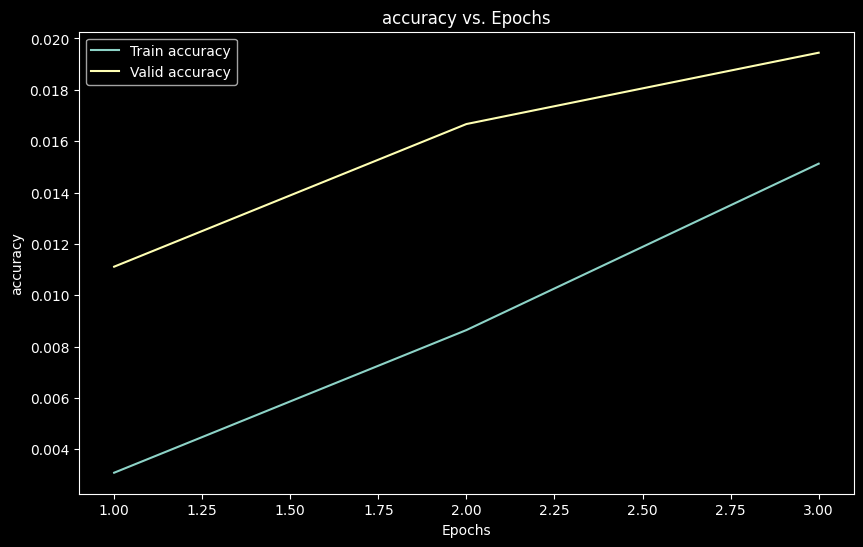

In [9]:
trainer.runner.cbs[1].plot_metric('accuracy')

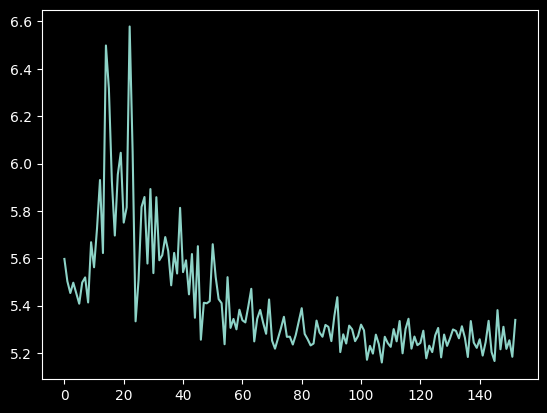

In [13]:
trainer.plot_loss()

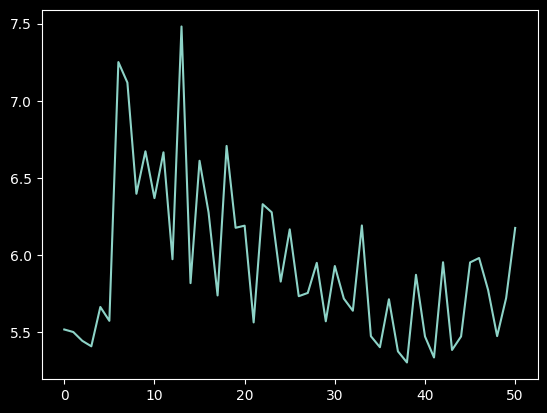

In [22]:
trainer.plot_loss()

## testing push


In [9]:
run = openml_pytorch.add_experiment_info_to_run(run=run, trainer=trainer)

In [ ]:
run.publish()

### Learning rate and loss plot

In [ ]:
trainer.plot_loss()

In [ ]:
trainer.plot_lr()

### Class labels

In [ ]:
trainer.model_classes

In [ ]:
trainer.cbfs

In [ ]:
trainer.experiment_name

In [ ]:
trainer.model

## Model Vizualization
- Sometimes you may want to visualize the model. You can either use netron or tensorboard for this purpose.

### Netron

In [ ]:
trainer.export_to_netron()

### Tensorboard
- By default, openml will log the tensorboard logs in the `tensorboard_logs` directory. You can view the logs by running `tensorboard --logdir tensorboard_logs` in the terminal.

## Publish your model to OpenML
- This is Optional, but publishing your model to OpenML will allow you to track your experiments and compare them with others.
- Make sure to set your apikey first.
  - You can find your apikey on your OpenML account page.

In [ ]:
run.publish()

# Pretrained Transformer Image Classification Task

In [ ]:
# openml imports
import openml
import openml_pytorch
from openml_pytorch.callbacks import TestCallback
from openml_pytorch.metrics import accuracy
from openml_pytorch.trainer import OpenMLDataModule, OpenMLTrainerModule, convert_to_rgb

# pytorch imports
from torch.utils.tensorboard.writer import SummaryWriter
from torchvision.transforms import Compose, Resize, ToPILImage, ToTensor, Lambda
import torchvision

# other imports
import logging
import warnings

# set up logging
openml.config.logger.setLevel(logging.DEBUG)
openml_pytorch.config.logger.setLevel(logging.DEBUG)
warnings.simplefilter(action='ignore')

## Data

### Define image transformations


In [ ]:

transform = Compose(
    [
        ToPILImage(),  # Convert tensor to PIL Image to ensure PIL Image operations can be applied.
        Lambda(convert_to_rgb),  # Convert PIL Image to RGB if it's not already.
        Resize((64, 64)),  # Resize the image.
        ToTensor(),  # Convert the PIL Image back to a tensor.
    ]
)


### Configure the Data Module and Choose a Task
- Make sure the data is present in the `file_dir` directory, and the `filename_col` is correctly set along with this column correctly pointing to where your data is stored. 


In [ ]:
data_module = OpenMLDataModule(
    type_of_data="image",
    file_dir="datasets",
    filename_col="image_path",
    target_mode="categorical",
    target_column="label",
    batch_size=64,
    transform=transform,
)

# Download the OpenML task for tiniest imagenet
task = openml.tasks.get_task(362128)


## Model

In [ ]:
# Example model. You can do better :)
import torchvision.models as models
import torch.nn as nn

# Load the pre-trained model
model = models.efficientnet_b0(pretrained=True)

# Modify the last fully connected layer to the required number of classes
num_classes = 200
in_features = model.classifier[-1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features, num_classes),
)

# Optional: If you're fine-tuning, you may want to freeze the pre-trained layers
# for param in model.parameters():
#     param.requires_grad = False

# # If you want to train the last layer only (the newly added layer)
# for param in model.fc.parameters():
#     param.requires_grad = True

## Train your model on the data
- Note that by default, OpenML runs a 10 fold cross validation on the data. You cannot change this for now.

In [ ]:


trainer = OpenMLTrainerModule(
    experiment_name= "Tiny ImageNet",
    data_module=data_module,
    verbose=True,
    epoch_count=1,
    metrics= [accuracy],
    # remove the TestCallback when you are done testing your pipeline. Having it here will make the pipeline run for a very short time.
    callbacks=[
        TestCallback,
    ],
)
openml_pytorch.config.trainer = trainer
run = openml.runs.run_model_on_task(model, task, avoid_duplicate_runs=False)

## View information about your run

### Learning rate and loss plot

In [ ]:
trainer.plot_loss()

In [ ]:
trainer.plot_lr()

### Class labels

In [ ]:
trainer.model_classes

## Model Vizualization
- Sometimes you may want to visualize the model. You can either use netron or tensorboard for this purpose.

### Netron

In [ ]:
trainer.export_to_netron()

### Tensorboard
- By default, openml will log the tensorboard logs in the `tensorboard_logs` directory. You can view the logs by running `tensorboard --logdir tensorboard_logs` in the terminal.

## Publish your model to OpenML
- This is Optional, but publishing your model to OpenML will allow you to track your experiments and compare them with others.
- Make sure to set your apikey first.
  - You can find your apikey on your OpenML account page.

In [ ]:
openml.config.apikey = ''
run.publish()

# Choose a custom Optimizer
- If you want to use a custom optimizer, you can do so by defining the optimizer in the `optimizer` variable.

In [1]:
# openml imports
import openml
import openml_pytorch
from openml_pytorch.callbacks import TestCallback
from openml_pytorch.metrics import accuracy
from openml_pytorch.trainer import OpenMLDataModule, OpenMLTrainerModule, convert_to_rgb

# pytorch imports
from torch.utils.tensorboard.writer import SummaryWriter
from torchvision.transforms import Compose, Resize, ToPILImage, ToTensor, Lambda
import torchvision

# other imports
import logging
import warnings

# set up logging
openml.config.logger.setLevel(logging.DEBUG)
openml_pytorch.config.logger.setLevel(logging.DEBUG)
warnings.simplefilter(action='ignore')

## Data

### Define image transformations


In [2]:

transform = Compose(
    [
        ToPILImage(),  # Convert tensor to PIL Image to ensure PIL Image operations can be applied.
        Lambda(convert_to_rgb),  # Convert PIL Image to RGB if it's not already.
        Resize((64, 64)),  # Resize the image.
        ToTensor(),  # Convert the PIL Image back to a tensor.
    ]
)


### Configure the Data Module and Choose a Task
- Make sure the data is present in the `file_dir` directory, and the `filename_col` is correctly set along with this column correctly pointing to where your data is stored. 


In [3]:
data_module = OpenMLDataModule(
    type_of_data="image",
    file_dir="datasets",
    filename_col="image_path",
    target_mode="categorical",
    target_column="label",
    batch_size=64,
    transform=transform,
)

# Download the OpenML task for tiniest imagenet
task = openml.tasks.get_task(362128)


## Model

In [4]:
model = torchvision.models.resnet18(num_classes=200)

## Train your model on the data
- Choose a custom optimizer by defining the optimizer variable.
- Note that by default, OpenML runs a 10 fold cross validation on the data. You cannot change this for now.

In [5]:
import torch
from torch.optim import Adam, Optimizer
from openml_pytorch.trainer import OpenMLTask

def custom_optimizer_gen(model: torch.nn.Module, task: OpenMLTask) -> Optimizer:
    # replace the optimizer with your own
    return Adam(model.fc.parameters())


In [ ]:
trainer = OpenMLTrainerModule(
    experiment_name= "Tiny ImageNet",
    data_module=data_module,
    verbose=True,
    epoch_count=1,
    metrics= [accuracy],
    # remove the TestCallback when you are done testing your pipeline. Having it here will make the pipeline run for a very short time.
    callbacks=[
        TestCallback,
    ],
    optimizer = custom_optimizer_gen,
)
openml_pytorch.config.trainer = trainer
run = openml.runs.run_model_on_task(model, task, avoid_duplicate_runs=False)

## View information about your run

### Learning rate and loss plot

In [ ]:
trainer.plot_loss()

In [ ]:
trainer.plot_lr()

### Class labels

In [ ]:
trainer.model_classes

## Model Vizualization
- Sometimes you may want to visualize the model. You can either use netron or tensorboard for this purpose.

### Netron

In [ ]:
trainer.export_to_netron()

### Tensorboard
- By default, openml will log the tensorboard logs in the `tensorboard_logs` directory. You can view the logs by running `tensorboard --logdir tensorboard_logs` in the terminal.

## Publish your model to OpenML
- This is Optional, but publishing your model to OpenML will allow you to track your experiments and compare them with others.
- Make sure to set your apikey first.
  - You can find your apikey on your OpenML account page.

In [ ]:
openml.config.apikey = ''
run.publish()

# Sequential Classification Task
- Sequential classification of a tabular MNIST dataset (Task 3573) using a simple neural network.

In [4]:
# openml imports
import openml
import openml_pytorch
from openml_pytorch.callbacks import TestCallback
from openml_pytorch.metrics import accuracy
from openml_pytorch.trainer import OpenMLDataModule, OpenMLTrainerModule, convert_to_rgb

# pytorch imports
import torch

# other imports
import logging
import warnings

# set up logging
openml.config.logger.setLevel(logging.DEBUG)
openml_pytorch.config.logger.setLevel(logging.DEBUG)
warnings.simplefilter(action='ignore')

## Data

### Configure the Data Module and Choose a Task
- Make sure the data is present in the `file_dir` directory, and the `filename_col` is correctly set along with this column correctly pointing to where your data is stored. 


In [5]:
data_module = OpenMLDataModule(
    type_of_data="dataframe",
    filename_col="class",
    target_mode="categorical",
)

# Download the OpenML task for the mnist 784 dataset.
task = openml.tasks.get_task(3573)

## Model

In [6]:

############################################################################
# Define a sequential network that does the initial image reshaping
# and normalization model.
processing_net = torch.nn.Sequential(
    openml_pytorch.layers.Functional(function=torch.Tensor.reshape,
                                                shape=(-1, 1, 28, 28)),
    torch.nn.BatchNorm2d(num_features=1)
)
############################################################################

############################################################################
# Define a sequential network that does the extracts the features from the
# image.
features_net = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5),
    torch.nn.LeakyReLU(),
    torch.nn.MaxPool2d(kernel_size=2),
    torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
    torch.nn.LeakyReLU(),
    torch.nn.MaxPool2d(kernel_size=2),
)
############################################################################

############################################################################
# Define a sequential network that flattens the features and compiles the
# results into probabilities for each digit.
results_net = torch.nn.Sequential(
    openml_pytorch.layers.Functional(function=torch.Tensor.reshape,
                                                shape=(-1, 4 * 4 * 64)),
    torch.nn.Linear(in_features=4 * 4 * 64, out_features=256),
    torch.nn.LeakyReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(in_features=256, out_features=10),
)
############################################################################
# openml.config.apikey = 'key'

############################################################################
# The main network, composed of the above specified networks.
model = torch.nn.Sequential(
    processing_net,
    features_net,
    results_net
)
############################################################################


## Train your model on the data
- Note that by default, OpenML runs a 10 fold cross validation on the data. You cannot change this for now.

In [ ]:
trainer = OpenMLTrainerModule(
    experiment_name= "MNIST",
    data_module=data_module,
    verbose=True,
    epoch_count=1,
    metrics= [accuracy],
    # remove the TestCallback when you are done testing your pipeline. Having it here will make the pipeline run for a very short time.
    callbacks=[
        TestCallback,
    ],
)
openml_pytorch.config.trainer = trainer
run = openml.runs.run_model_on_task(model, task, avoid_duplicate_runs=False)

## View information about your run

### Learning rate and loss plot

In [ ]:
trainer.plot_loss()

In [ ]:
trainer.plot_lr()

### Class labels

In [ ]:
trainer.model_classes

## Model Vizualization
- Sometimes you may want to visualize the model. You can either use netron or tensorboard for this purpose.

### Netron

In [ ]:
trainer.export_to_netron()

### Tensorboard
- By default, openml will log the tensorboard logs in the `tensorboard_logs` directory. You can view the logs by running `tensorboard --logdir tensorboard_logs` in the terminal.

## Publish your model to OpenML
- This is Optional, but publishing your model to OpenML will allow you to track your experiments and compare them with others.
- Make sure to set your apikey first.
  - You can find your apikey on your OpenML account page.

In [ ]:
openml.config.apikey = ''
run.publish()

# Tabular classification
- Supervised credit-g classification

In [19]:
# openml imports
import openml
import openml_pytorch
from openml_pytorch.callbacks import TestCallback
from openml_pytorch.metrics import accuracy
from openml_pytorch.trainer import OpenMLDataModule, OpenMLTrainerModule, convert_to_rgb

# pytorch imports
import torch

# other imports
import logging
import warnings

# set up logging
openml.config.logger.setLevel(logging.DEBUG)
openml_pytorch.config.logger.setLevel(logging.DEBUG)
warnings.simplefilter(action='ignore')

## Data

### Define image transformations


### Configure the Data Module and Choose a Task
- Make sure the data is present in the `file_dir` directory, and the `filename_col` is correctly set along with this column correctly pointing to where your data is stored. 


In [20]:
data_module = OpenMLDataModule(
    type_of_data="dataframe",
    target_column="class",
    target_mode="categorical",
)

# supervised credit-g classification
task = openml.tasks.get_task(31)


## Model

In [21]:
class TabularClassificationmodel(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(TabularClassificationmodel, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, output_size)
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x
    
model = TabularClassificationmodel(20, 2)

## Train your model on the data
- Note that by default, OpenML runs a 10 fold cross validation on the data. You cannot change this for now.

In [ ]:


trainer = OpenMLTrainerModule(
    experiment_name= "Credit-G",
    data_module=data_module,
    verbose=True,
    epoch_count=5,
    metrics= [accuracy],
    # remove the TestCallback when you are done testing your pipeline. Having it here will make the pipeline run for a very short time.
    callbacks=[
        TestCallback,
    ],
)
openml_pytorch.config.trainer = trainer
run = openml.runs.run_model_on_task(model, task, avoid_duplicate_runs=False)

## View information about your run

### Learning rate and loss plot

In [ ]:
trainer.plot_loss()

In [ ]:
trainer.plot_lr()

### Class labels

In [ ]:
trainer.model_classes

## Model Vizualization
- Sometimes you may want to visualize the model. You can either use netron or tensorboard for this purpose.

### Netron

In [ ]:
trainer.export_to_netron()

### Tensorboard
- By default, openml will log the tensorboard logs in the `tensorboard_logs` directory. You can view the logs by running `tensorboard --logdir tensorboard_logs` in the terminal.

## Publish your model to OpenML
- This is Optional, but publishing your model to OpenML will allow you to track your experiments and compare them with others.
- Make sure to set your apikey first.
  - You can find your apikey on your OpenML account page.

In [ ]:
openml.config.apikey = ''
run.publish()